In [228]:
import numpy as np
import pandas as pd
import glob
import emcee
import matplotlib.pyplot as plt

from corner_hack import corner_hack

In [229]:
%matplotlib notebook

In [230]:
info_path="../../forced_lightcurves/sample_lc_v2/"
salt_df = pd.read_csv(info_path + "../../Nobs_cut_salt2_spec_subtype.csv")

In [243]:
thin_by = 250

name_arr = np.empty(len(chain_files)).astype('S12')
conv_arr = np.zeros(len(chain_files)).astype(bool)
t0_16 = np.empty(len(chain_files)).astype('float')
t0_arr = np.empty(len(chain_files)).astype('float')
t0_84 = np.empty(len(chain_files)).astype('float')
alpha_g_16 = np.empty(len(chain_files)).astype('float')
alpha_g_84 = np.empty(len(chain_files)).astype('float')
alpha_g_arr = np.empty(len(chain_files)).astype('float')
alpha_r_16 = np.empty(len(chain_files)).astype('float')
alpha_r_arr = np.empty(len(chain_files)).astype('float')
alpha_r_84 = np.empty(len(chain_files)).astype('float')

for filenum, sn in enumerate(salt_df.name.values):
    h5_file = info_path + '{}_emcee.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    name_arr[filenum] = sn
    tau = reader.get_autocorr_time(tol=0)
    if (np.isfinite(tau).all() and 
        nsteps > int(100*np.max(tau))*thin_by and 
        nsteps < 2000000):
        burnin = int(5*np.max(tau))
        samples = reader.get_chain(discard=burnin, flat=True)
        if (np.median(samples[:,0]) < 1e6) and ((np.median(samples[:,-1]) < 1e6)):
            conv_arr[filenum] = True
            t0_16[filenum], t0_arr[filenum], t0_84[filenum] = np.percentile(samples[:,0], (16, 50, 84))
            alpha_g_16[filenum], alpha_g_arr[filenum], alpha_g_84[filenum] = np.percentile(samples[:,3], (16, 50, 84))
            alpha_r_16[filenum], alpha_r_arr[filenum], alpha_r_84[filenum] = np.percentile(samples[:,6], (16, 50, 84))
        else:
            print(('\t\t', sn, '"converged" but alpha = 1e8, tau=',  int(np.max(tau))*thin_by))

    elif (np.isfinite(tau).all() and 
        nsteps > int(100*np.max(tau))*thin_by and 
        nsteps == 1700000):
        burnin = int(5*np.max(tau))
        samples = reader.get_chain(discard=burnin, flat=True)

        t0_16[filenum], t0_arr[filenum], t0_84[filenum] = np.percentile(samples[:,0], (16, 50, 84))
        alpha_g_16[filenum], alpha_g_arr[filenum], alpha_g_84[filenum] = np.percentile(samples[:,3], (16, 50, 84))
        alpha_r_16[filenum], alpha_r_arr[filenum], alpha_r_84[filenum] = np.percentile(samples[:,6], (16, 50, 84))
        print(sn, int(np.max(tau))*thin_by, "might converge")
    elif np.isfinite(tau).all():
        print('\t\t', "will not converge", sn, int(np.max(tau))*thin_by)
    else:
        print('\t\t', "tau is NaN", sn)

		 will not converge ZTF18aaqcozd 34250
('\t\t', 'ZTF18aaqcqkv', '"converged" but alpha = 1e8, tau=', 1000)
		 will not converge ZTF18aaumeys 42500
		 will not converge ZTF18aazabmh 28250
		 will not converge ZTF18abbvsiv 52500
		 will not converge ZTF18abetewu 27500
		 tau is NaN ZTF18abixjey
		 will not converge ZTF18abmmkaz 55000


In [ ]:
# source list for continued MCMC chains
source_list = ['ZTF18abukmty', 'ZTF18aarldnh', 'ZTF18absdgon', 'ZTF18aaqcqkv', 'ZTF18aaxakhh', 'ZTF18aasesgl']
no_converge = ['ZTF18aawurud', 'ZTF18aaqnrum', 'ZTF18abetehf', 'ZTF18abcecfi', 'ZTF18aapsedq', 'ZTF18aaykjei', 
               'ZTF18abkhcwl', 'ZTF18aaunfqq', 'ZTF18aaxqyki', 'ZTF18abhpgje', 'ZTF18aaxrvzj', 'ZTF18aaydmkh', 
               'ZTF18aaxvpsw', 'ZTF18abmxdhb', 'ZTF18aatzygk', 'ZTF18aaqcozd', 'ZTF18aaqcugm', 'ZTF18abnvoel', 
               'ZTF18aaslhxt']
time_list = [7807]

little_more = ['ZTF18aawurud', 'ZTF18aaqcugm', 'ZTF18aaslhxt']
time_list = [11116.86, 7668.80, ]

In [248]:
conv = np.where(conv_arr)
more_time = len(np.where((t0_arr < -7) & (conv_arr == False))[0])
no_converge = len(np.where((t0_arr > -7) & (conv_arr == False))[0])
print('There are {} light curves where the chains converged'.format(sum(conv_arr)))
print('There are {} light curves that will likely converged with more steps'.format(more_time))
print('There are {} light curves that will probably not converge'.format(no_converge))

There are 119 light curves where the chains converged
There are 0 light curves that will likely converged with more steps
There are 8 light curves that will probably not converge


In [250]:
res_df = pd.DataFrame(data=name_arr, columns=['ztf_name'])
res_df['t0'] = t0_arr
res_df['t0_16'] = t0_16
res_df['t0_84'] = t0_84
res_df['alpha_g'] = alpha_g_arr
res_df['alpha_g_16'] = alpha_g_16
res_df['alpha_g_84'] = alpha_g_84
res_df['alpha_r'] = alpha_r_arr
res_df['alpha_r_16'] = alpha_r_16
res_df['alpha_r_84'] = alpha_r_84
res_df['conv_arr'] = conv_arr.astype(int)
res_df.to_csv('intermediate_results.csv', index=False)


merge_df = salt_df.copy()
merge_df['t0'] = t0_arr
merge_df['t0_16'] = t0_16
merge_df['t0_84'] = t0_84
merge_df['alpha_g'] = alpha_g_arr
merge_df['alpha_g_16'] = alpha_g_16
merge_df['alpha_g_84'] = alpha_g_84
merge_df['alpha_r'] = alpha_r_arr
merge_df['alpha_r_16'] = alpha_r_16
merge_df['alpha_r_84'] = alpha_r_84
merge_df['conv_arr'] = conv_arr.astype(int)
merge_df.to_csv('merged_table.csv', index=False)

### Make plots

<IPython.core.display.Javascript object>


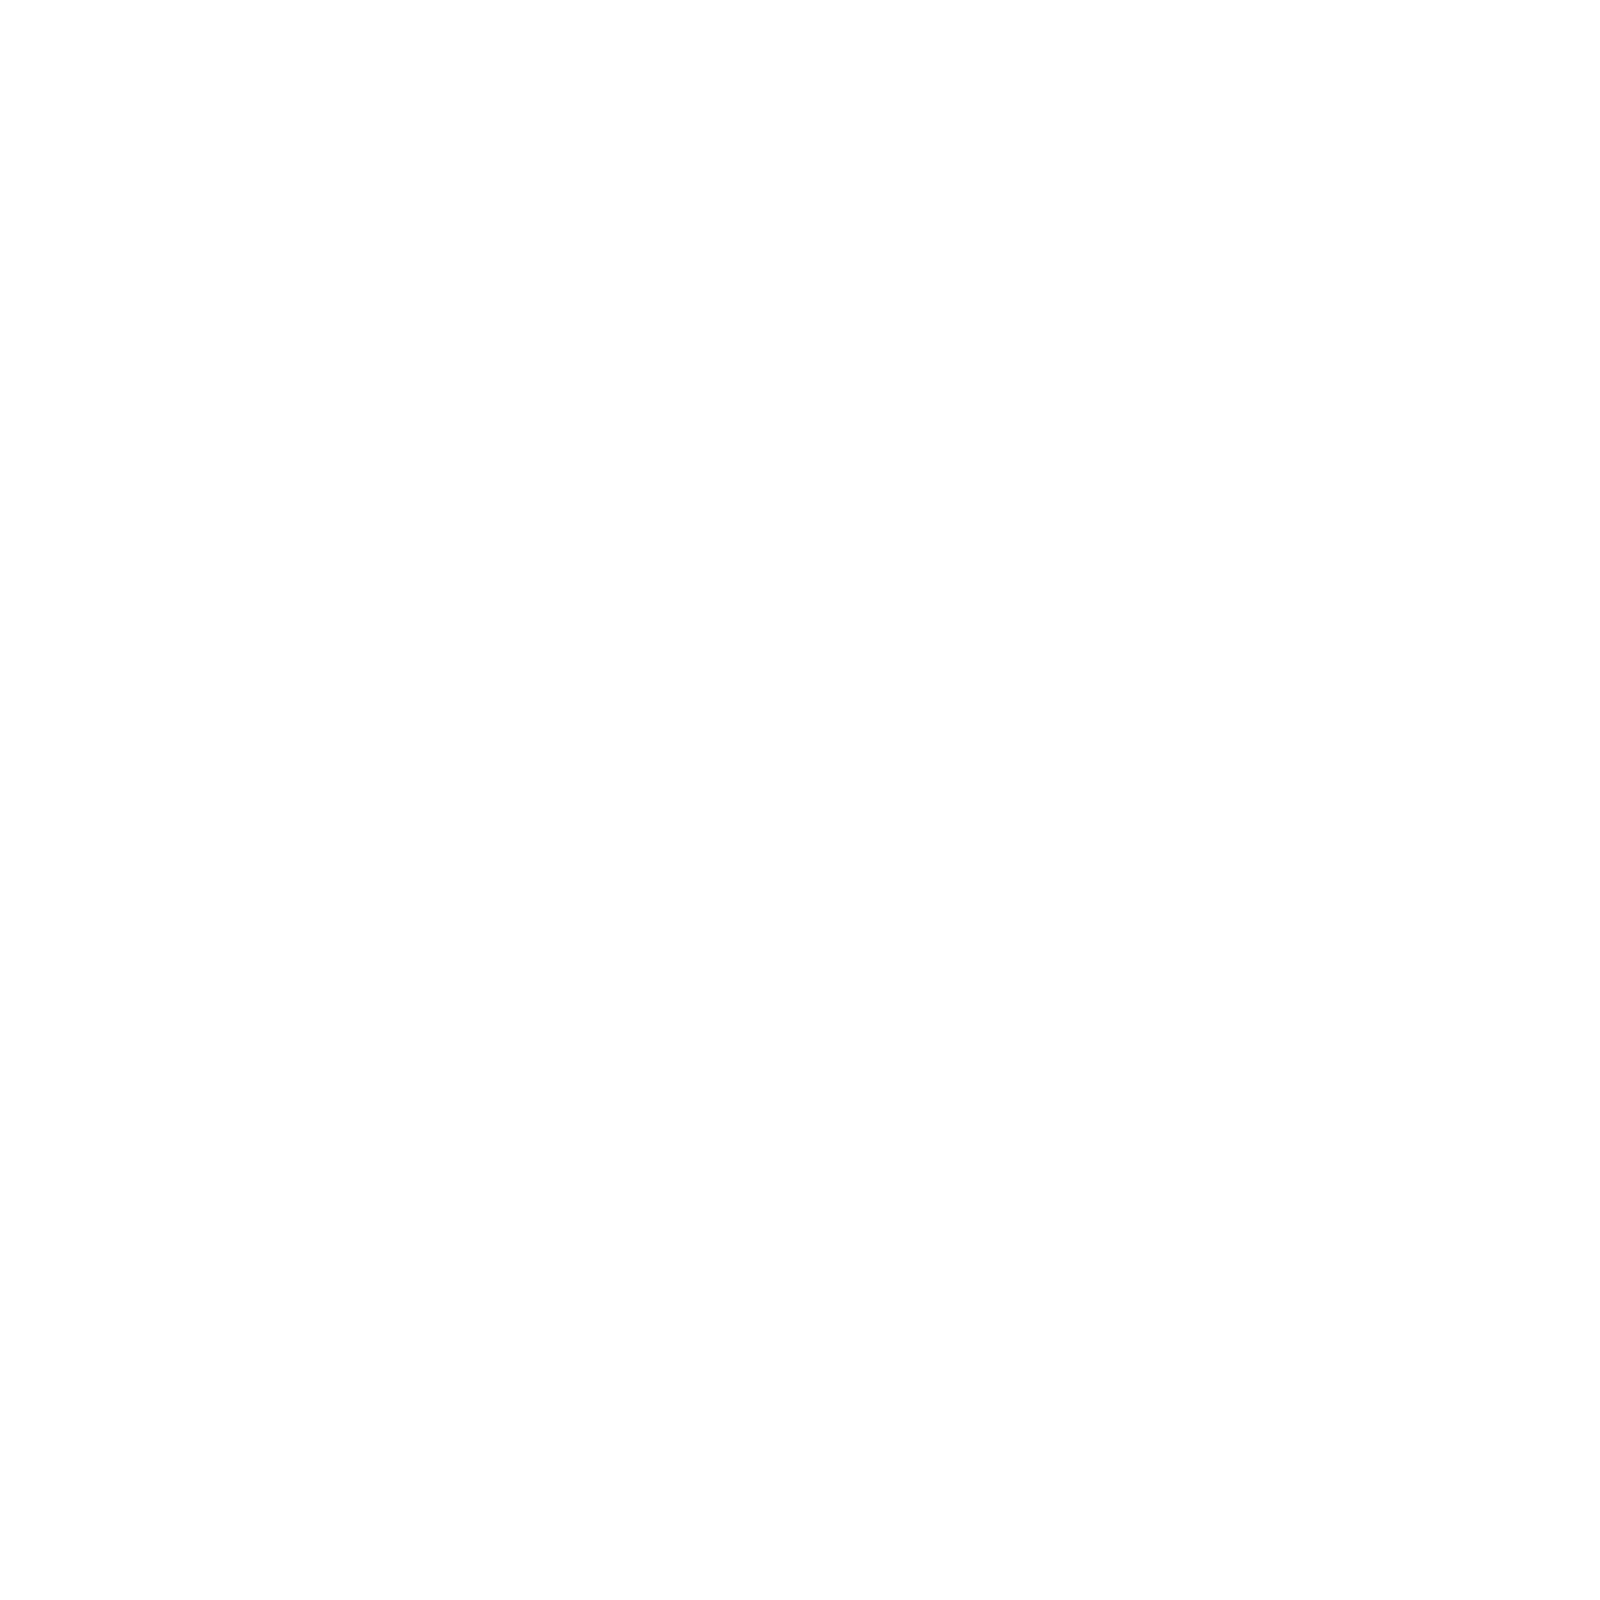

<IPython.core.display.Javascript object>


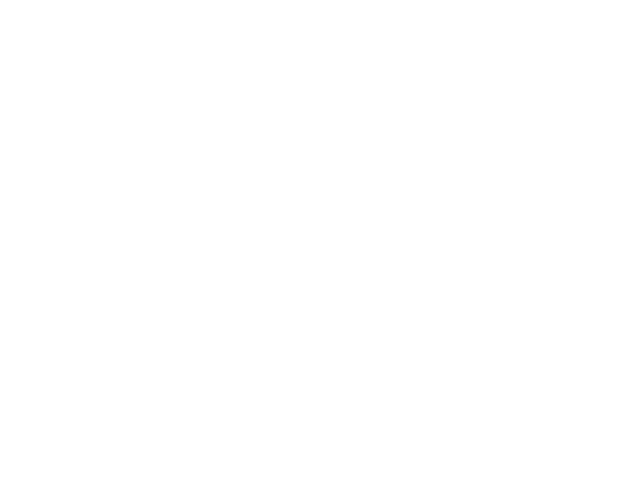

<IPython.core.display.Javascript object>


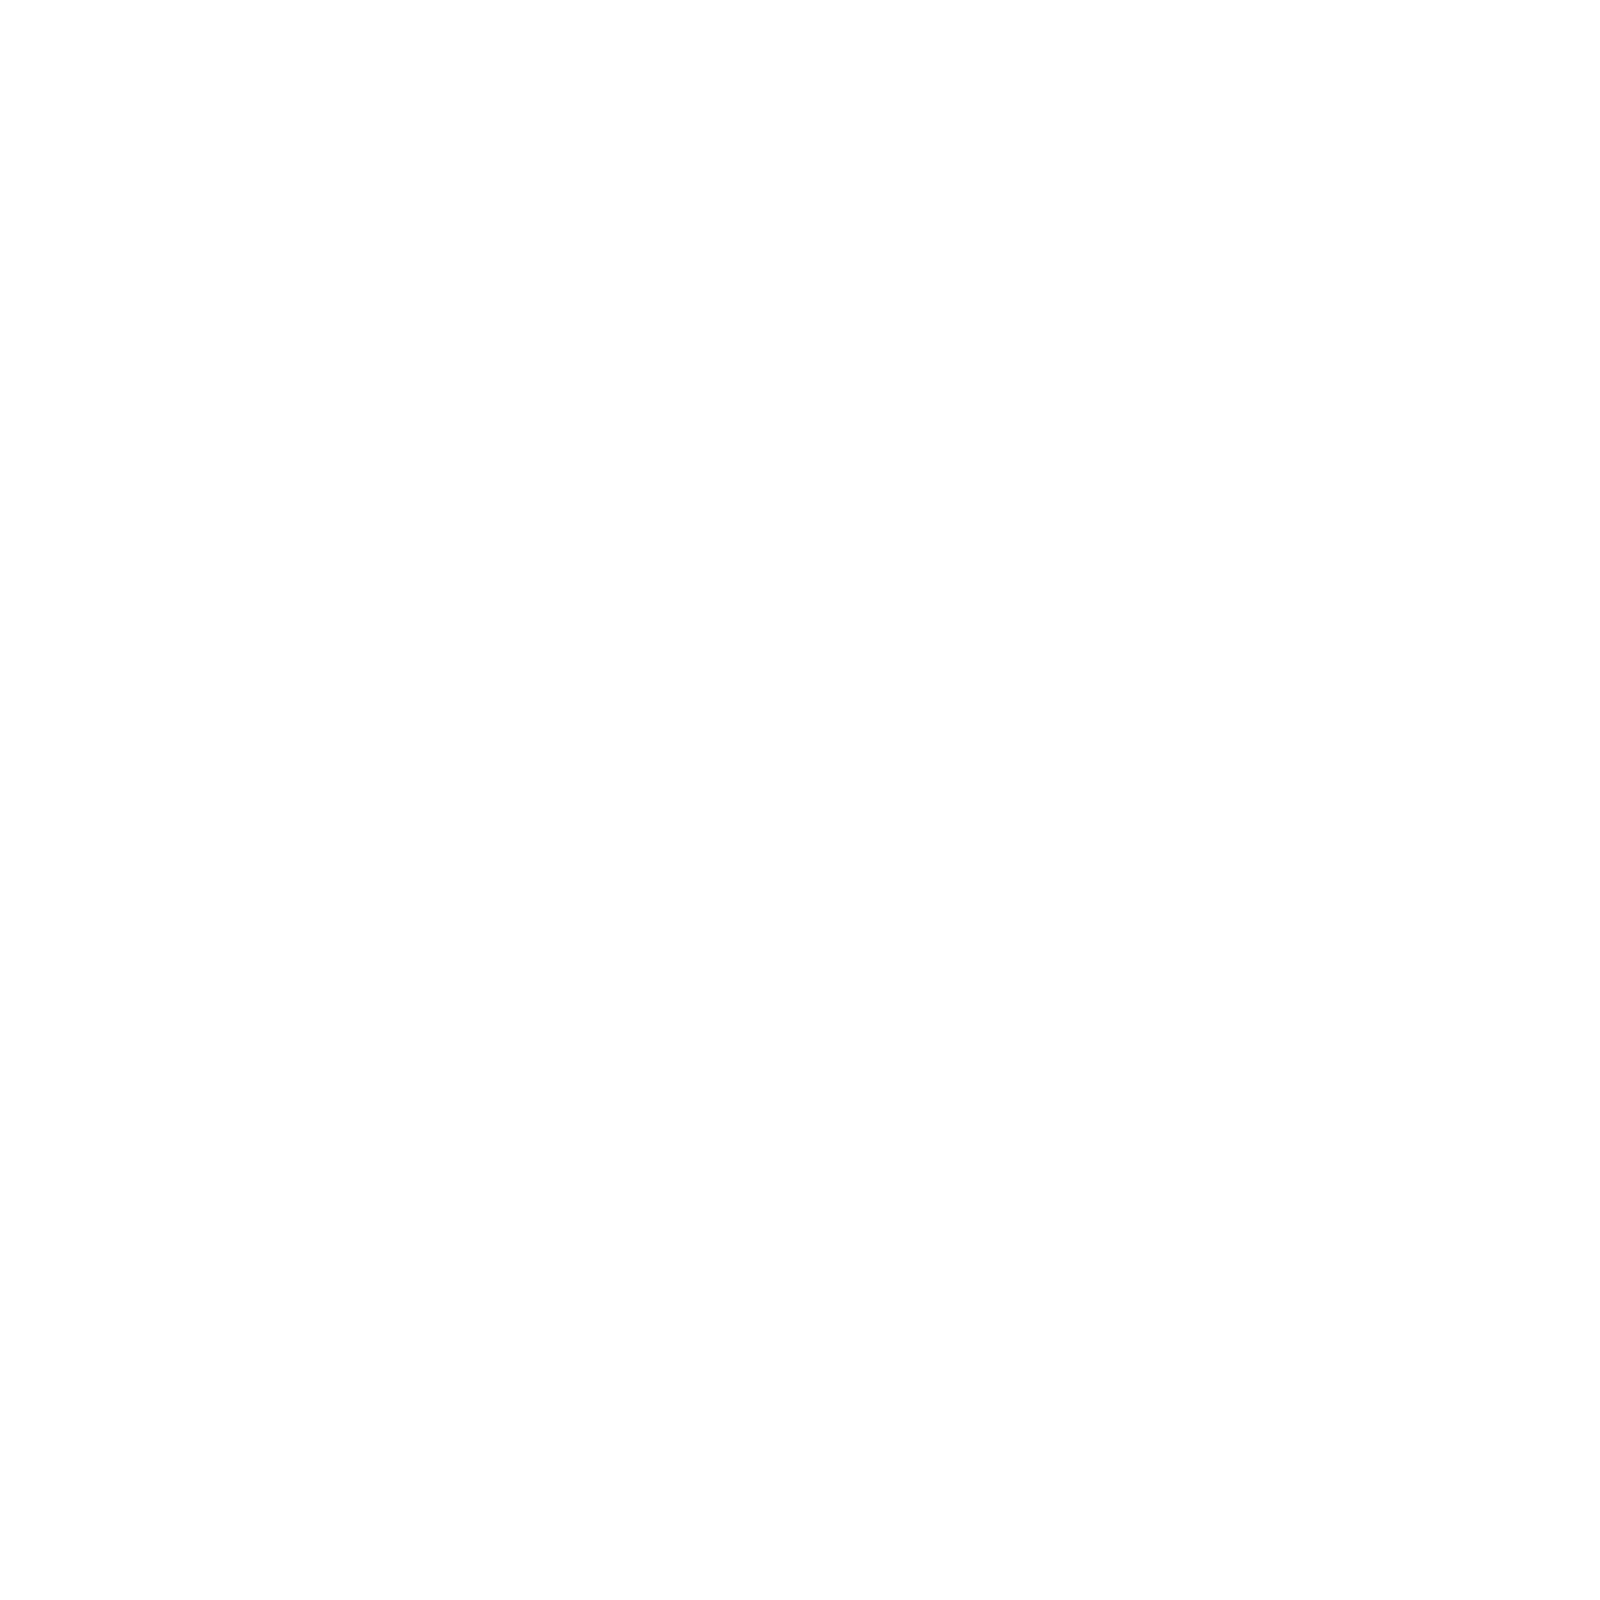

<IPython.core.display.Javascript object>


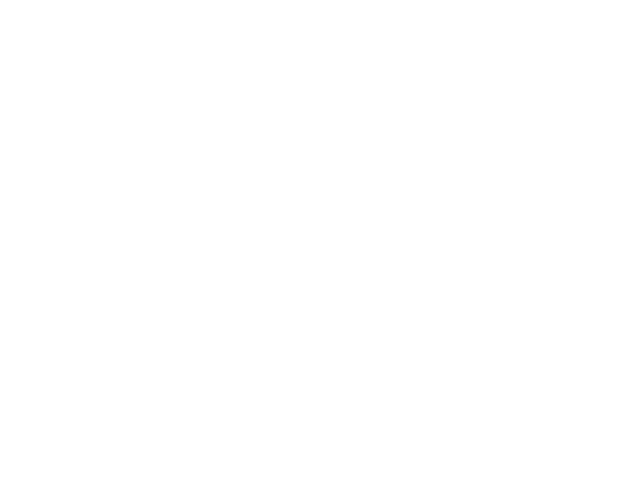

<IPython.core.display.Javascript object>


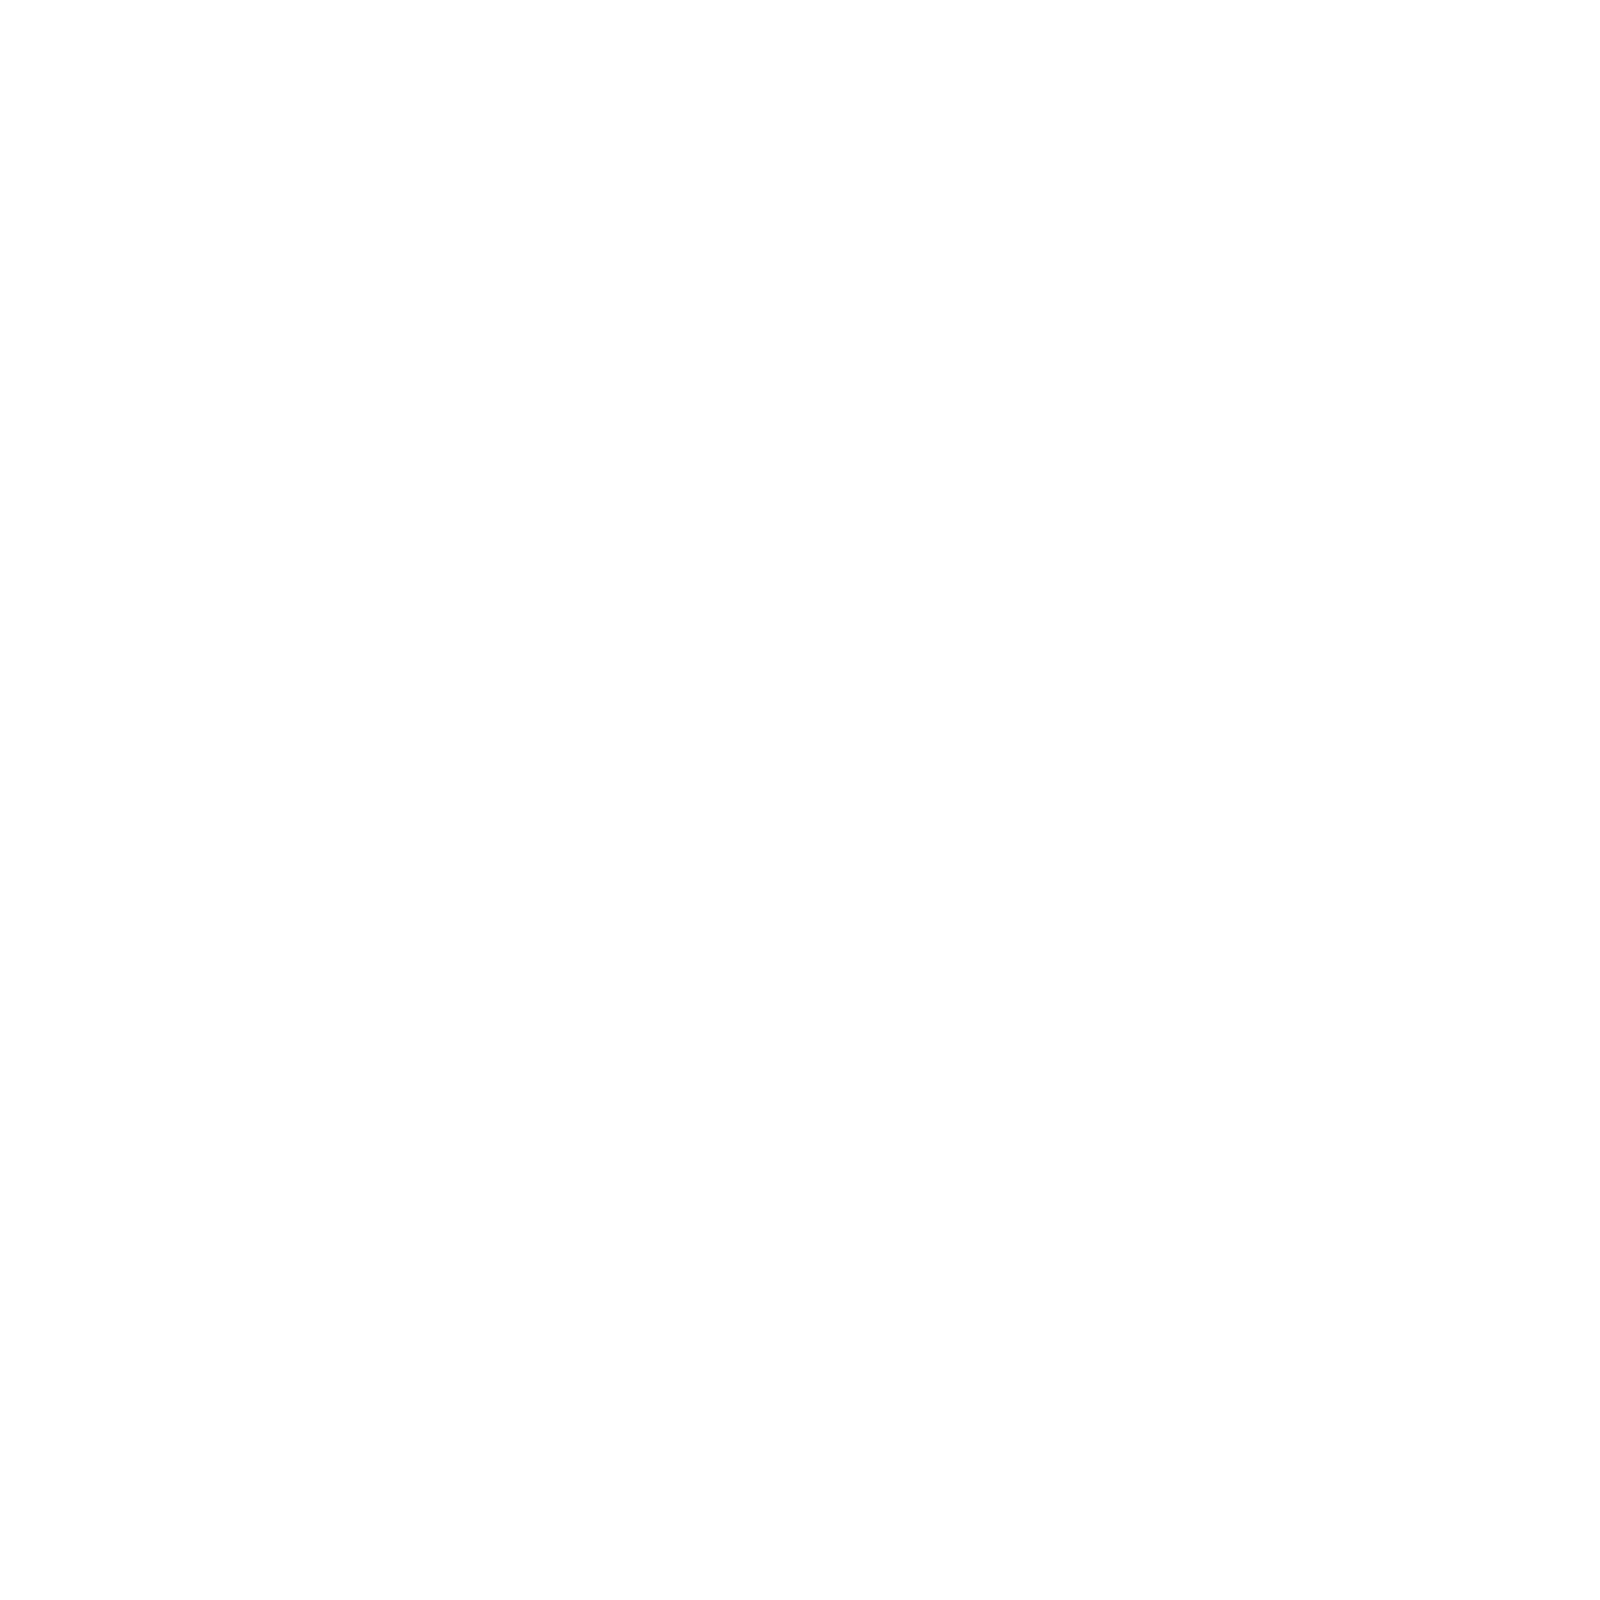

<IPython.core.display.Javascript object>


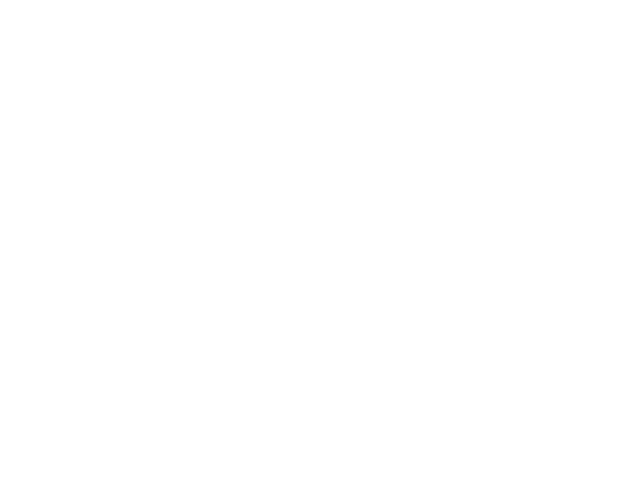

<IPython.core.display.Javascript object>


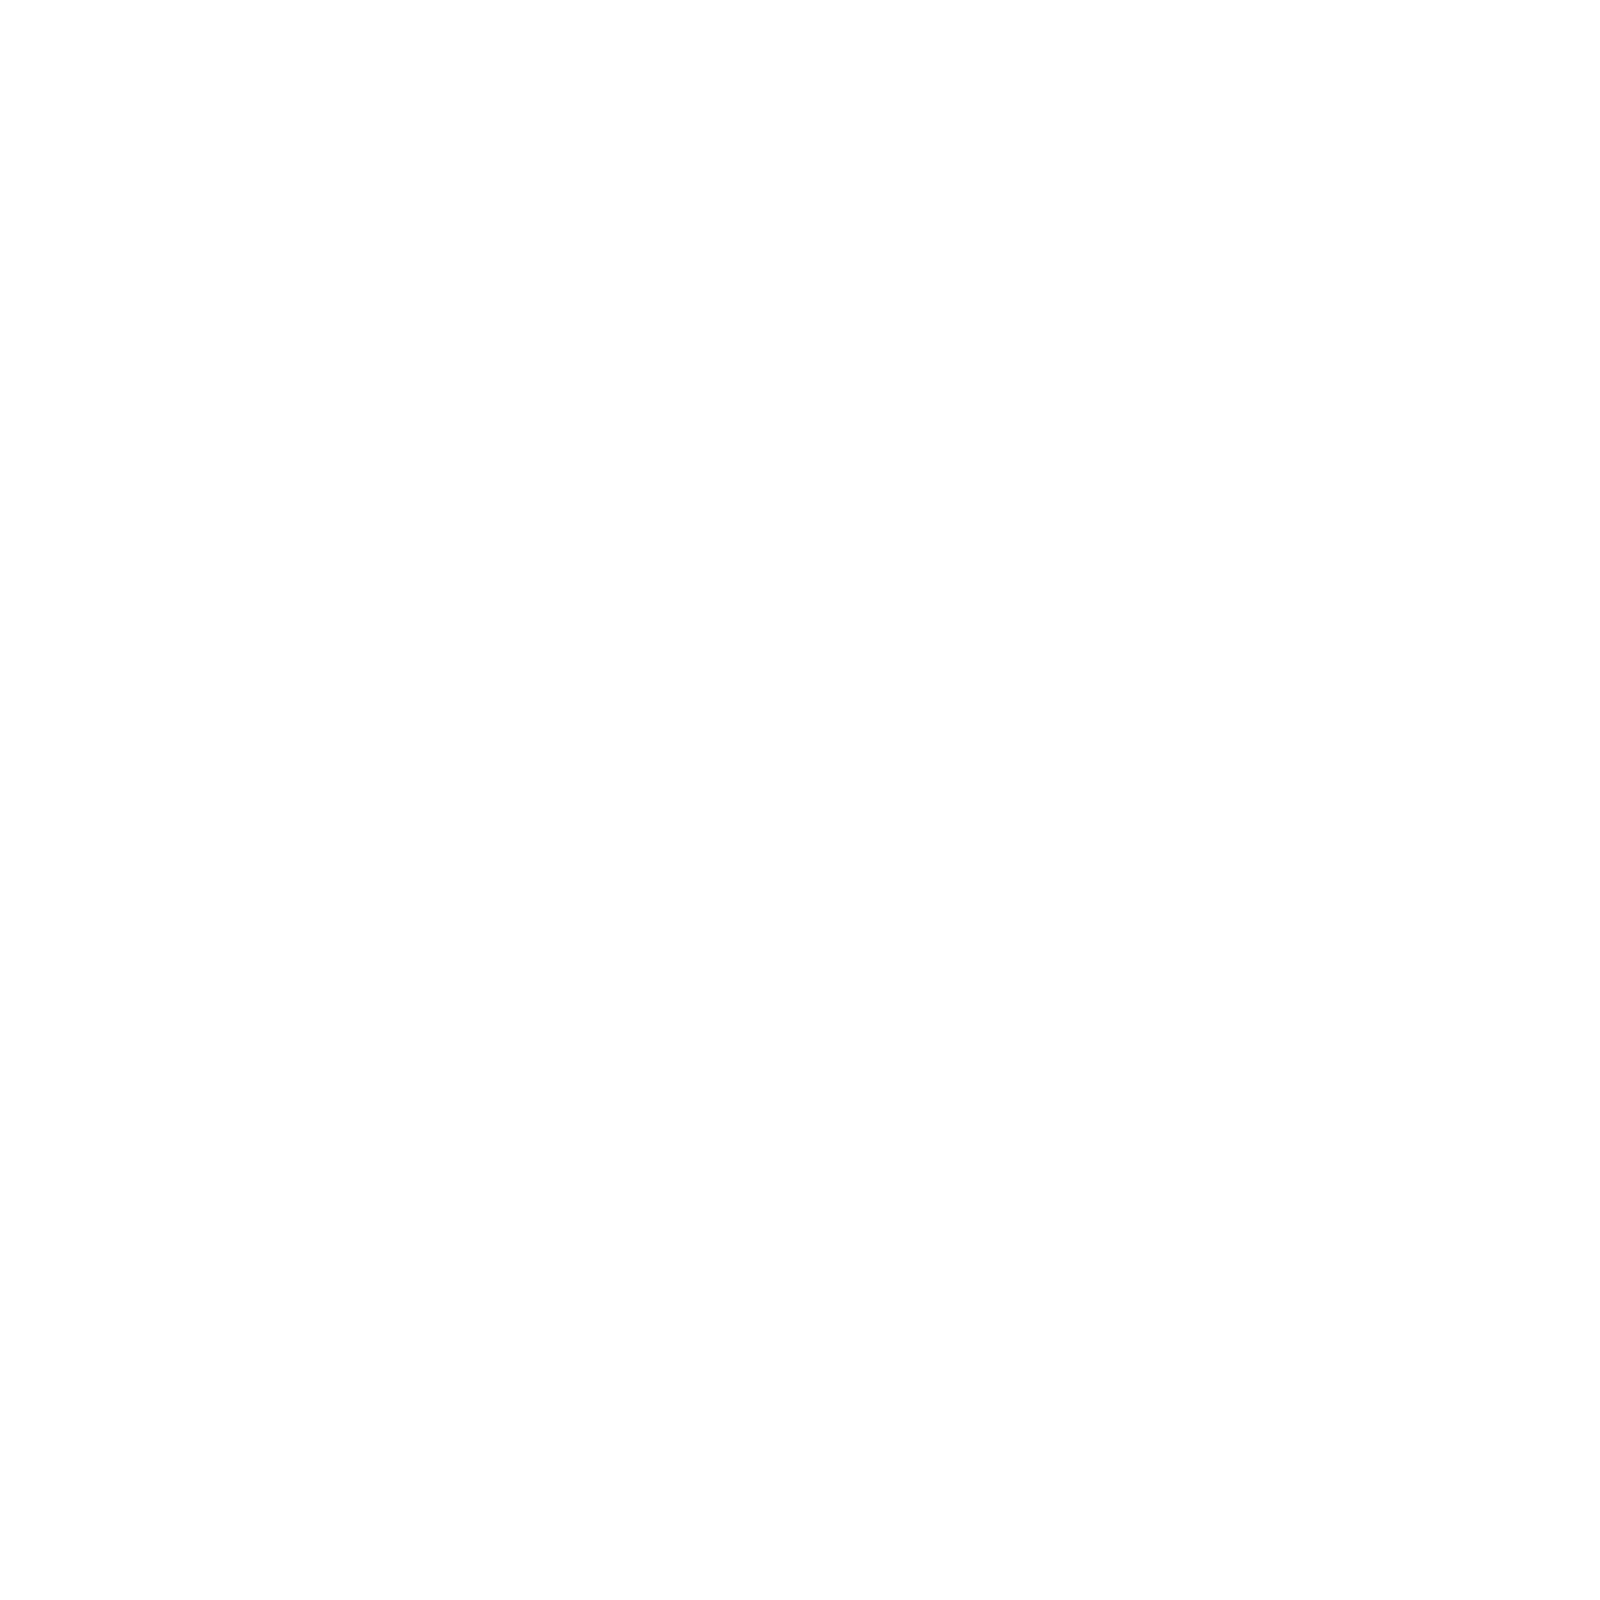

<IPython.core.display.Javascript object>


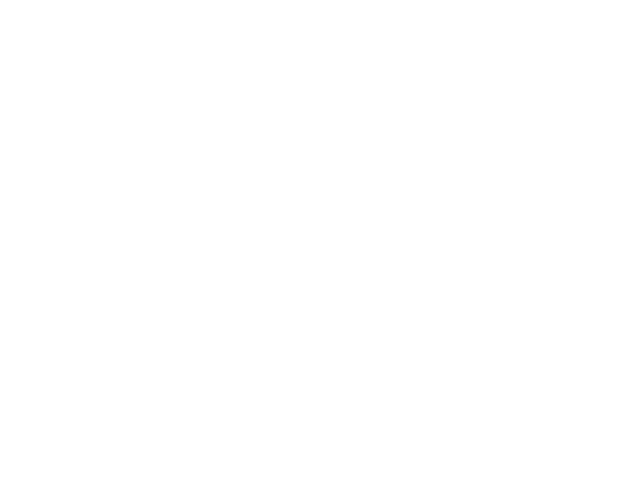

<IPython.core.display.Javascript object>


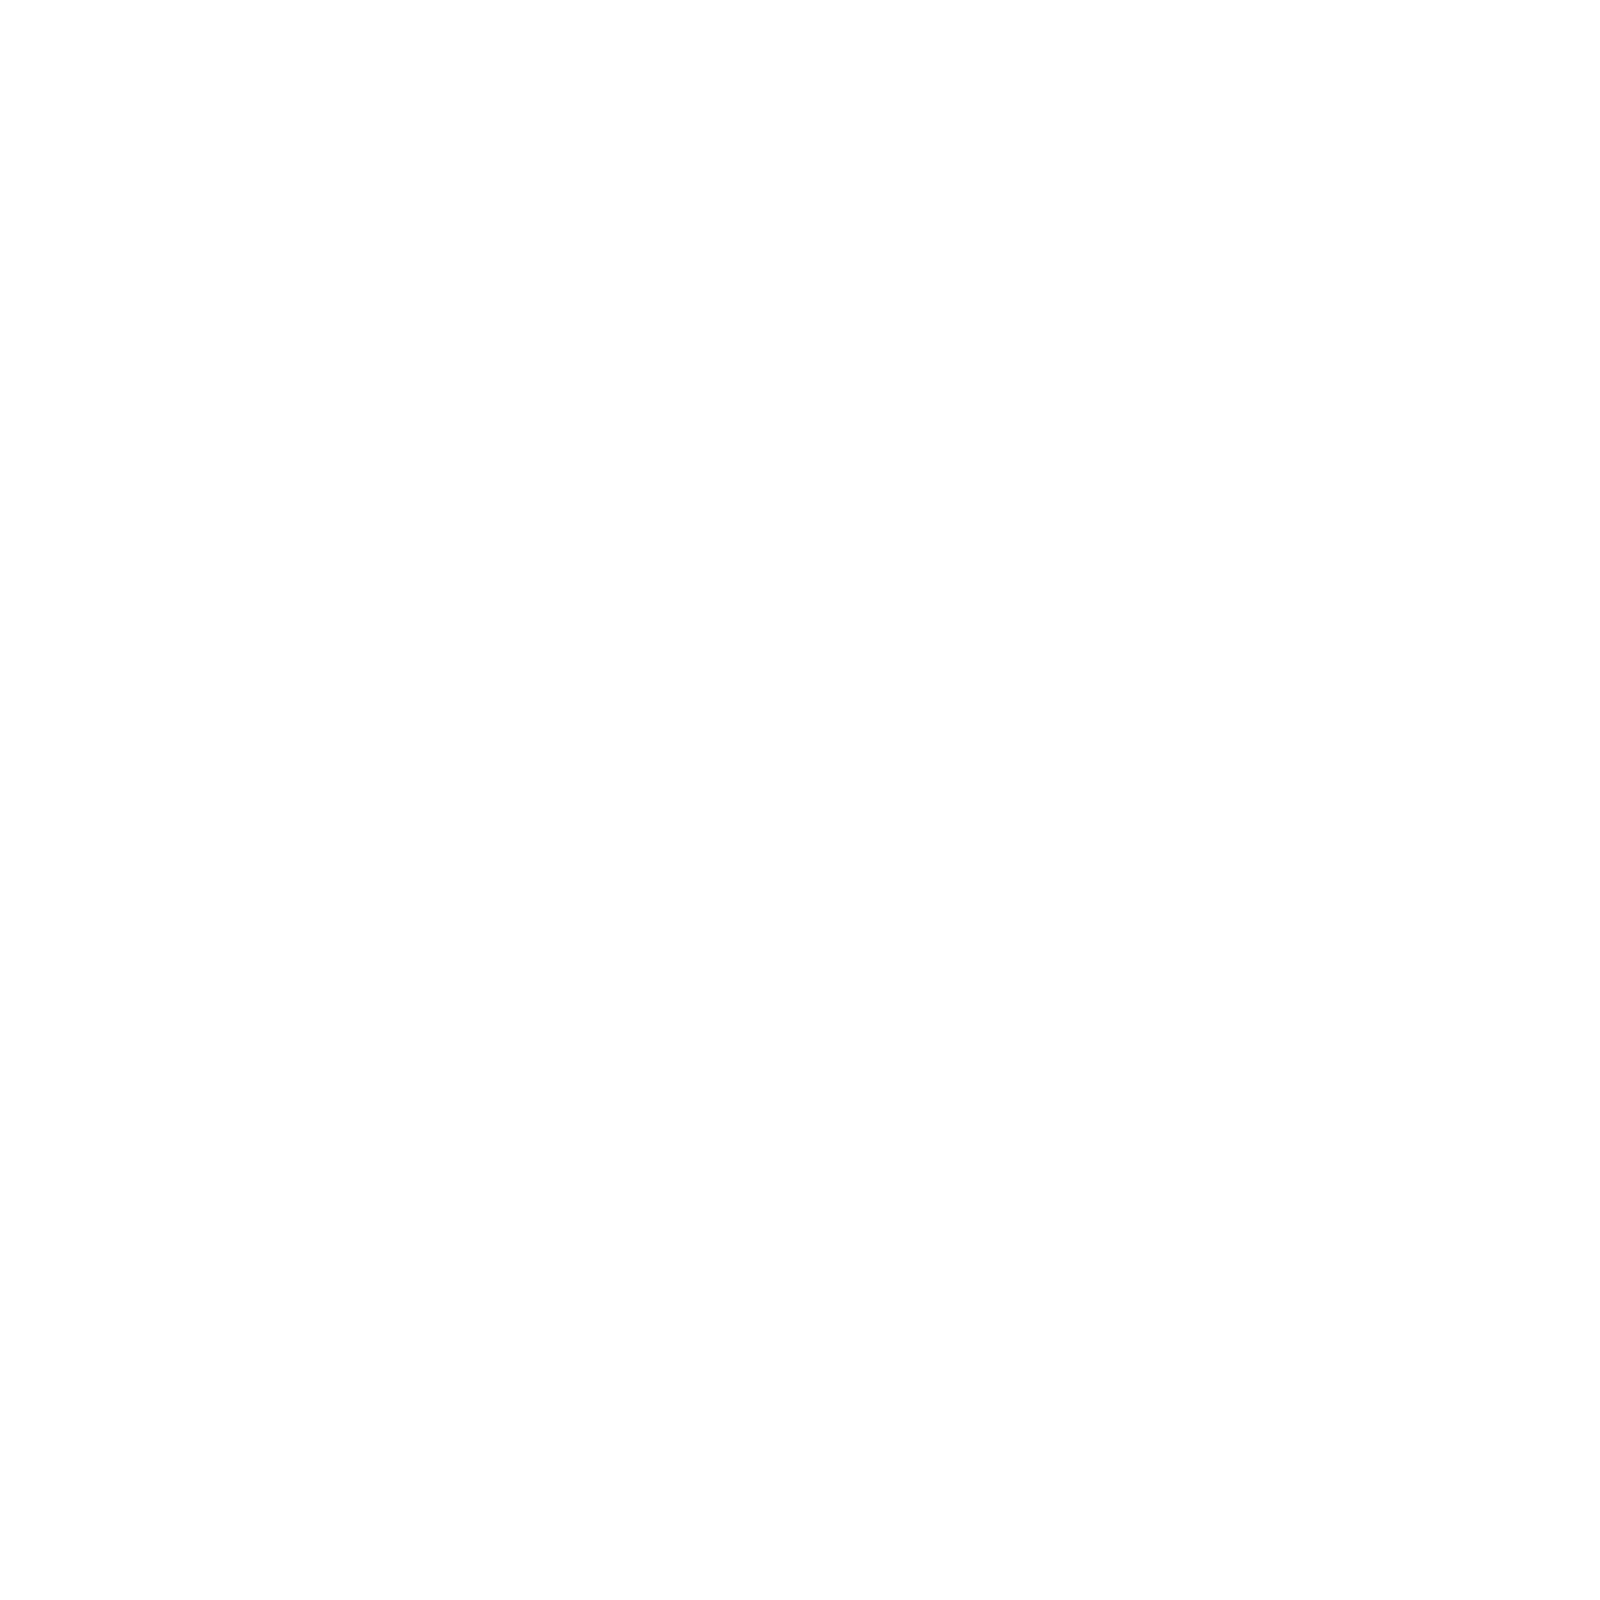

<IPython.core.display.Javascript object>


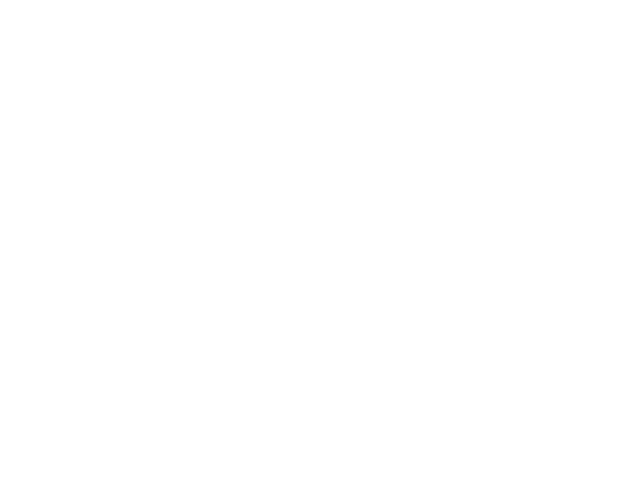

<IPython.core.display.Javascript object>


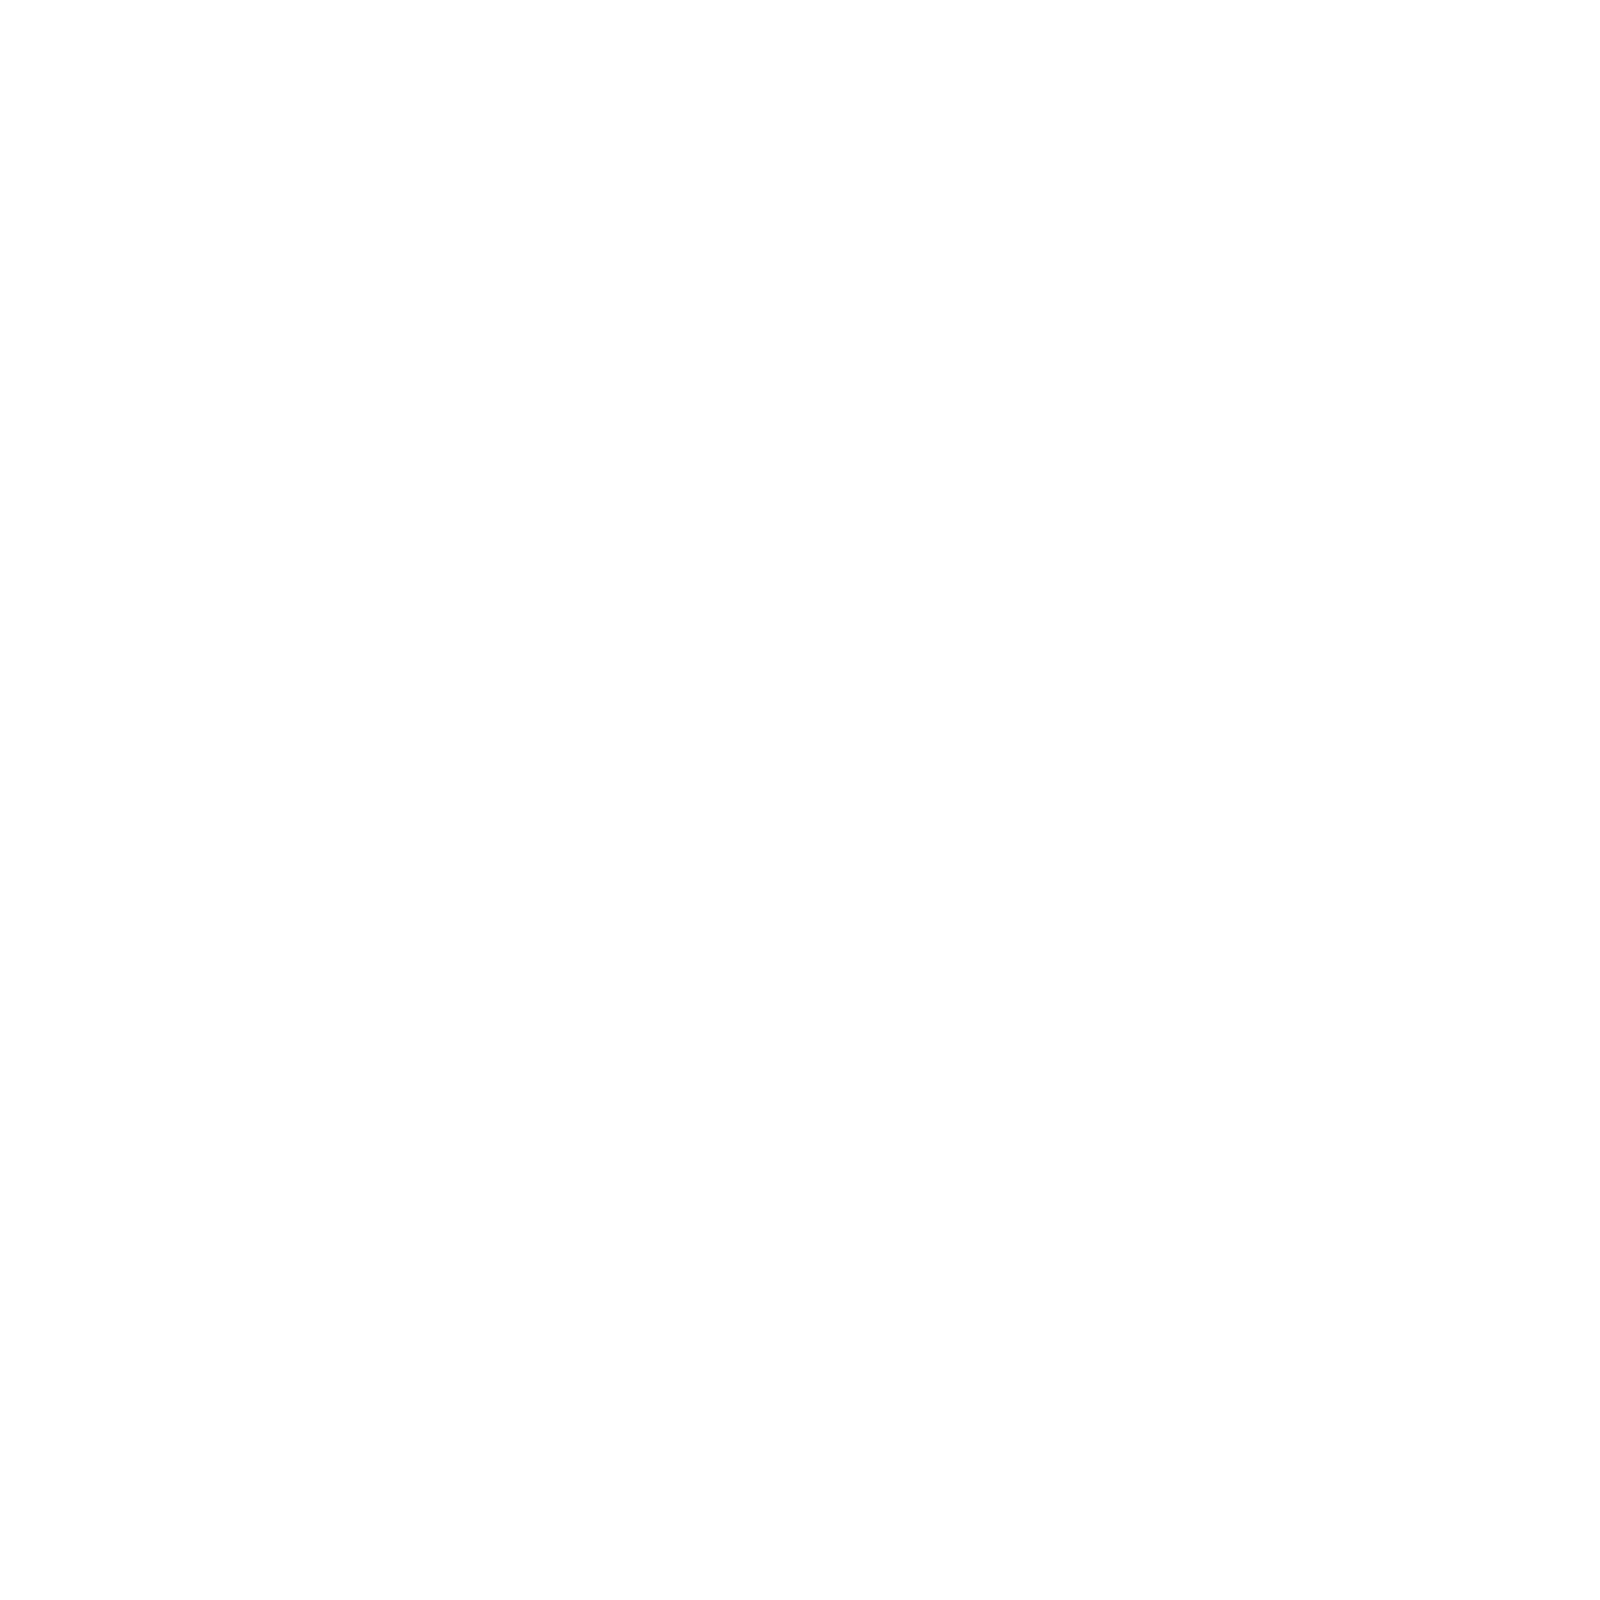

<IPython.core.display.Javascript object>


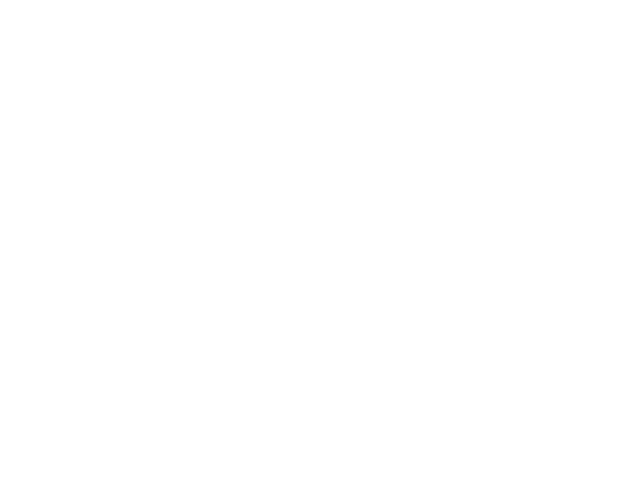

<IPython.core.display.Javascript object>


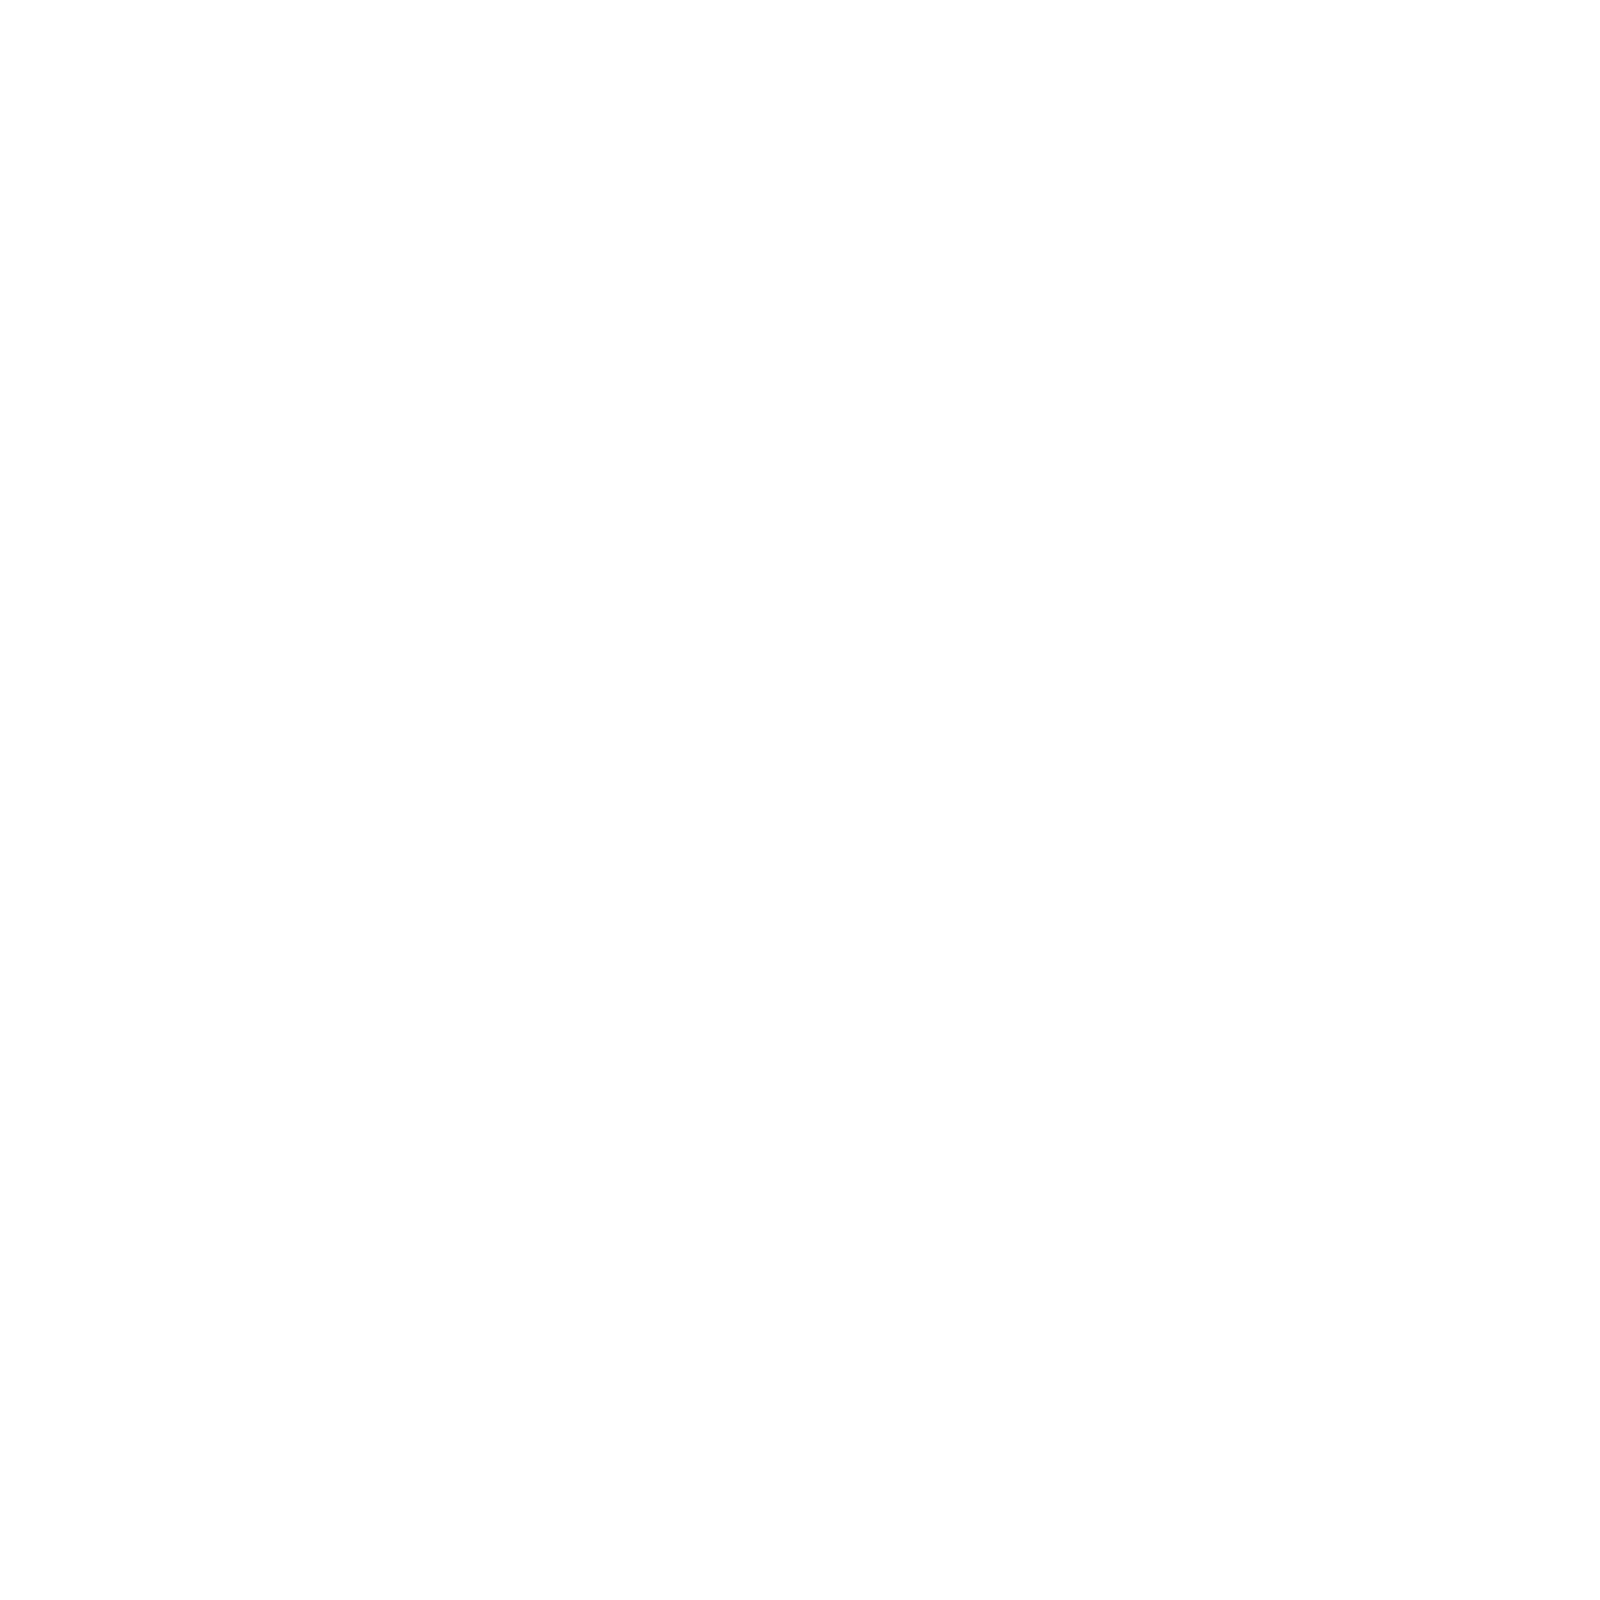

<IPython.core.display.Javascript object>


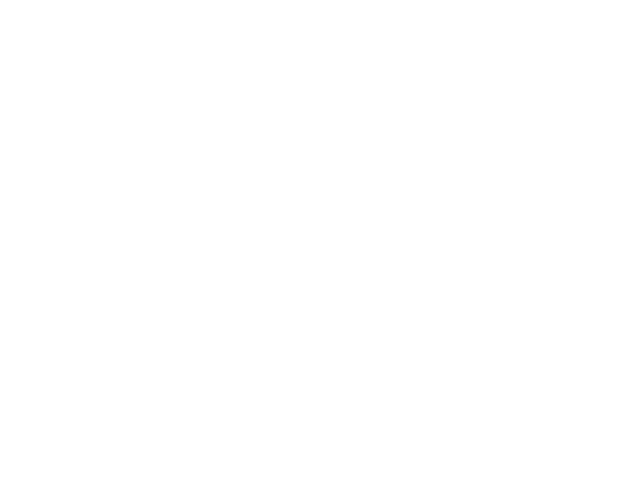

<IPython.core.display.Javascript object>


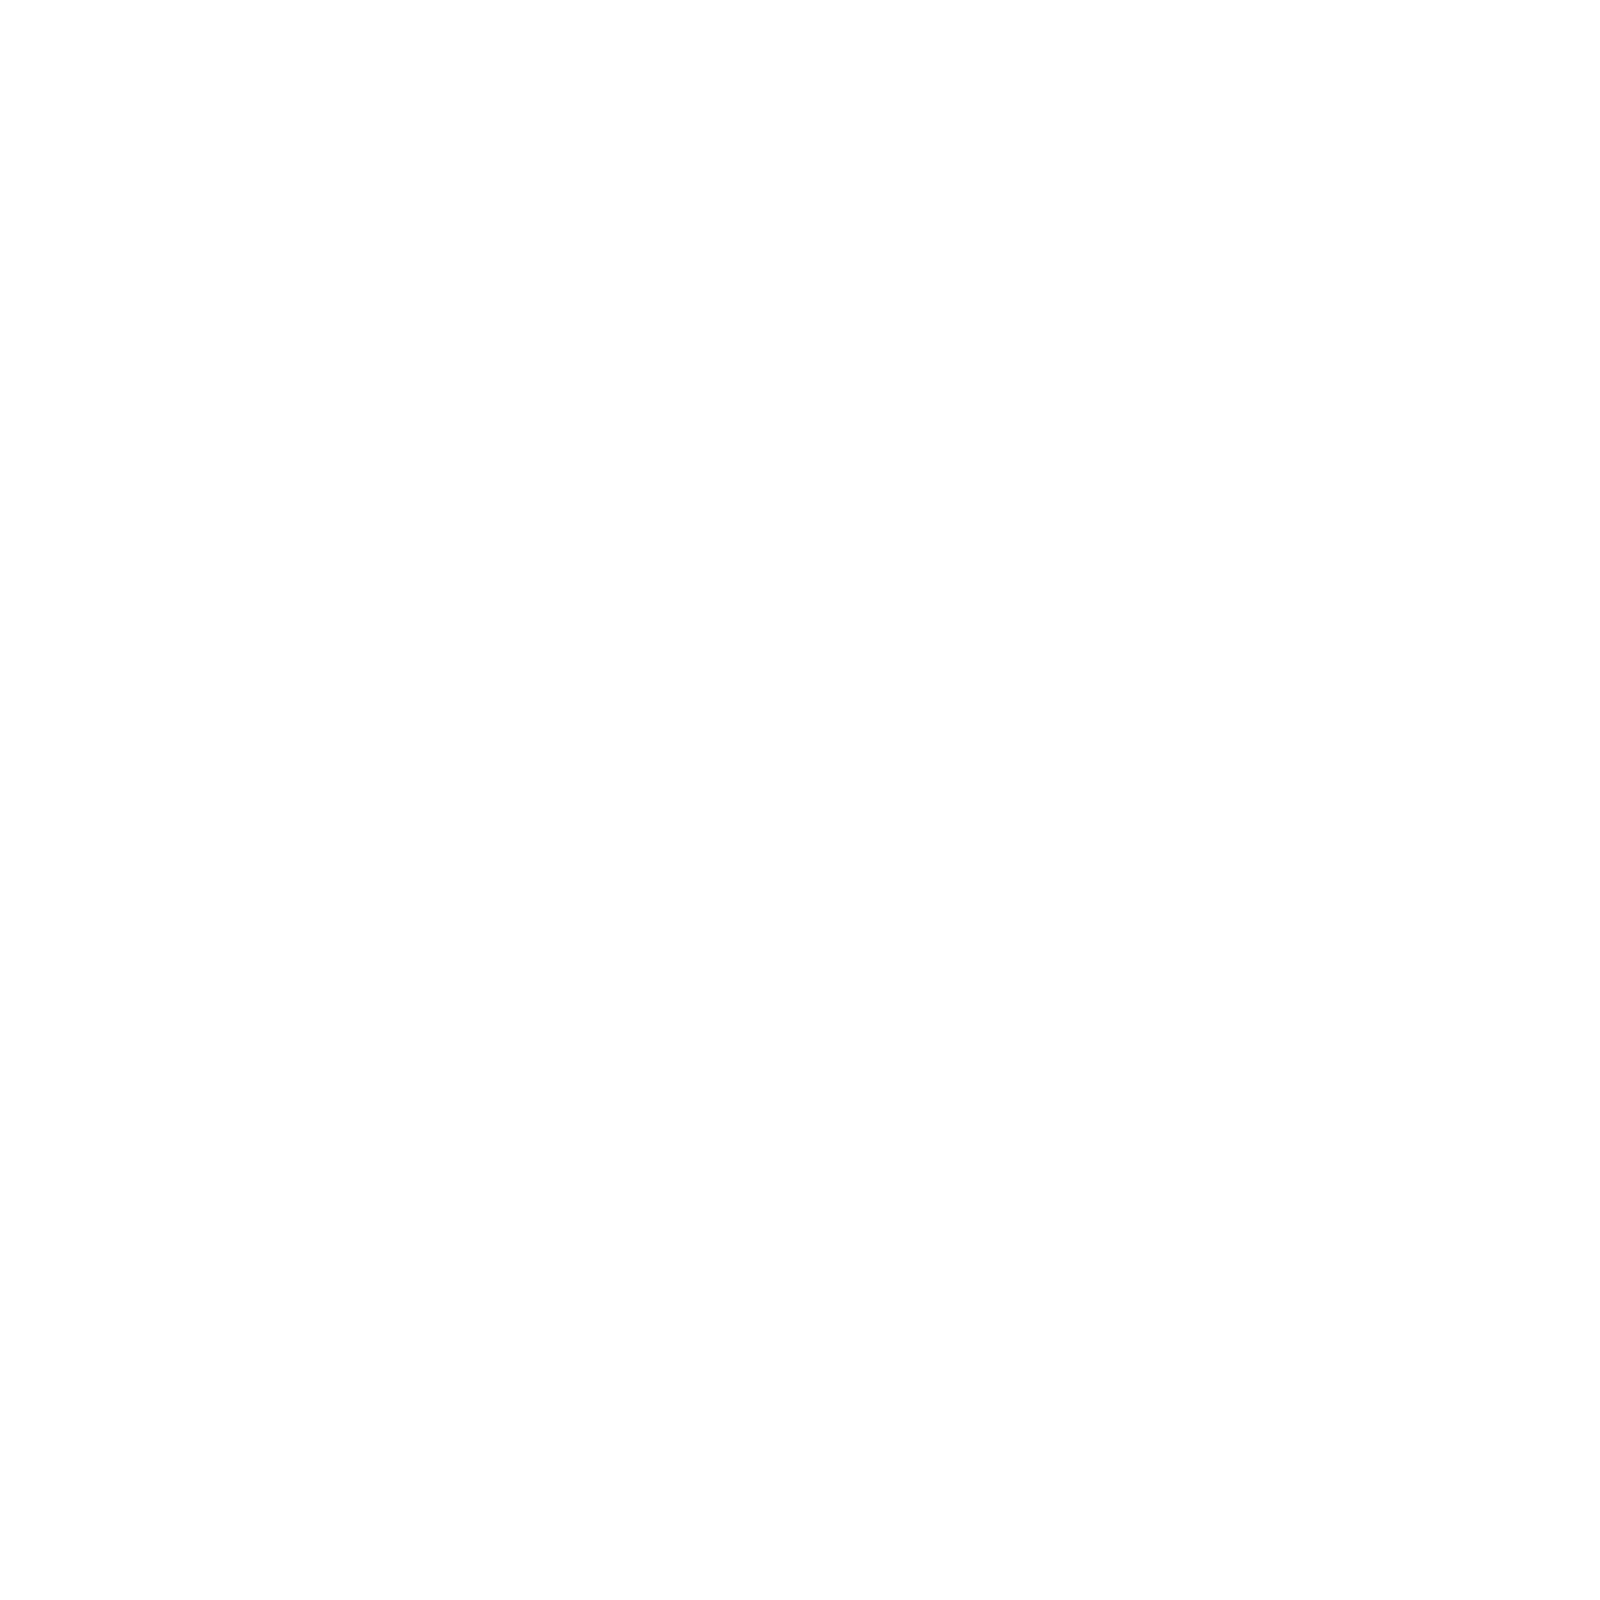

<IPython.core.display.Javascript object>


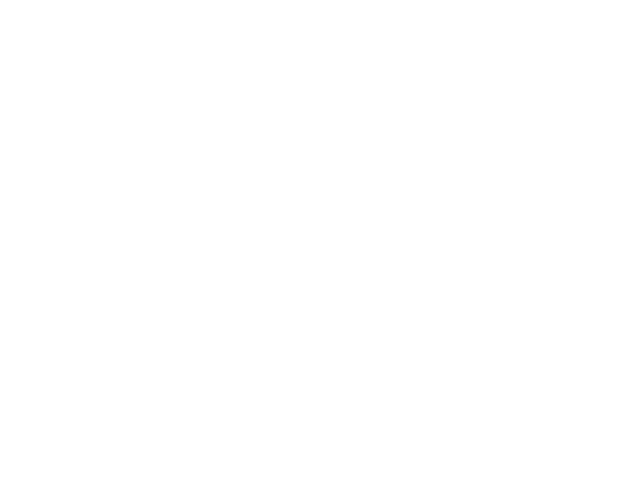

<IPython.core.display.Javascript object>


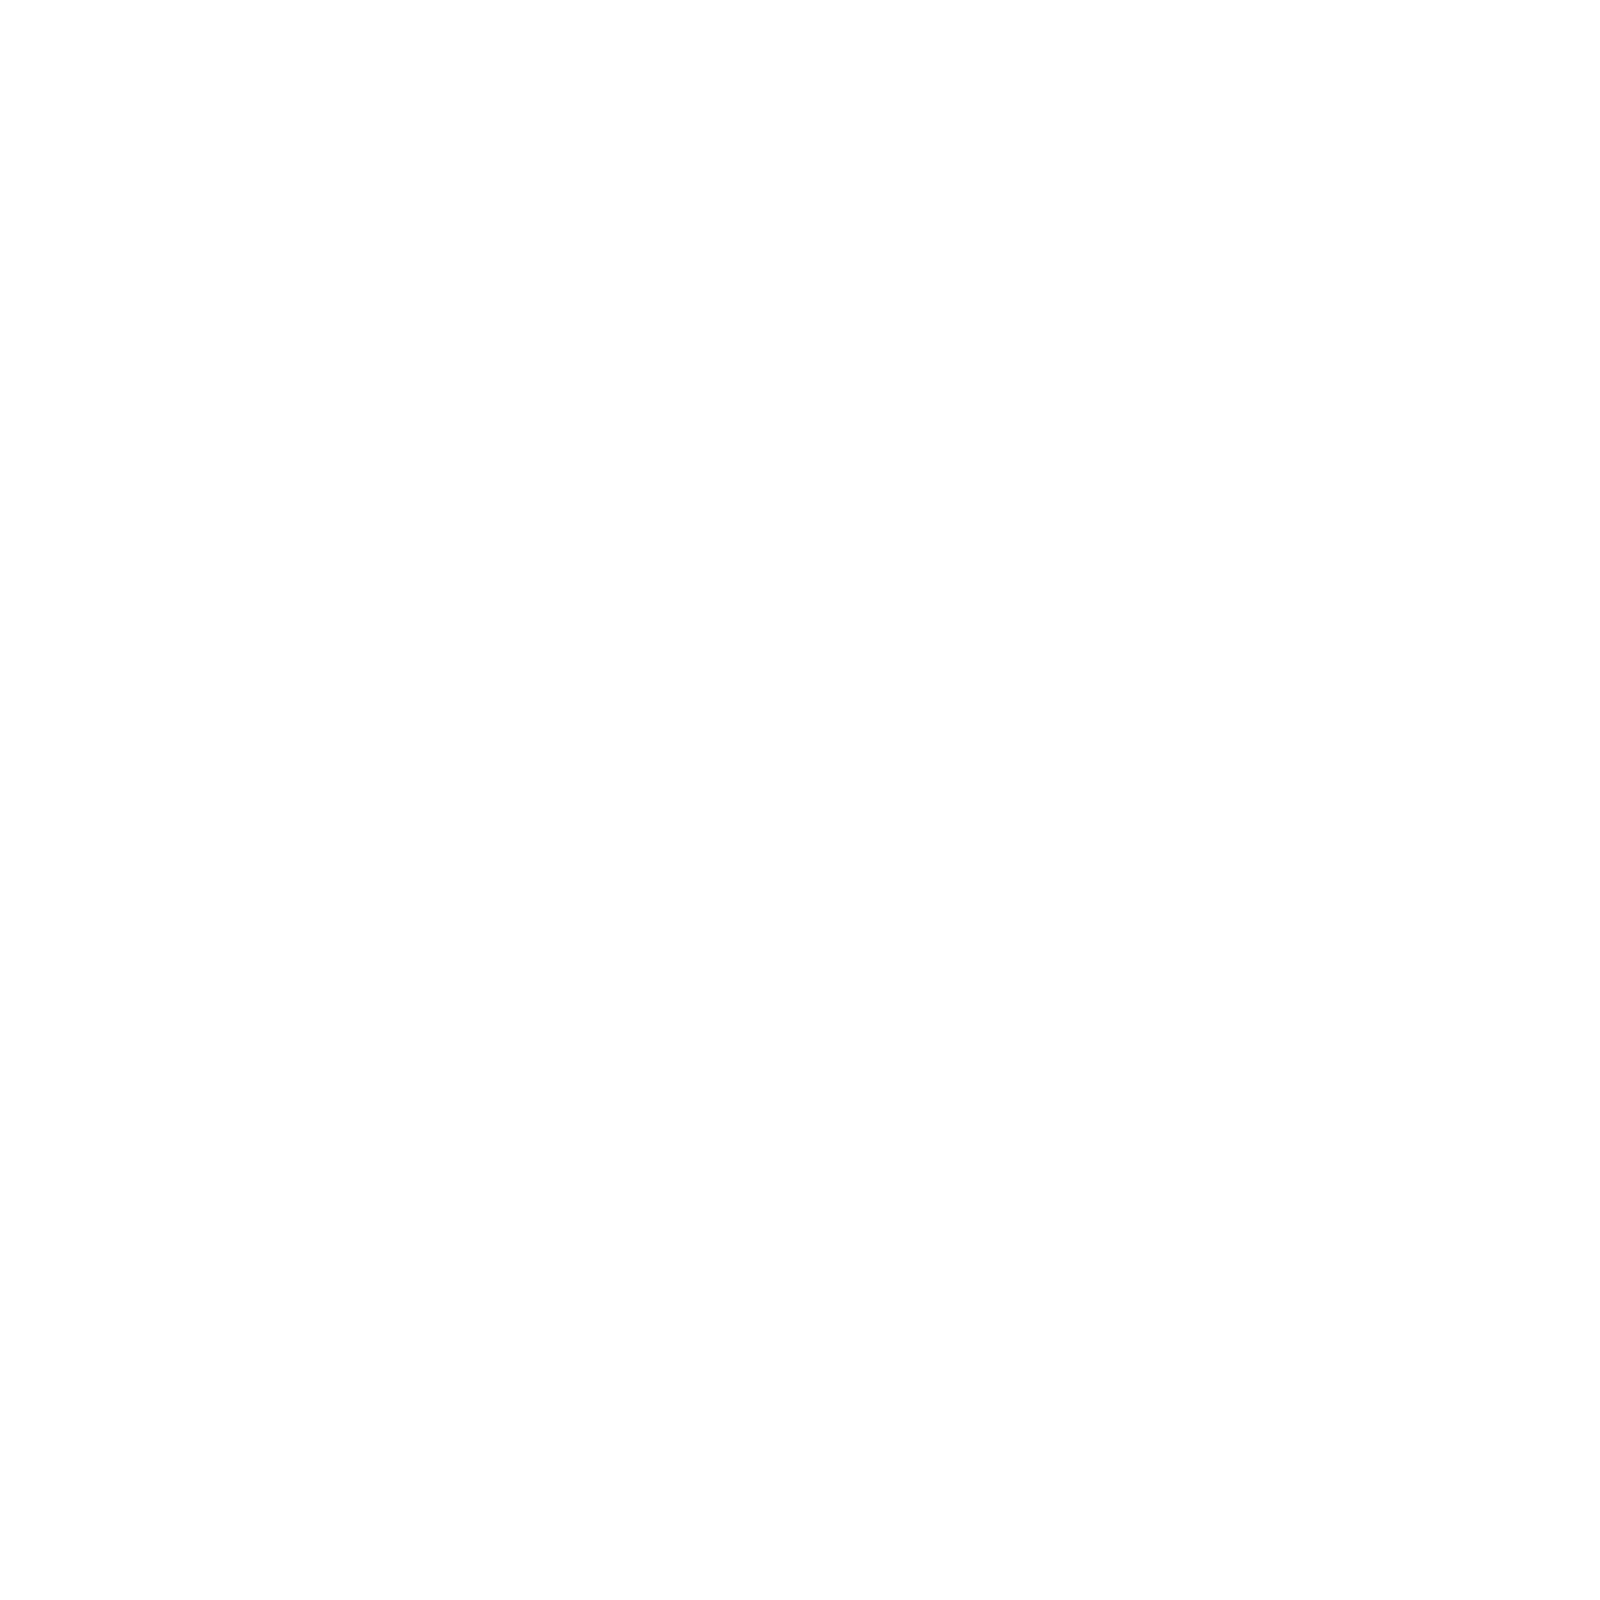

<IPython.core.display.Javascript object>


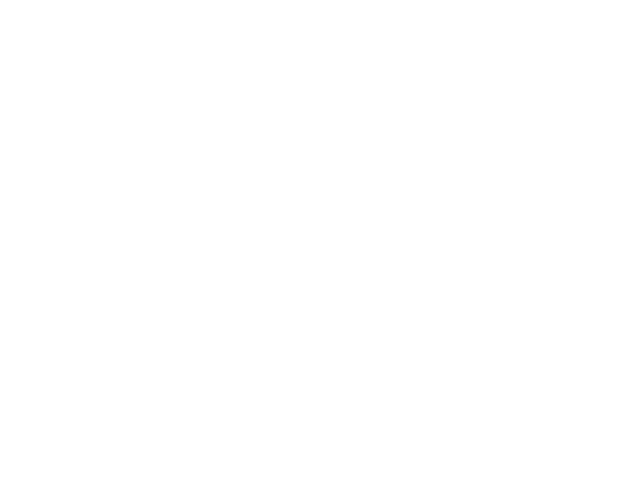

<IPython.core.display.Javascript object>


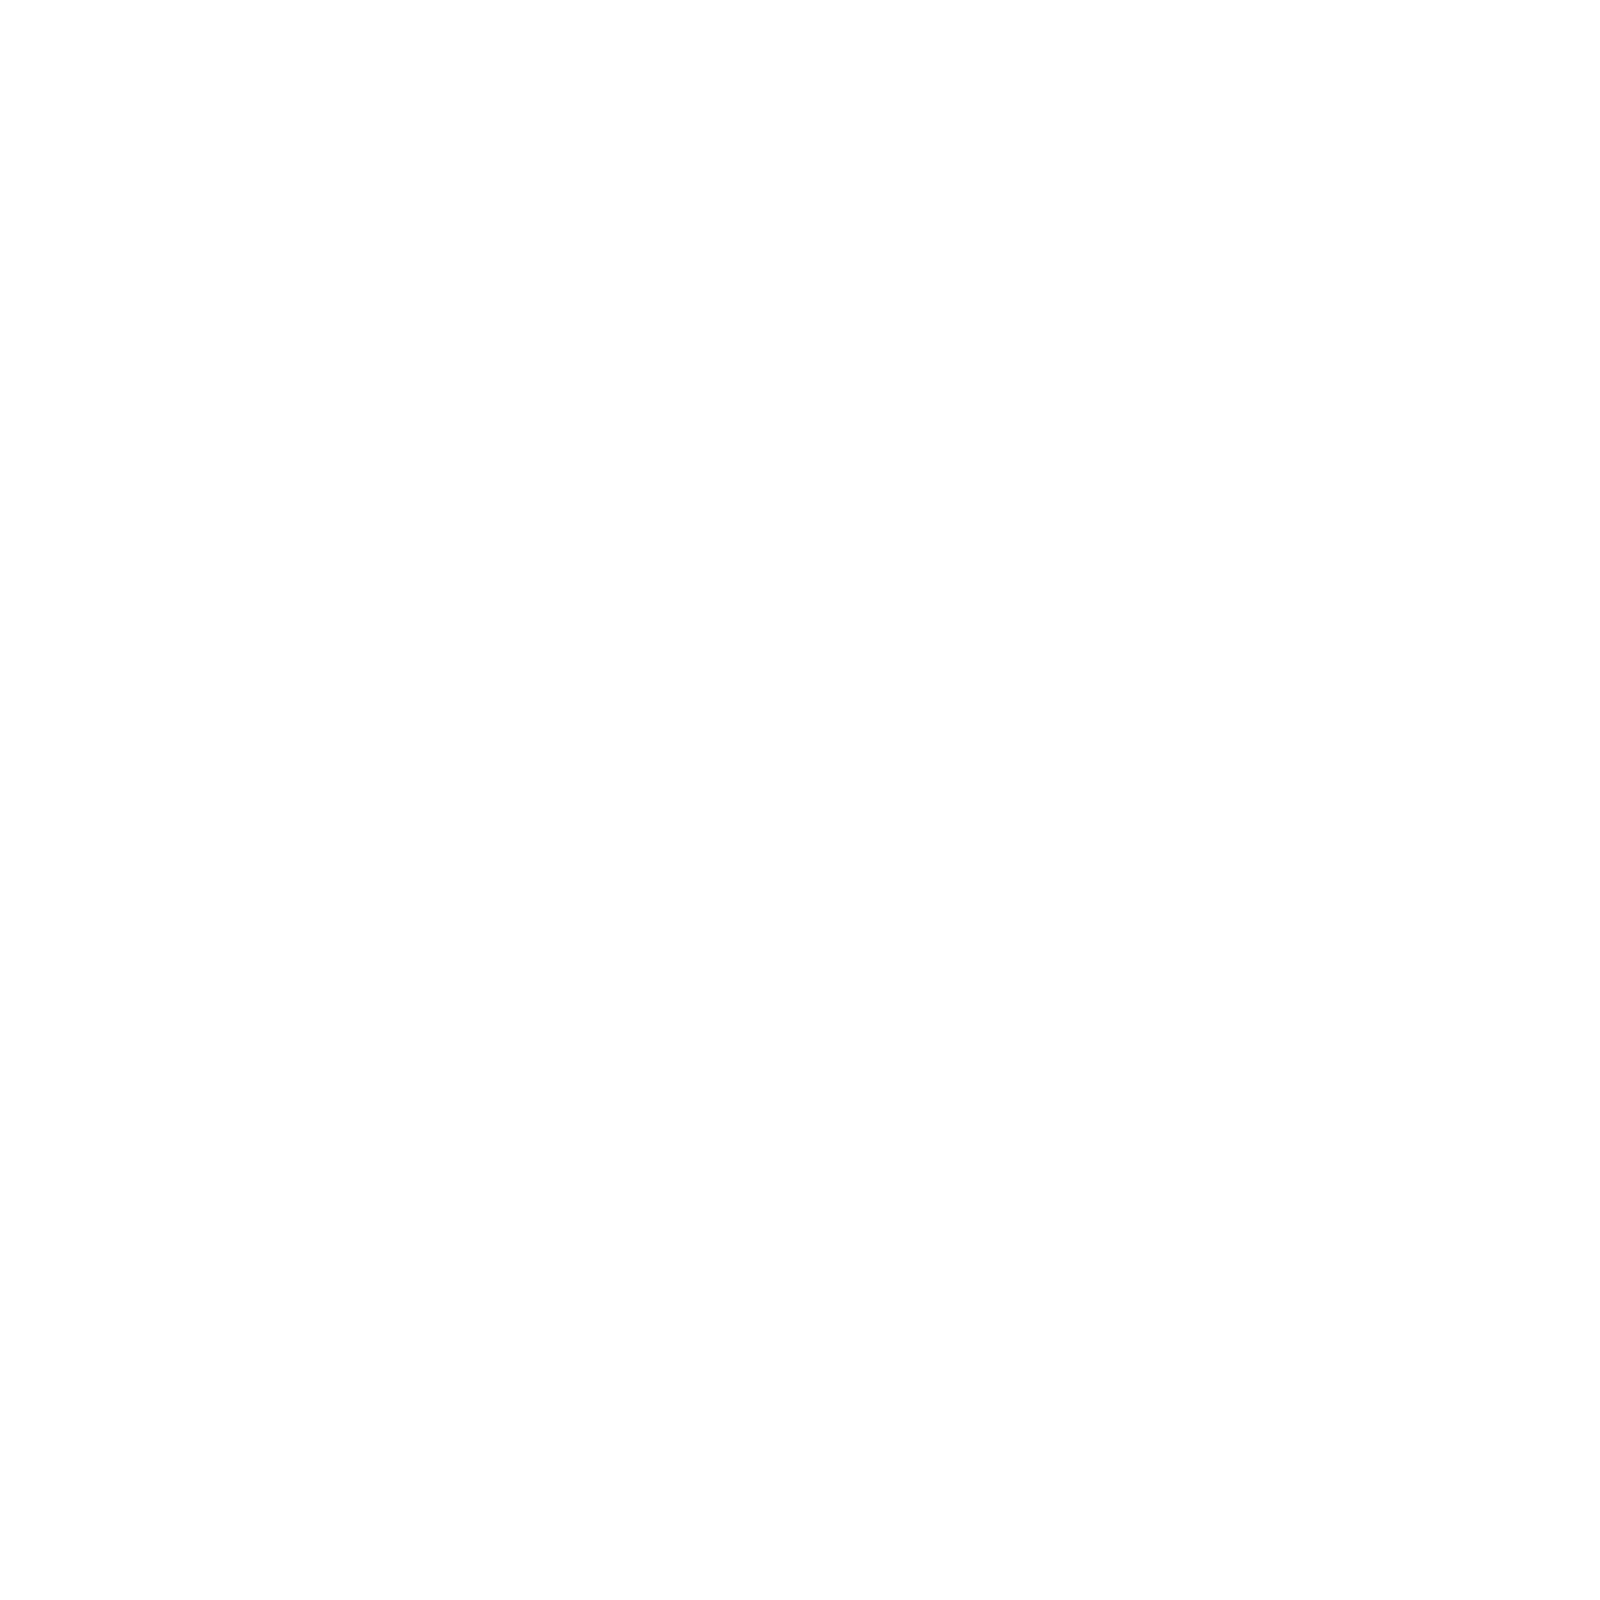

<IPython.core.display.Javascript object>


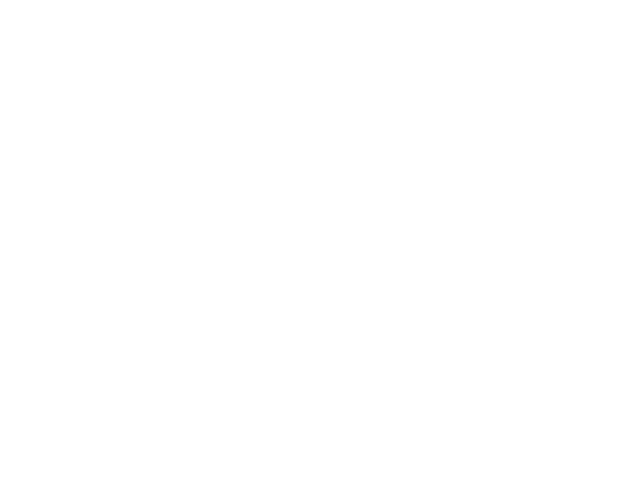

<IPython.core.display.Javascript object>


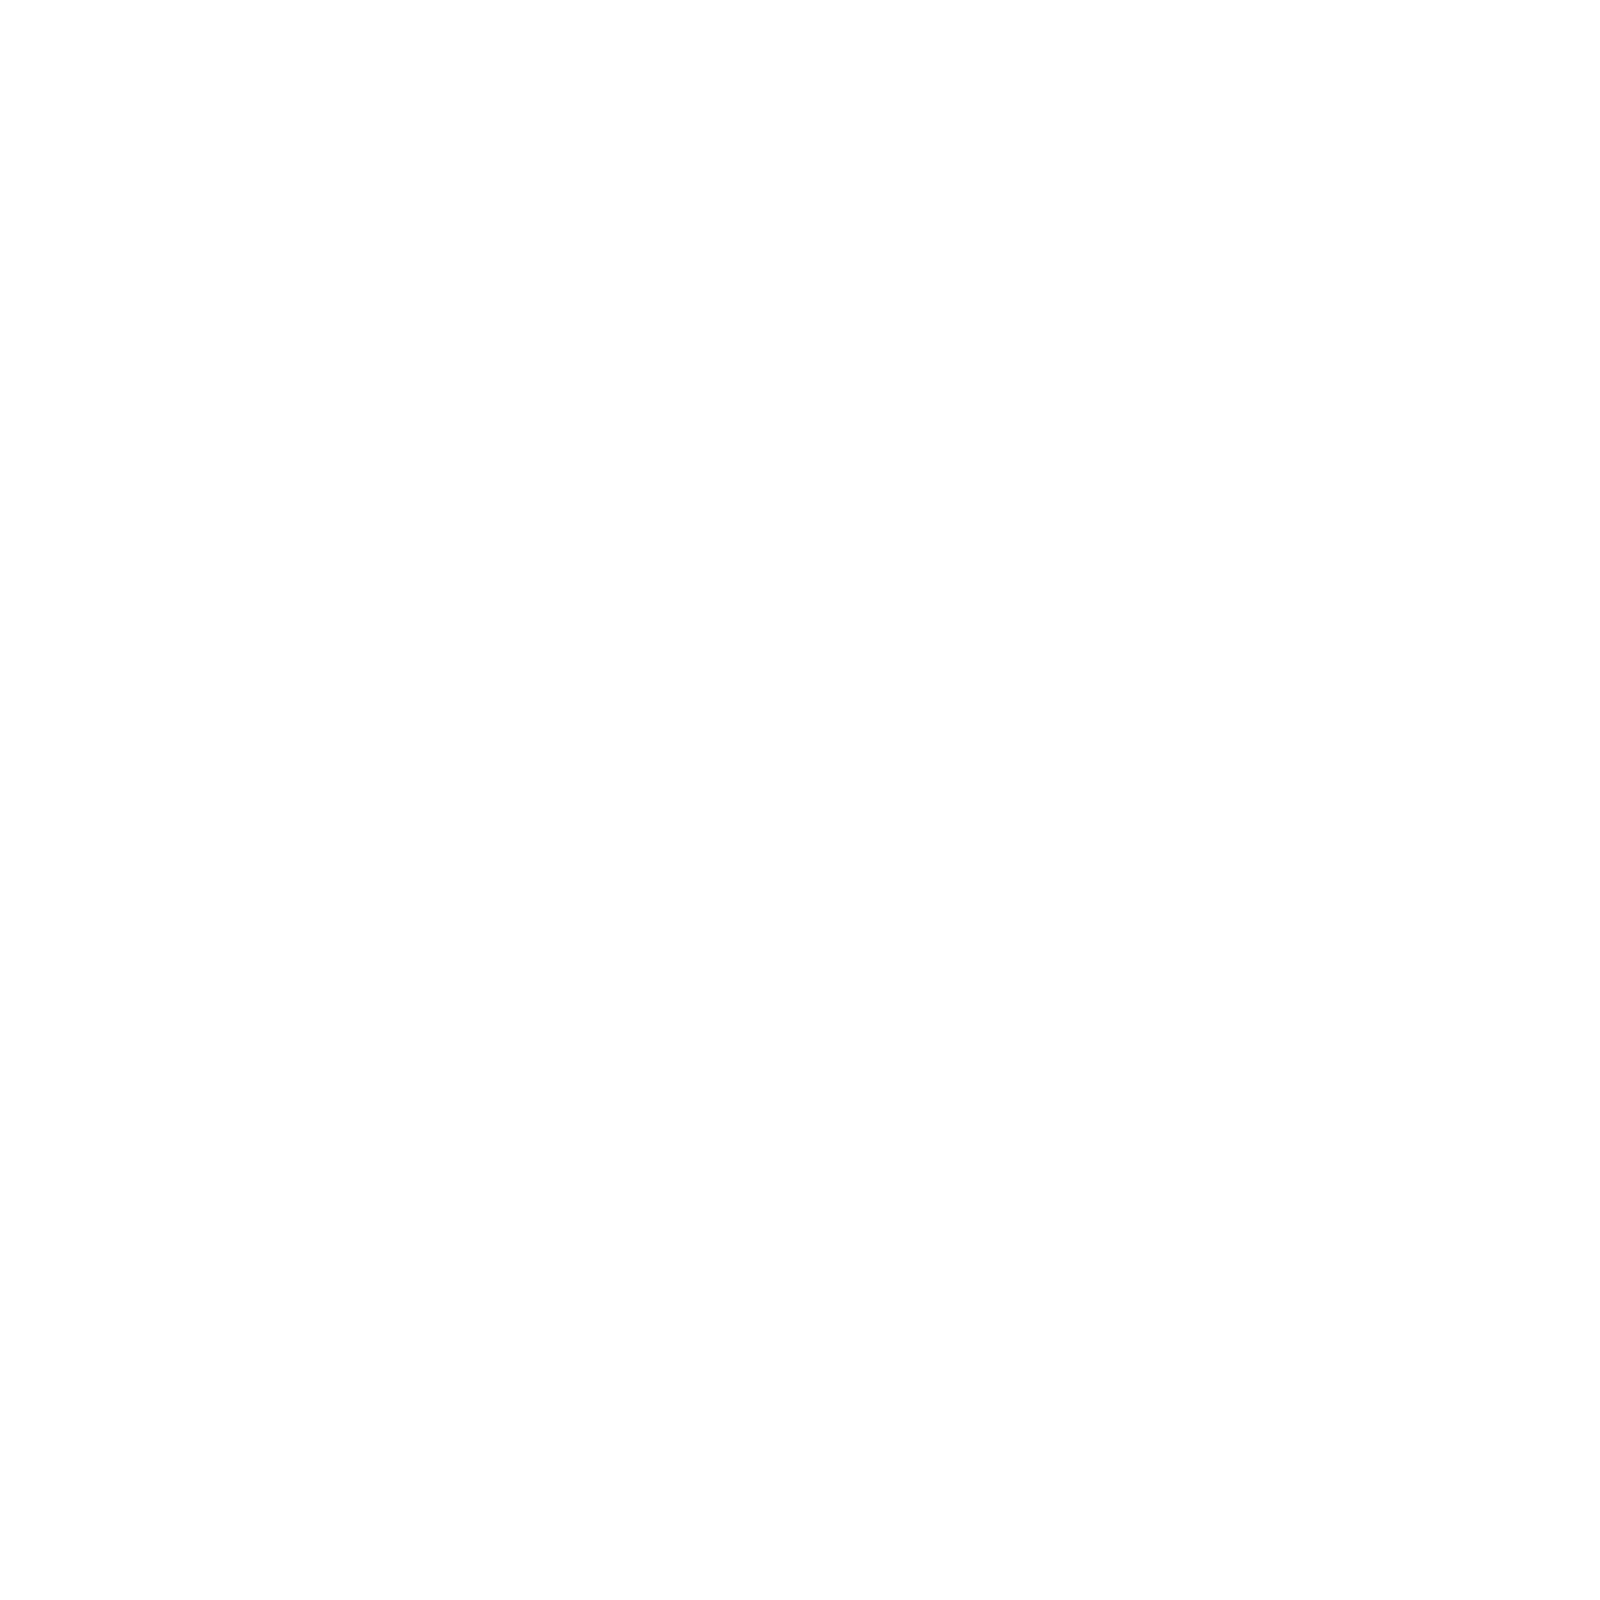

<IPython.core.display.Javascript object>


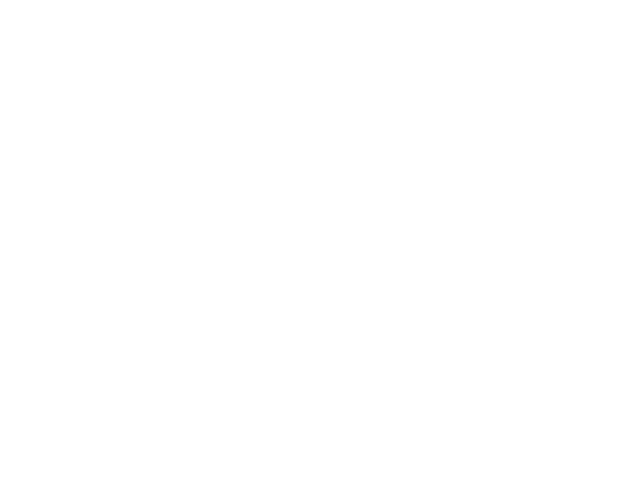

<IPython.core.display.Javascript object>


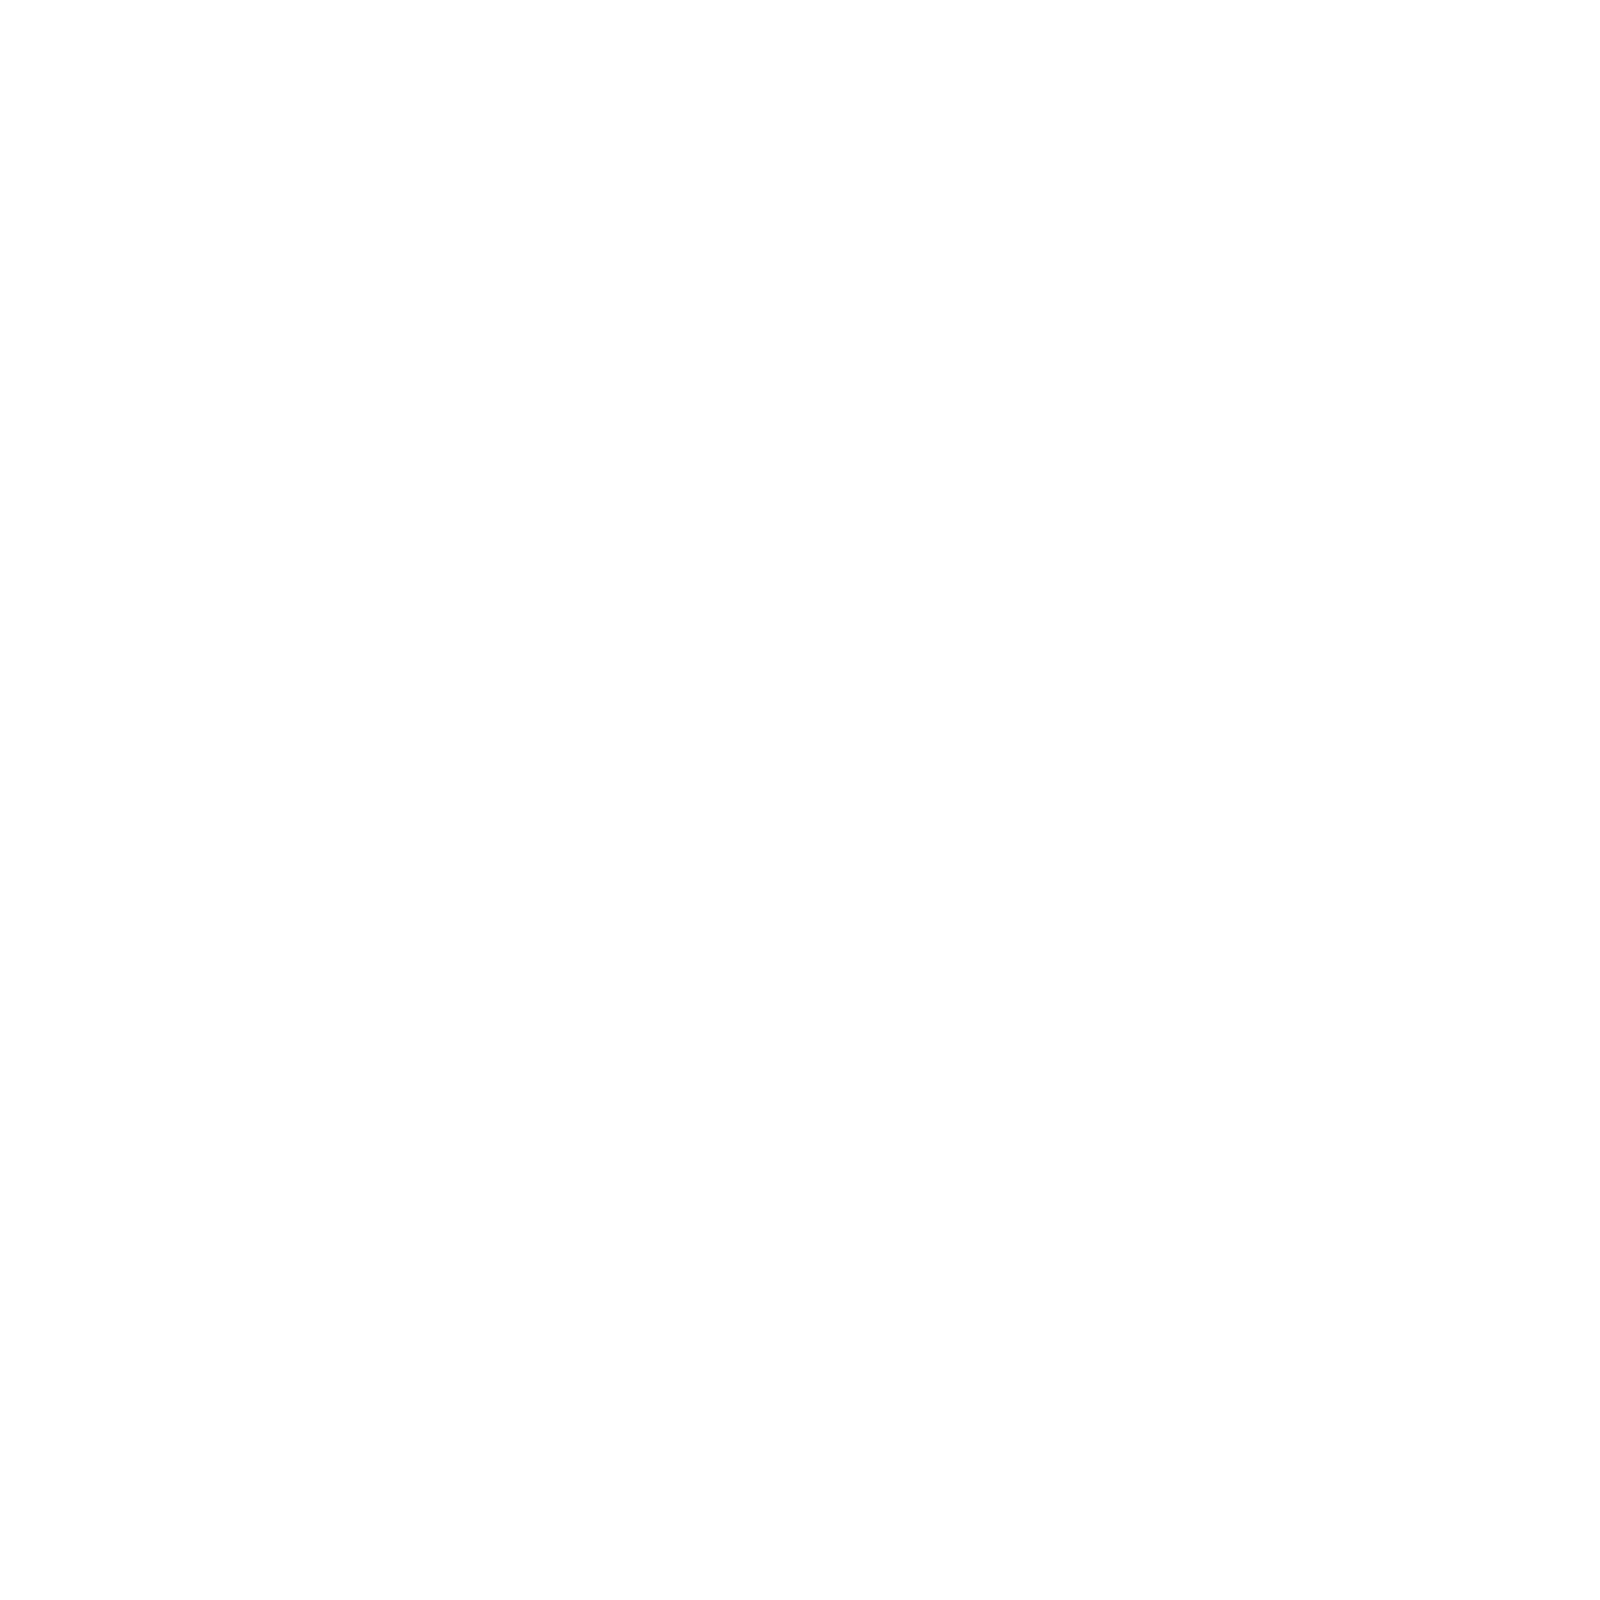

<IPython.core.display.Javascript object>


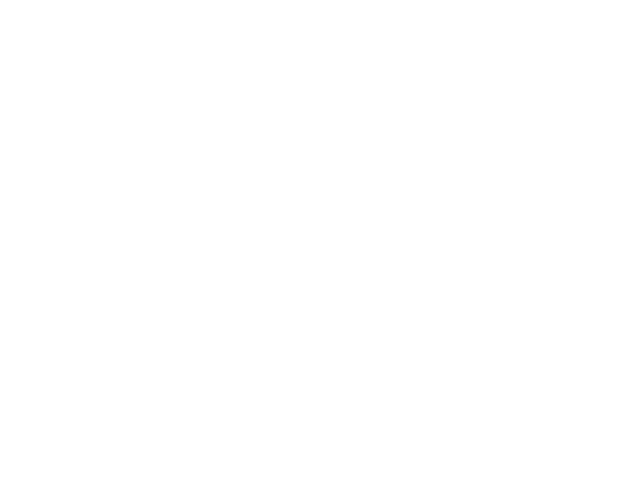

<IPython.core.display.Javascript object>


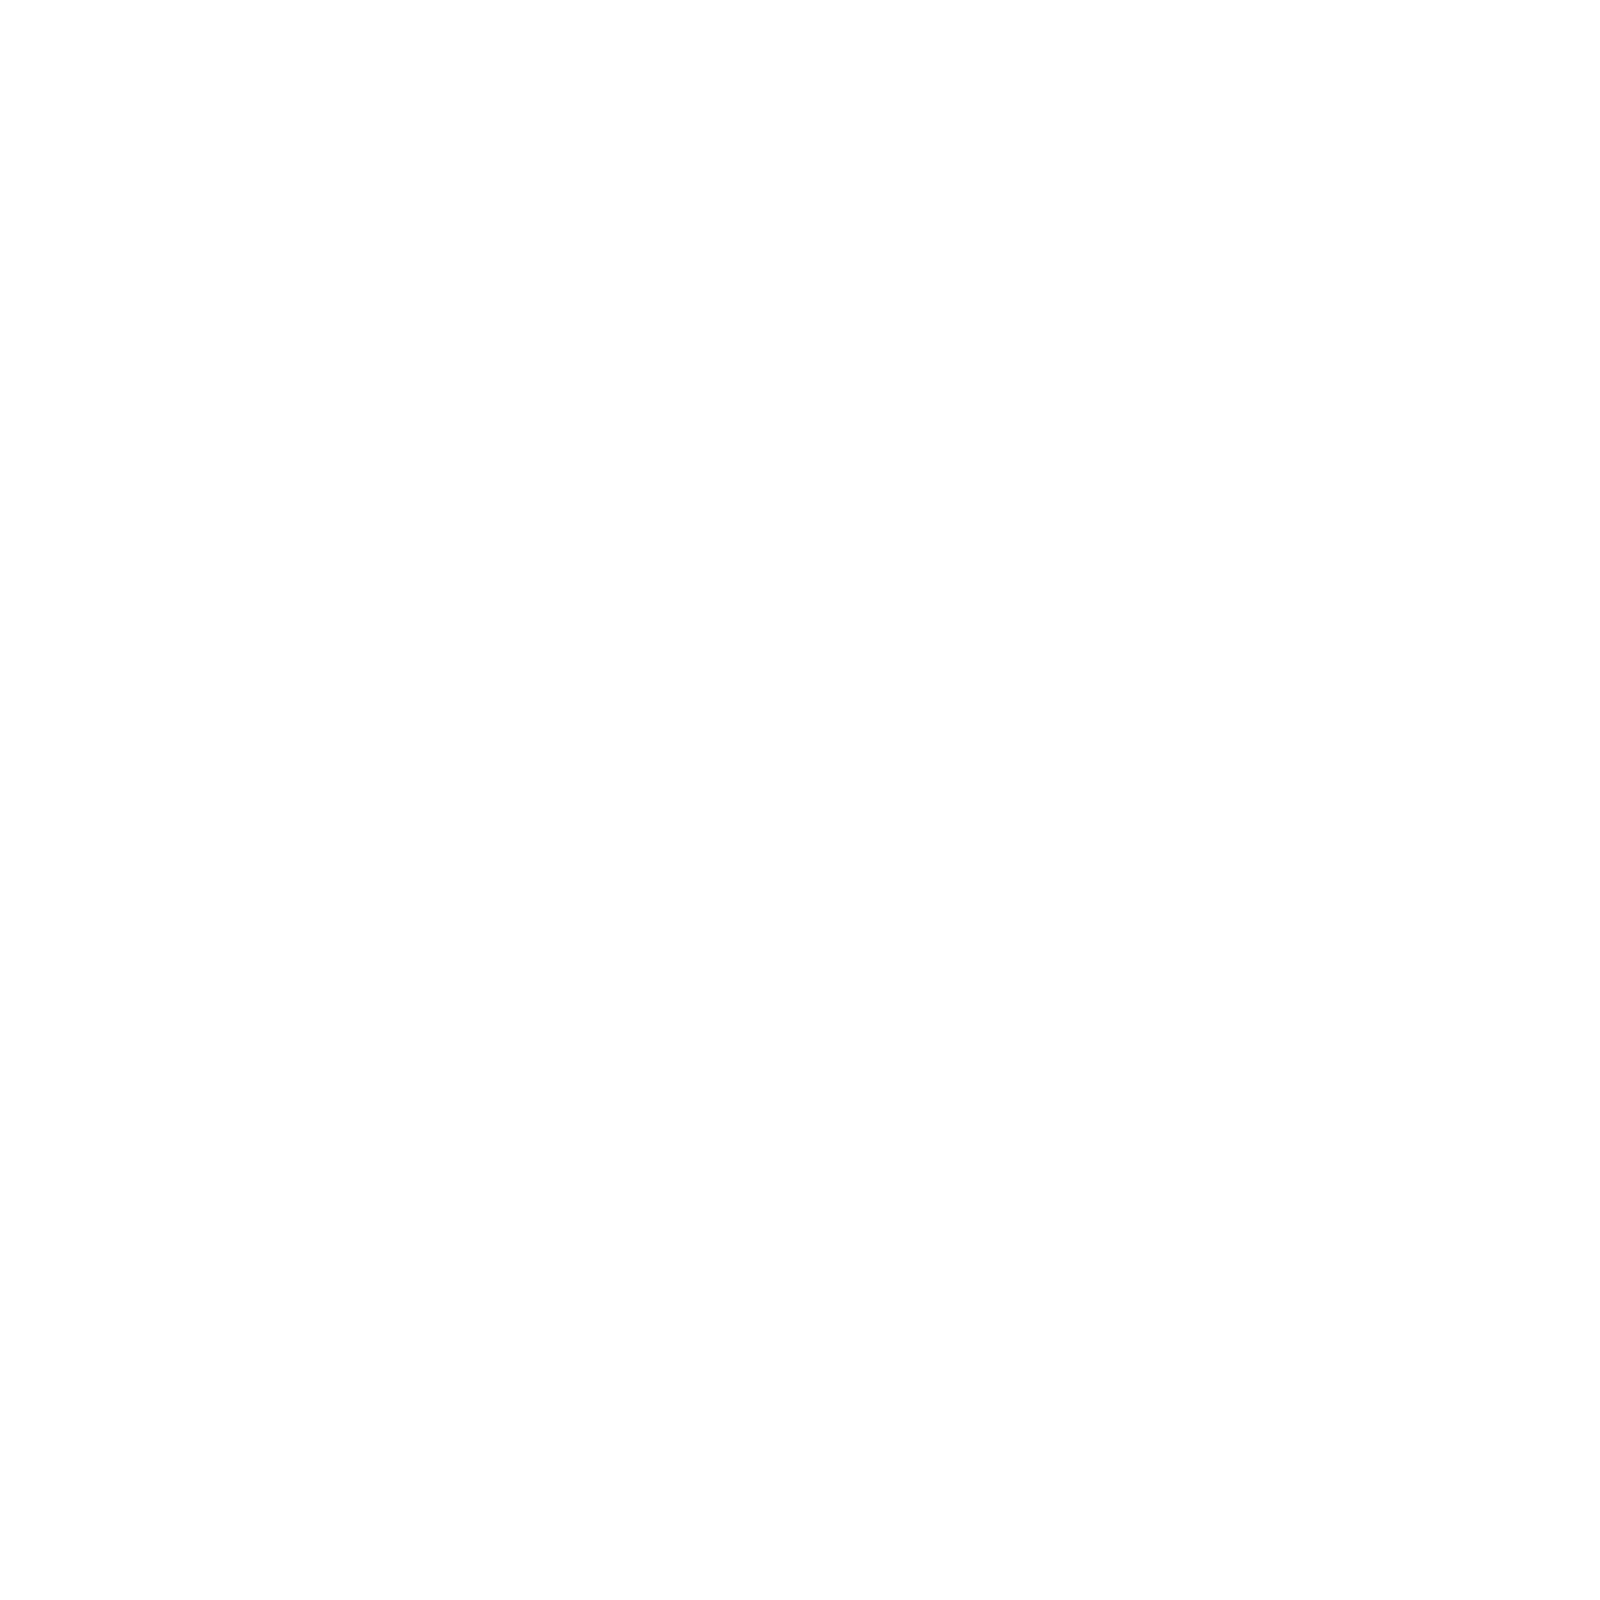

<IPython.core.display.Javascript object>


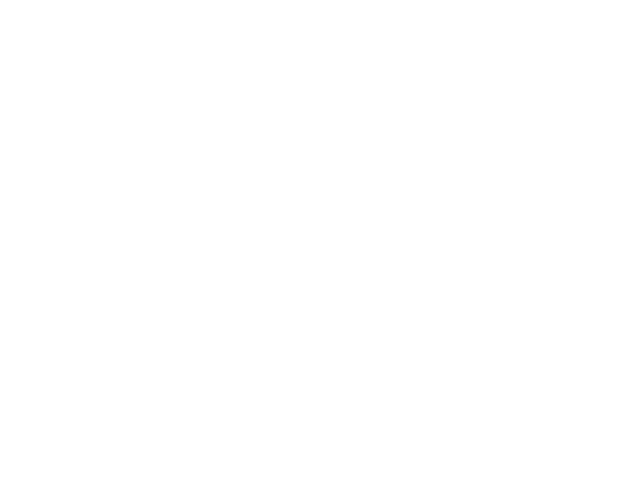

<IPython.core.display.Javascript object>


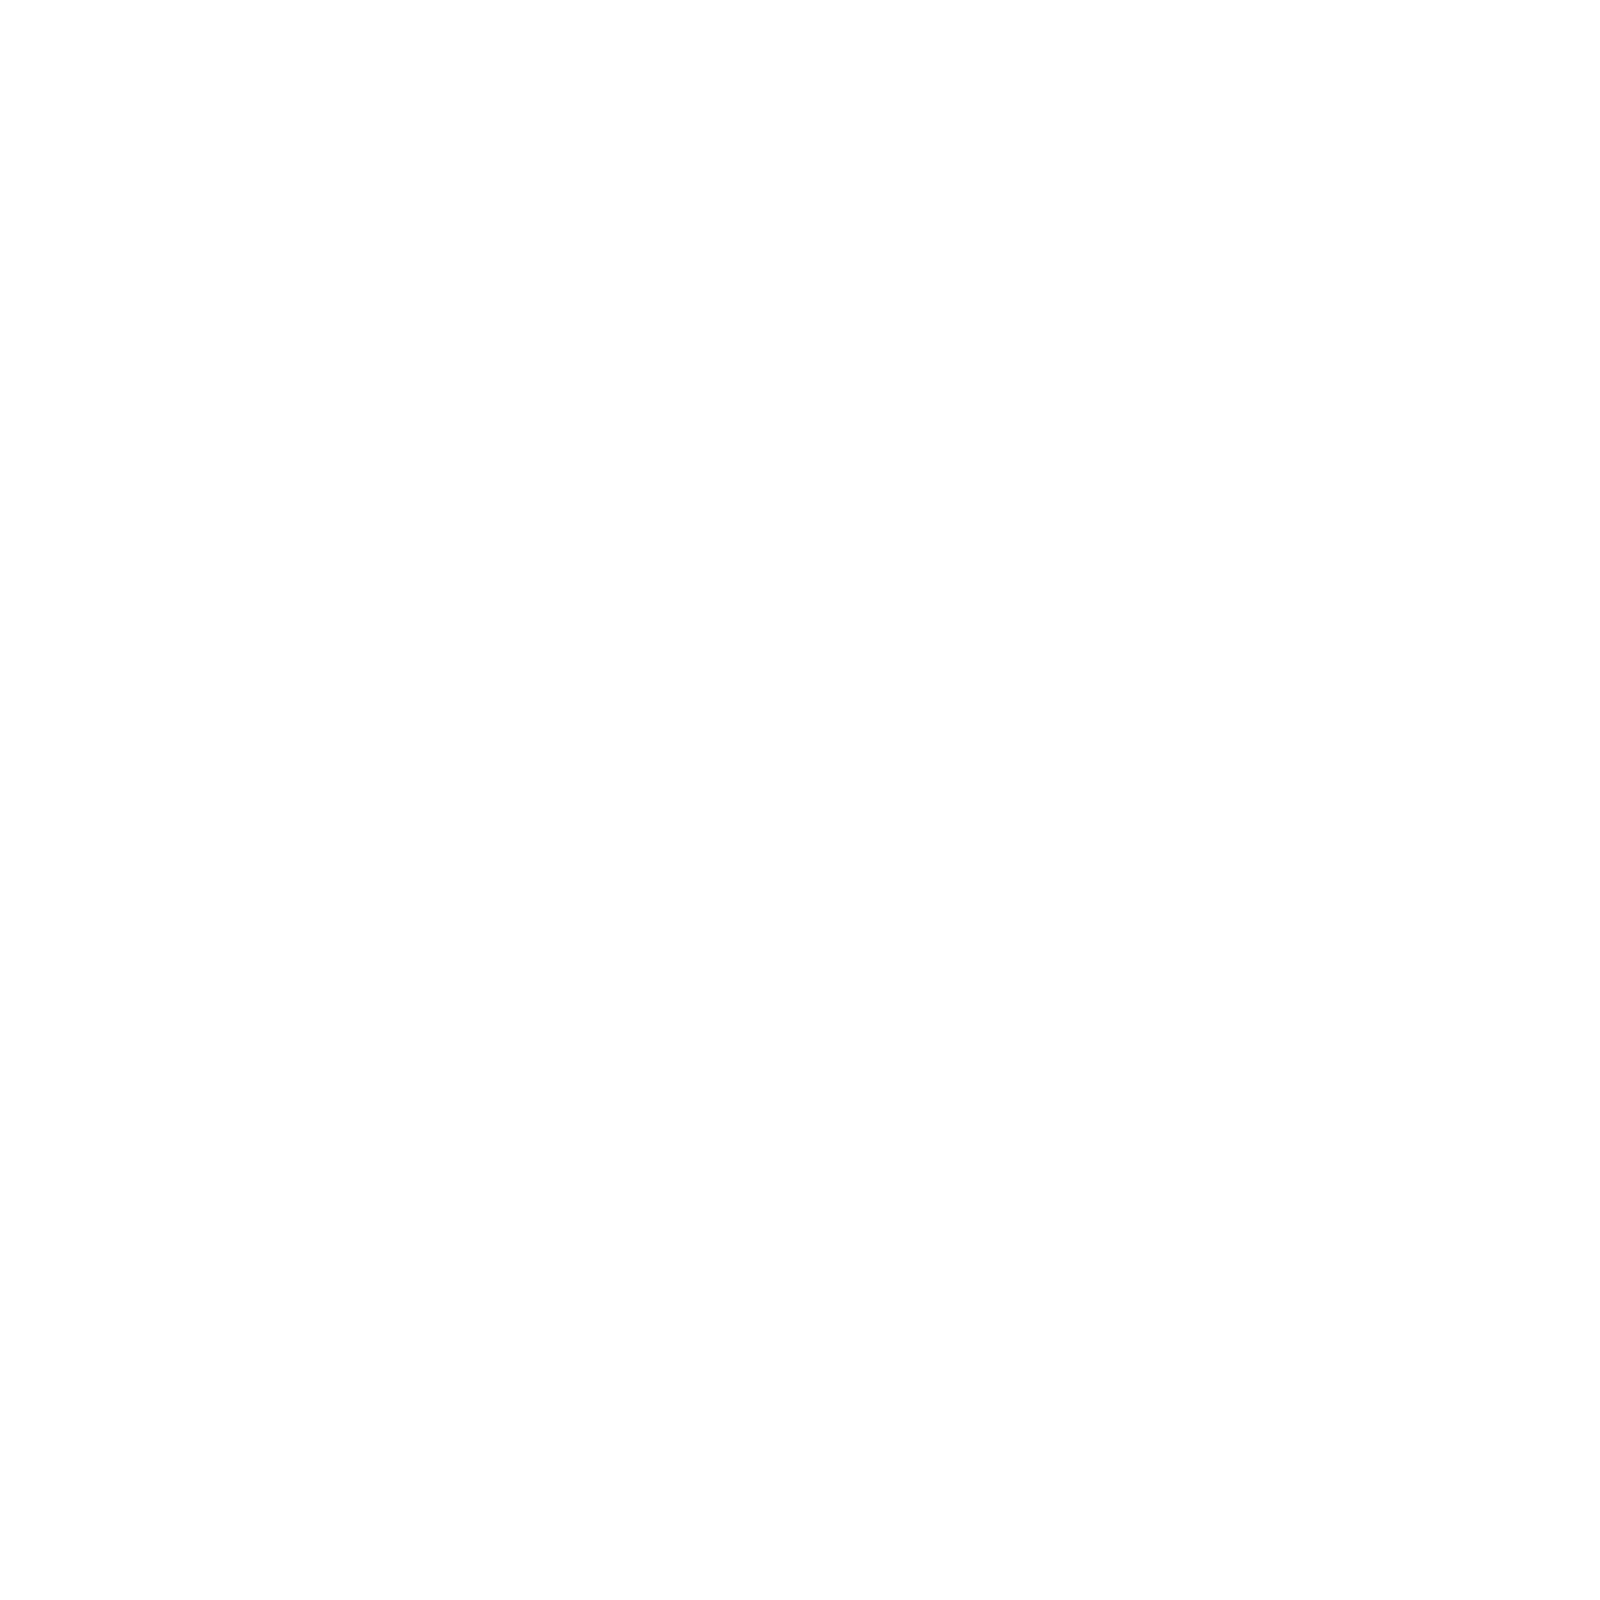

<IPython.core.display.Javascript object>


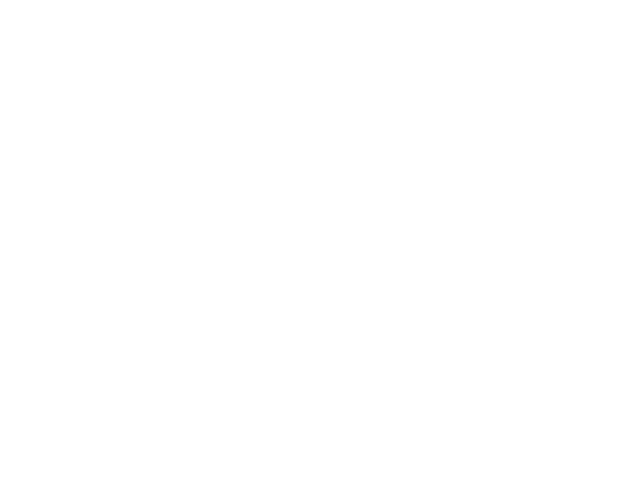

<IPython.core.display.Javascript object>


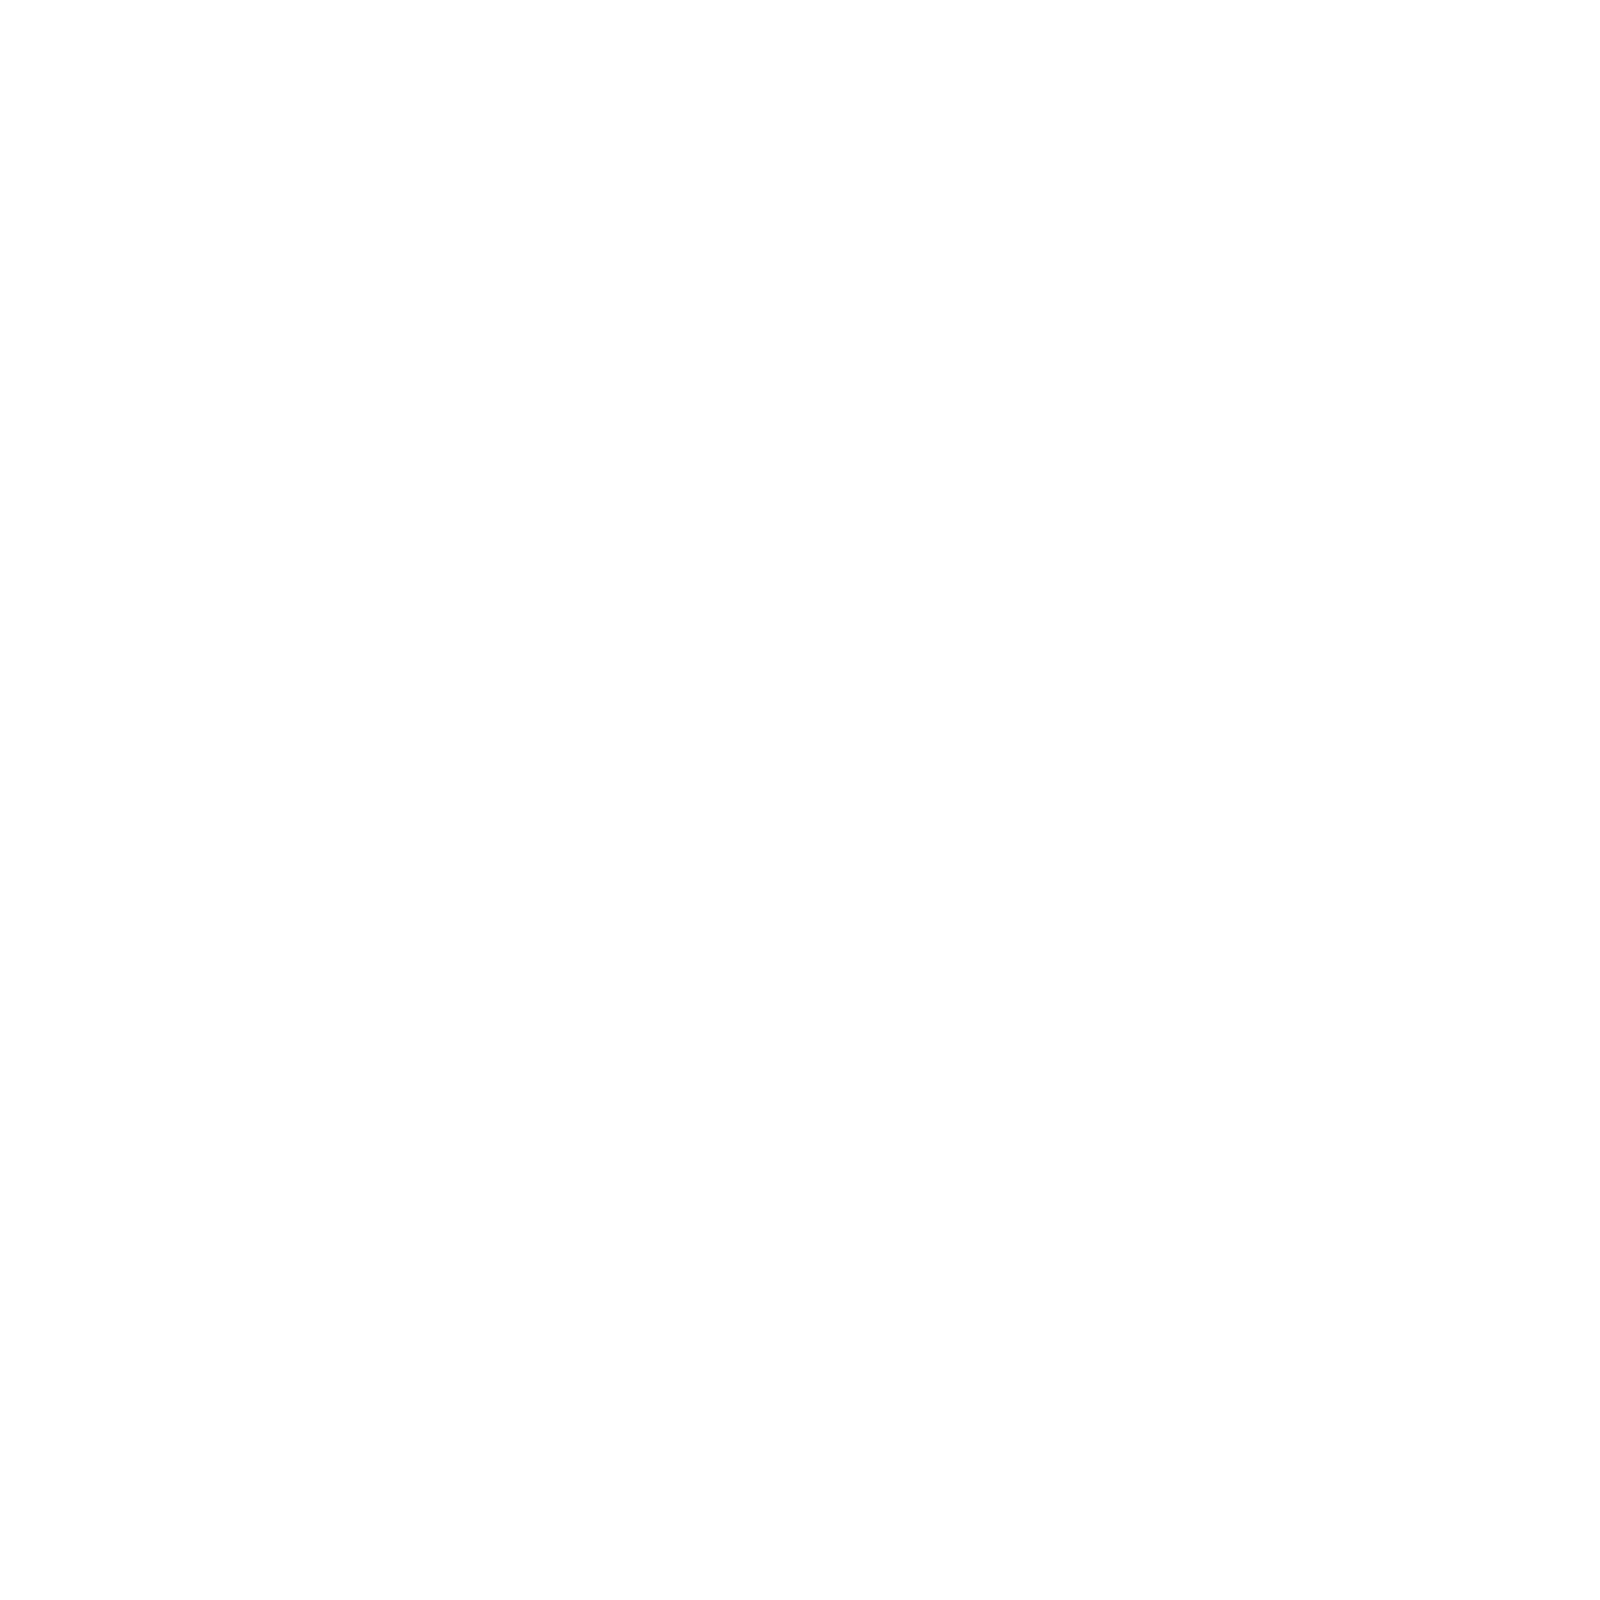

<IPython.core.display.Javascript object>


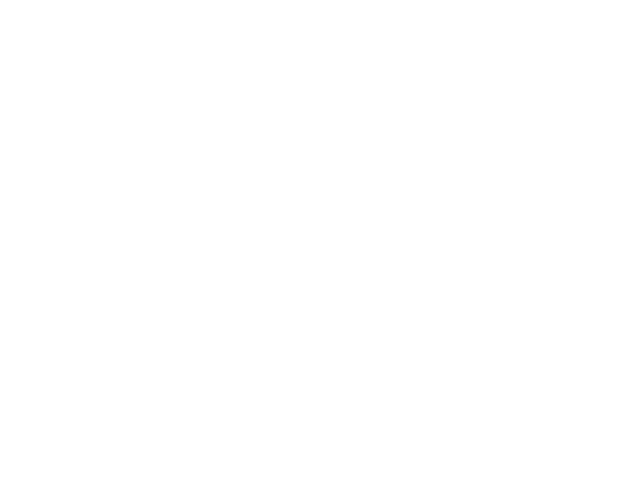

<IPython.core.display.Javascript object>


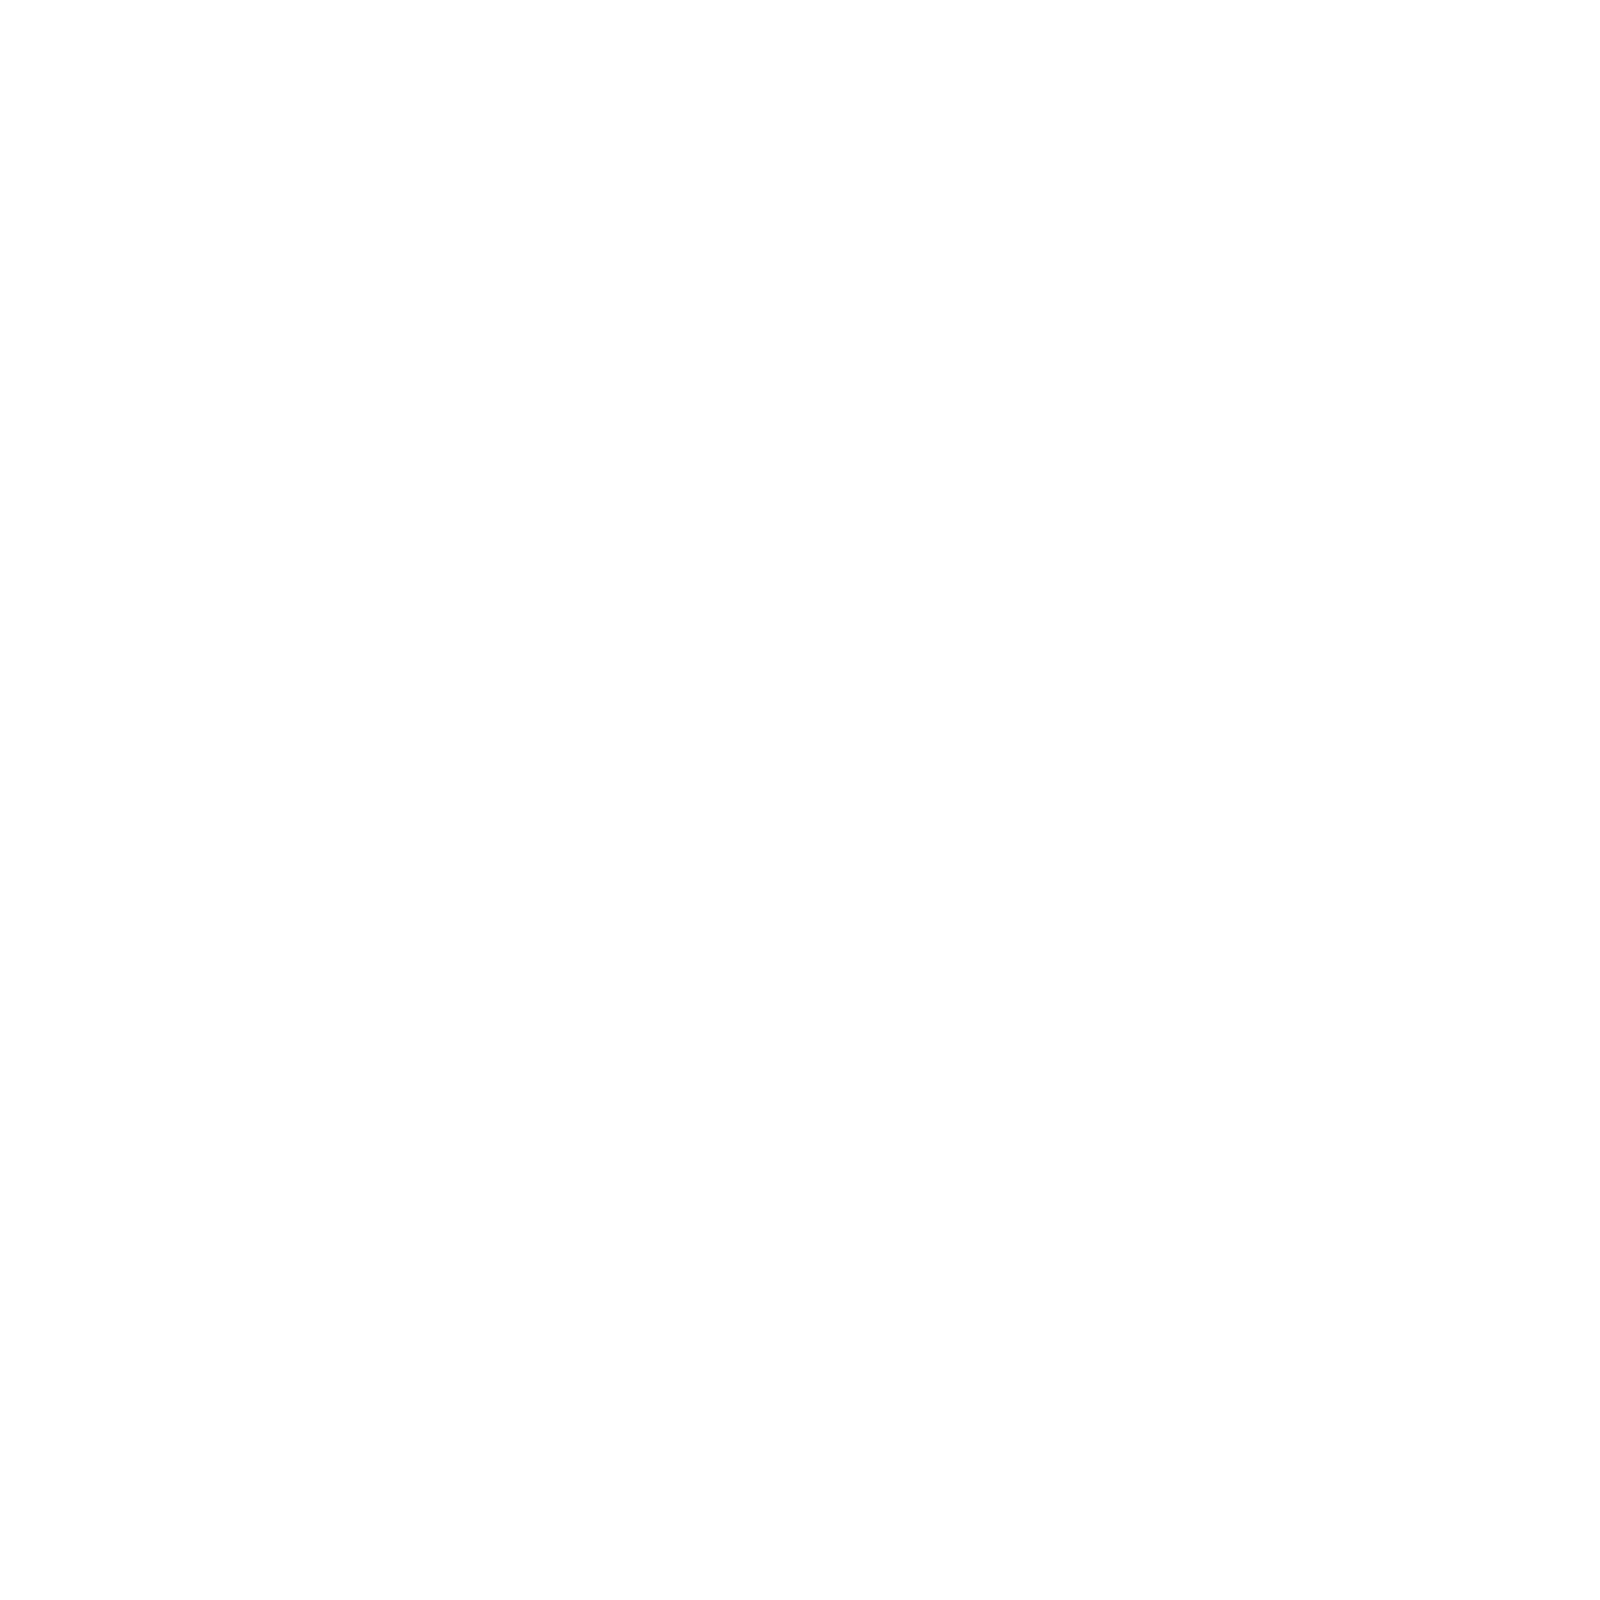

<IPython.core.display.Javascript object>


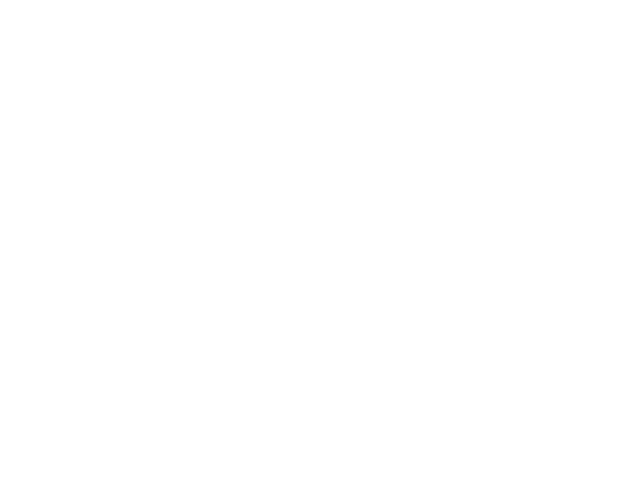

<IPython.core.display.Javascript object>


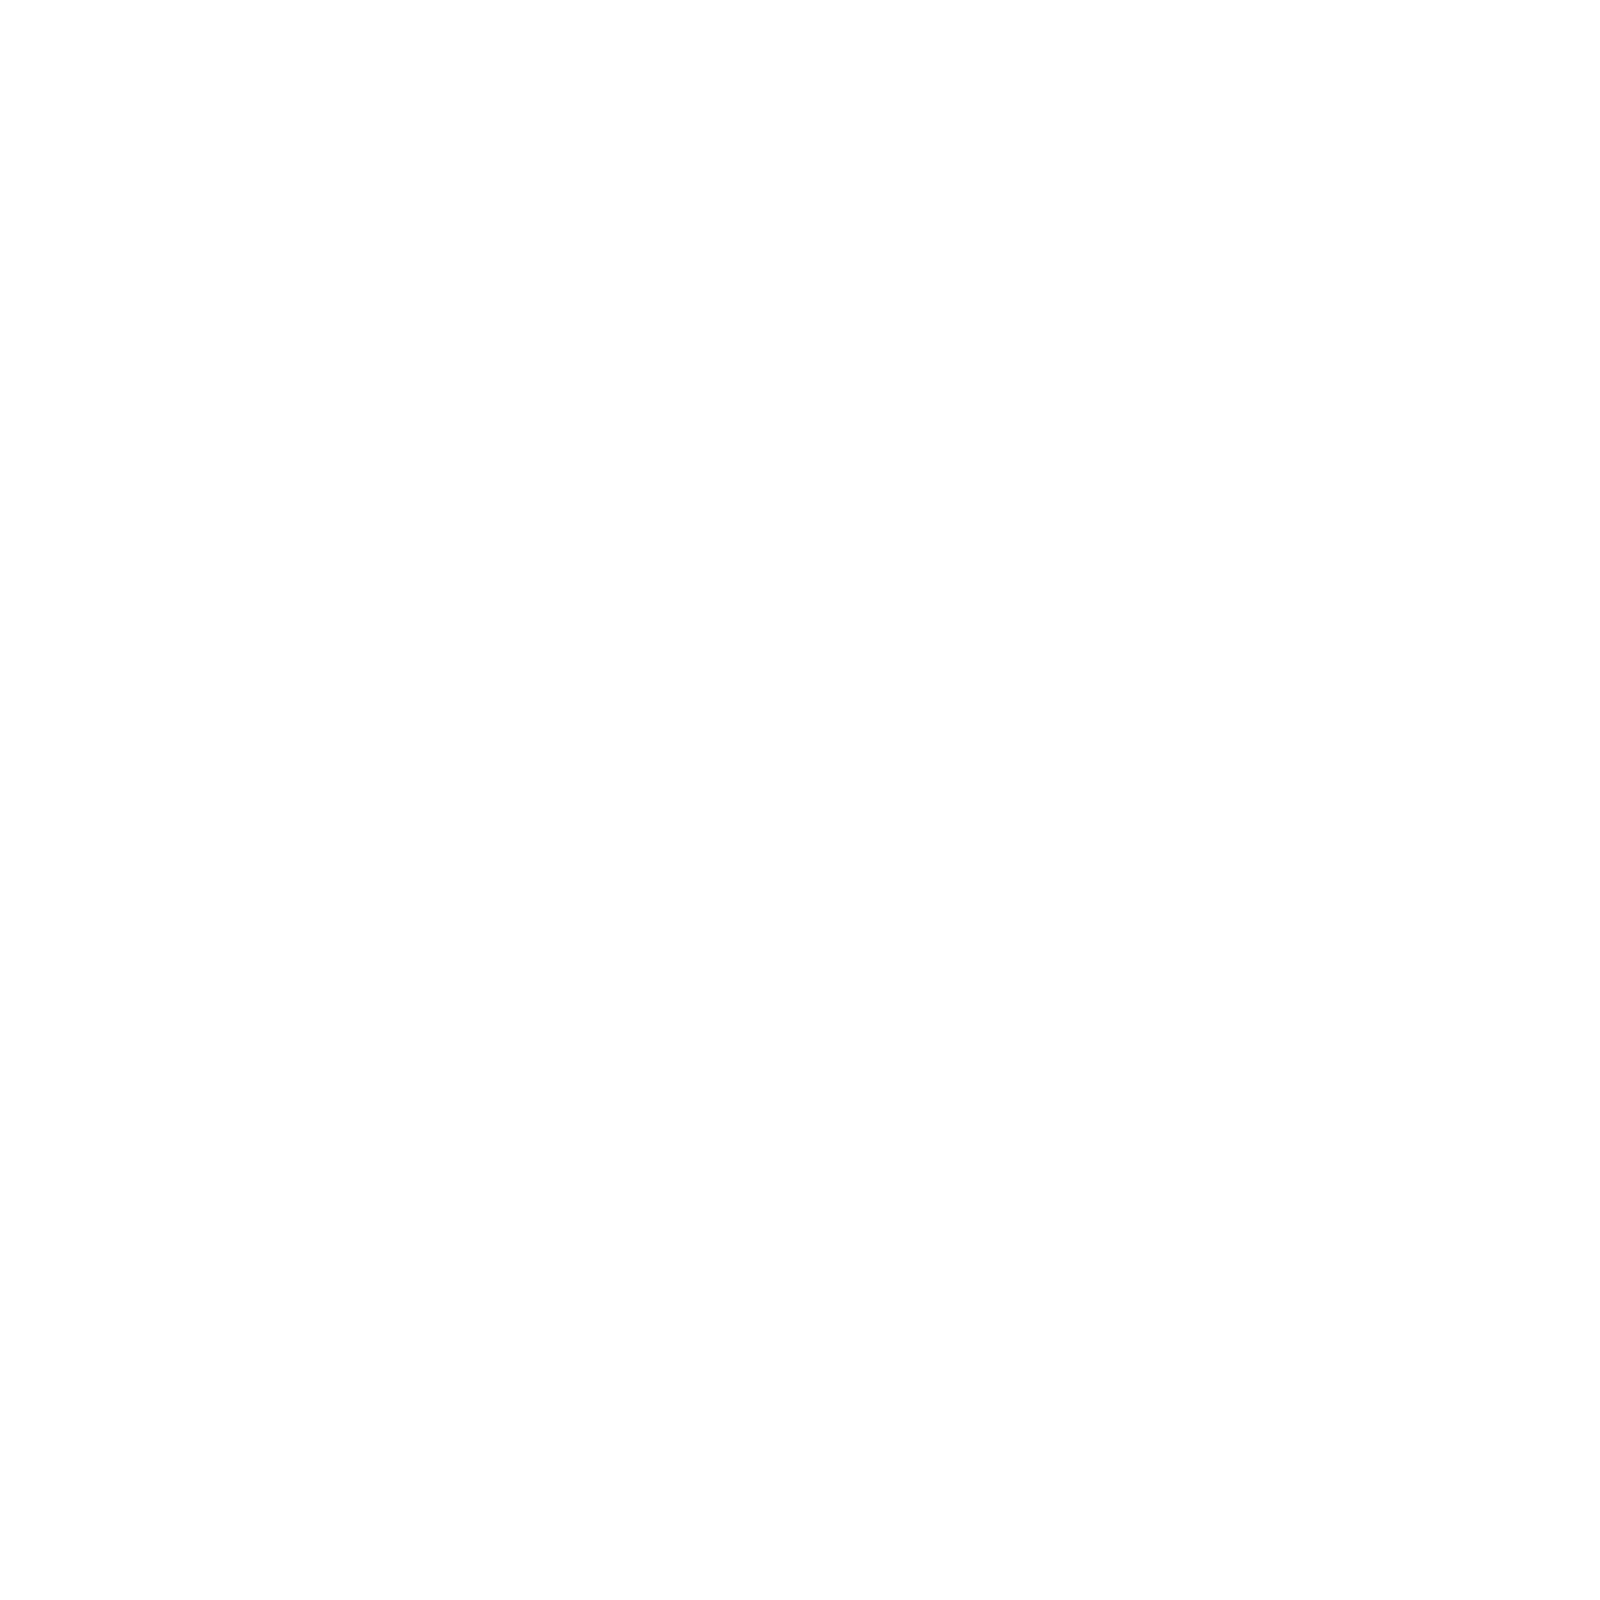

<IPython.core.display.Javascript object>


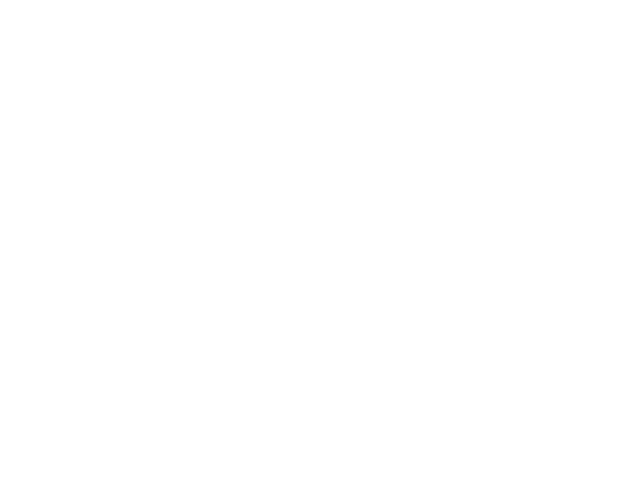

<IPython.core.display.Javascript object>


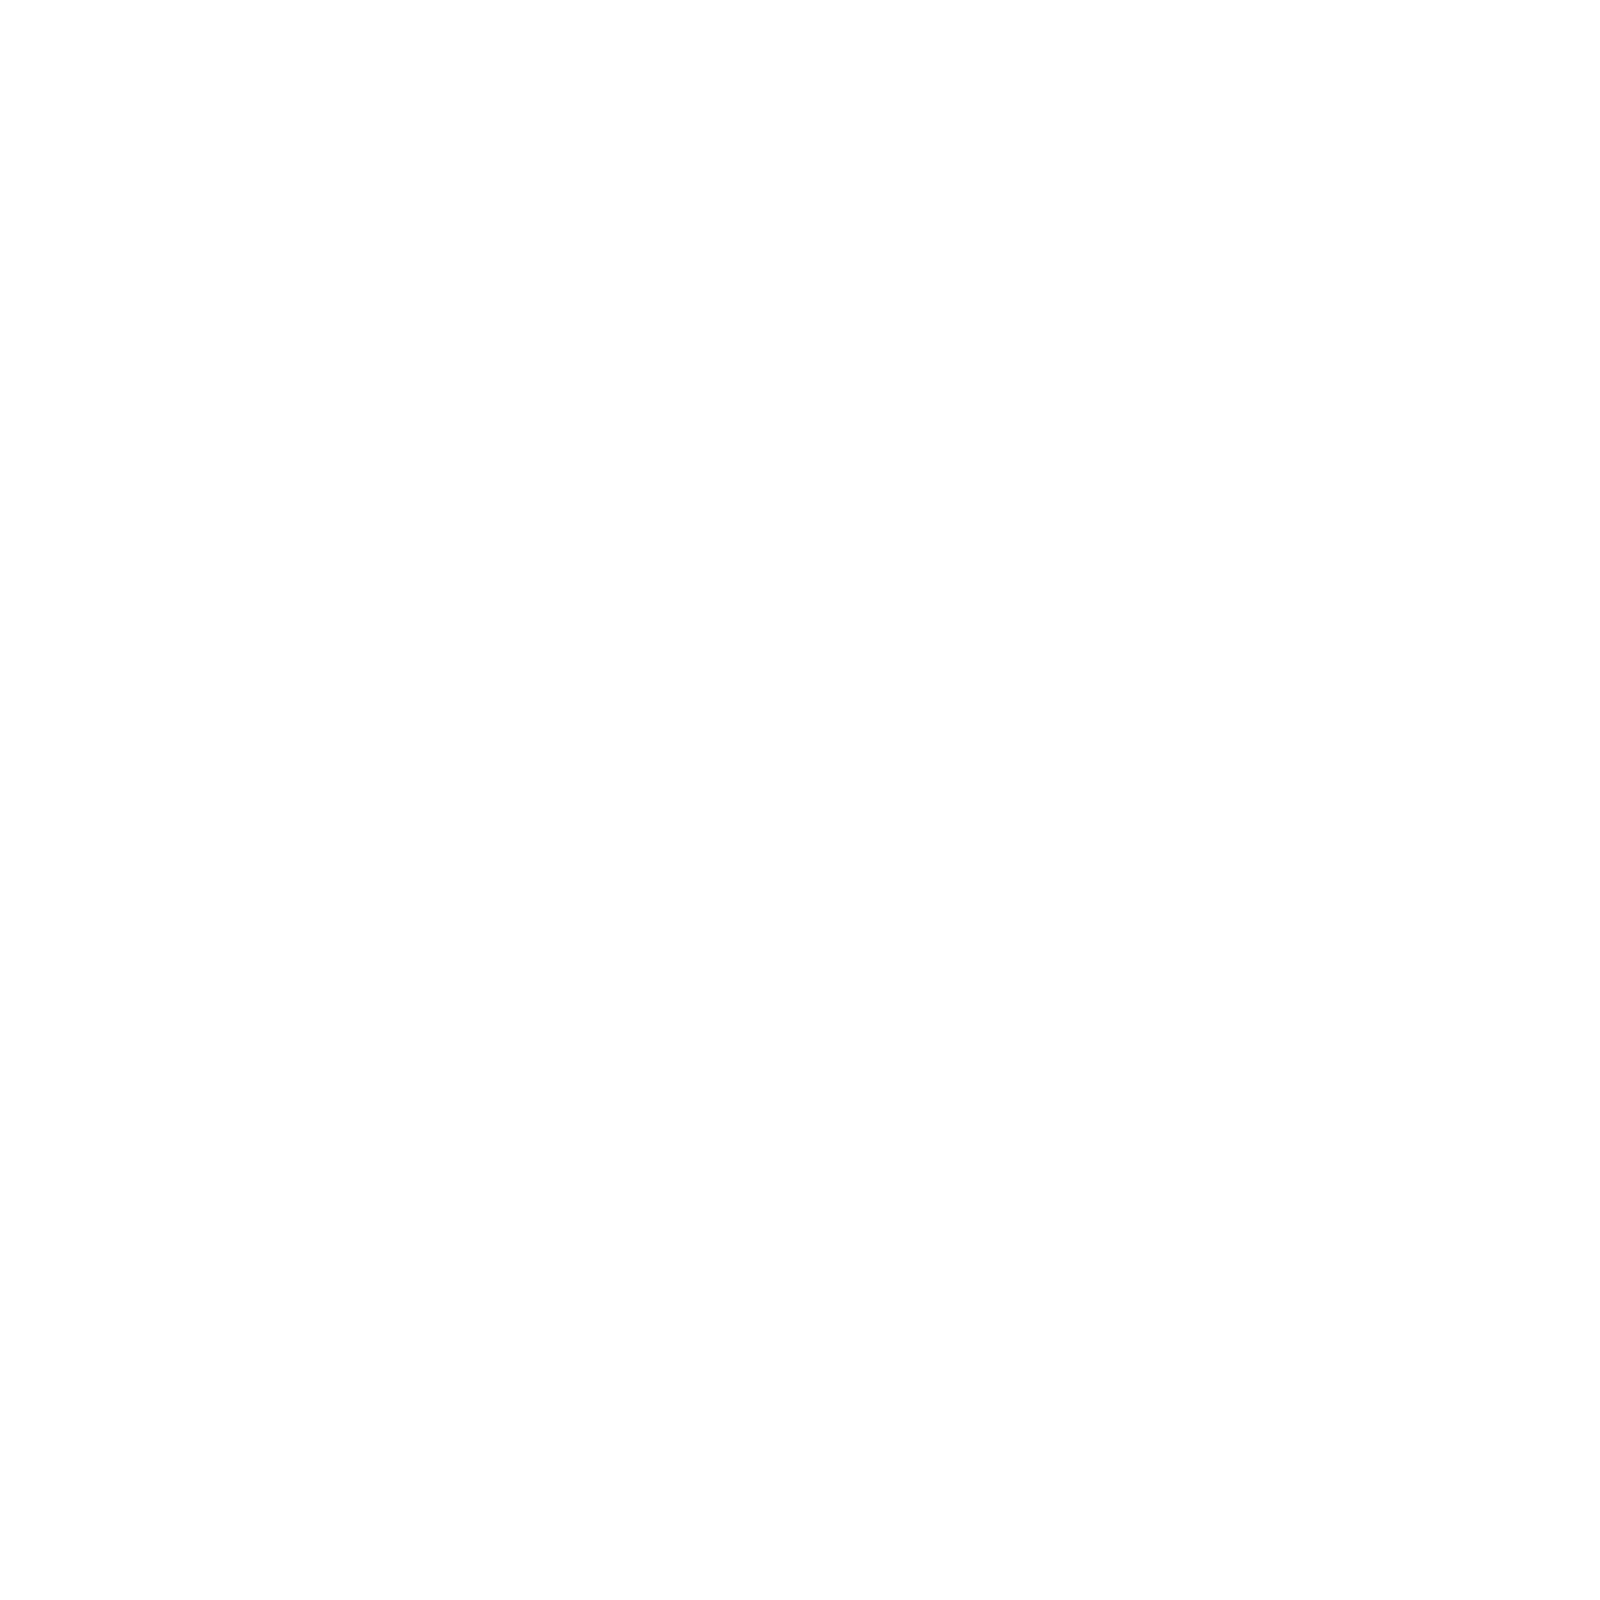

<IPython.core.display.Javascript object>


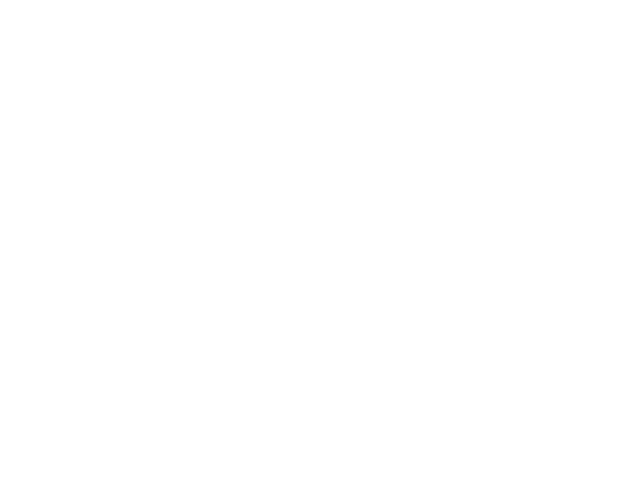

<IPython.core.display.Javascript object>


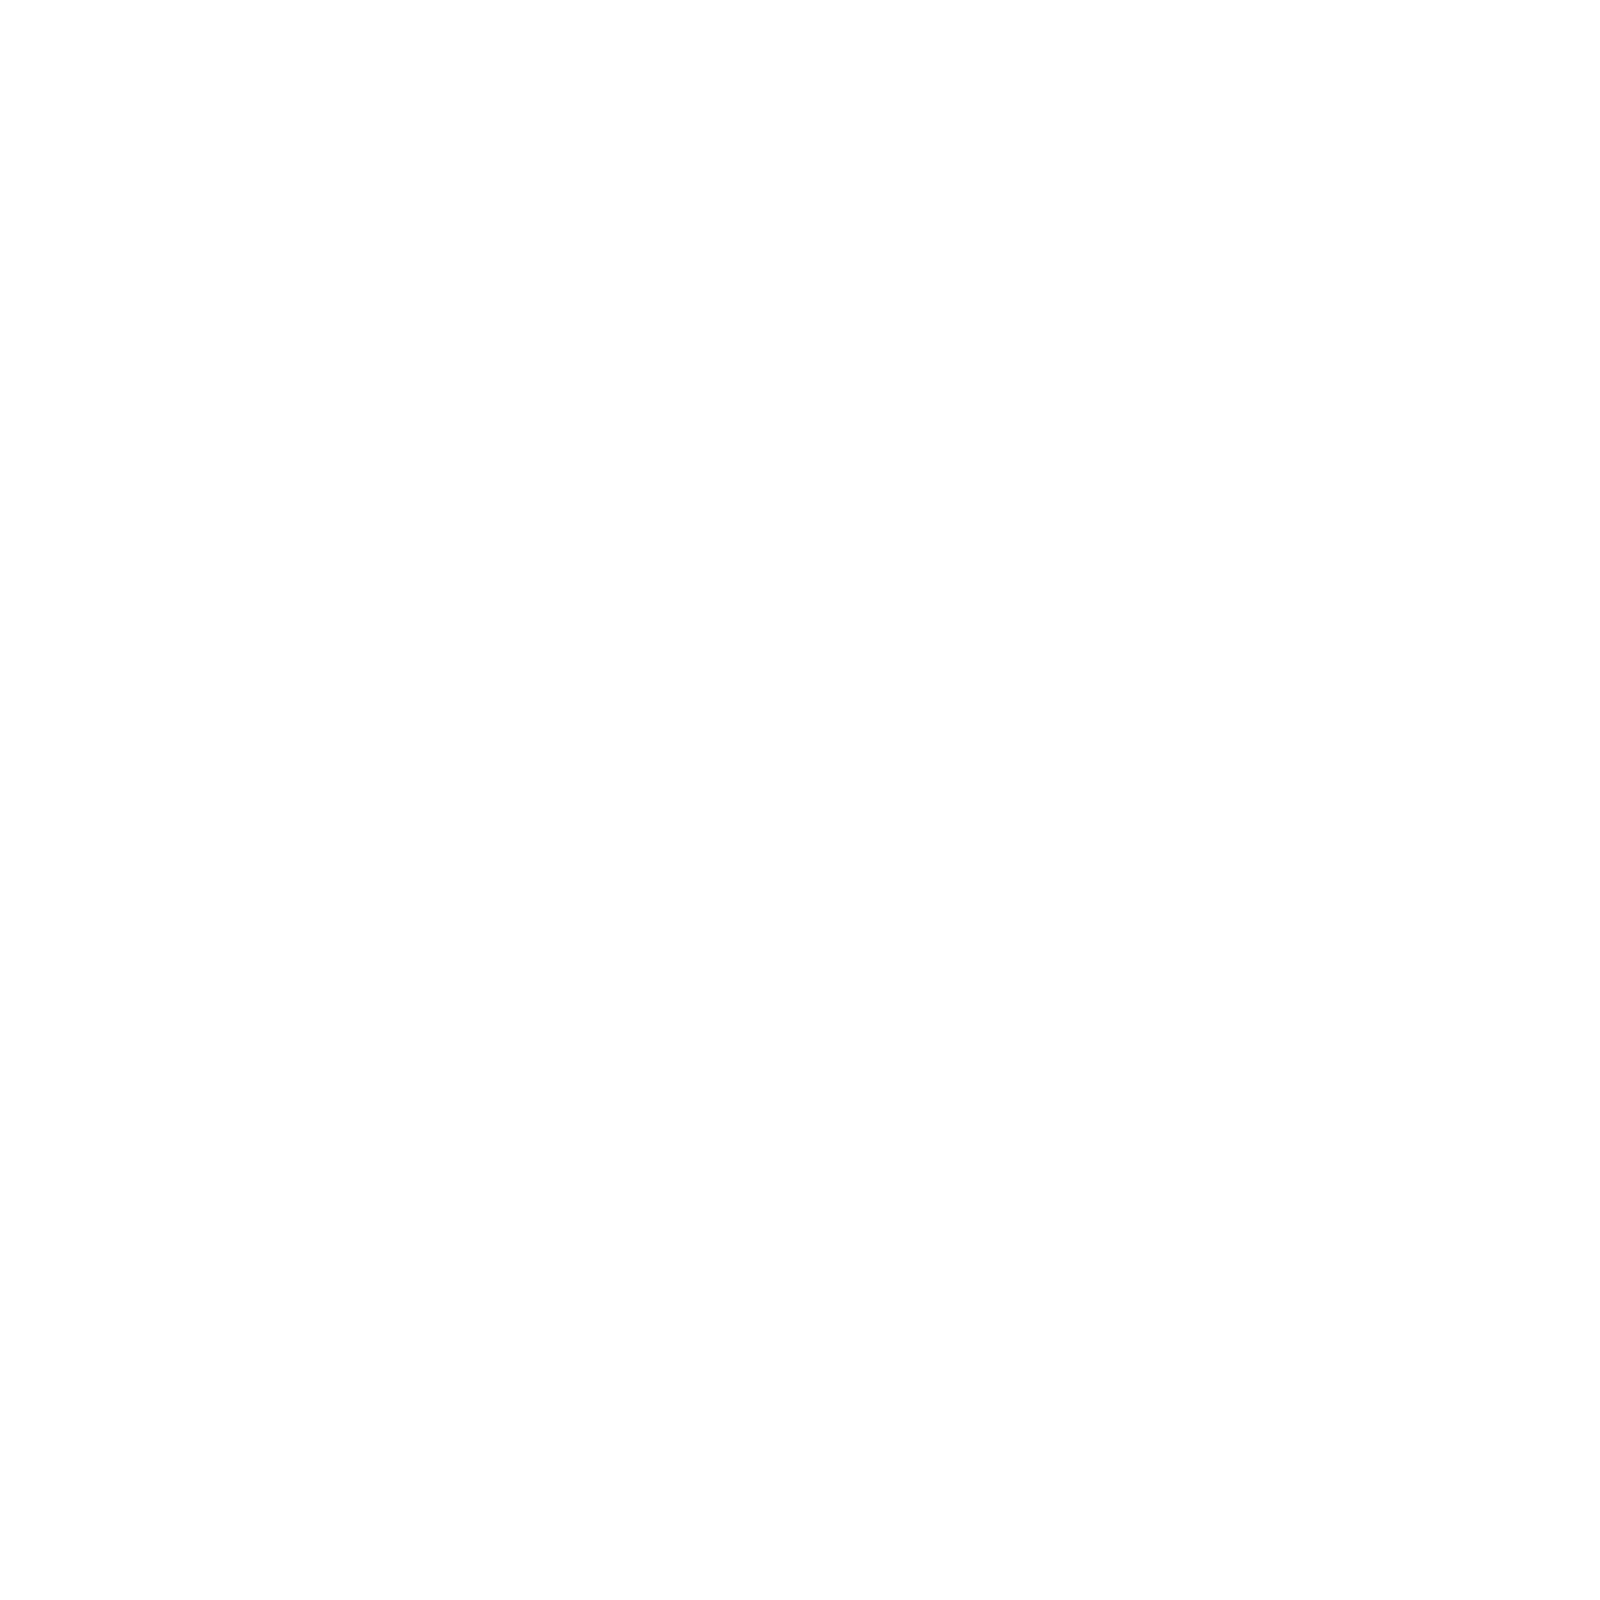

<IPython.core.display.Javascript object>


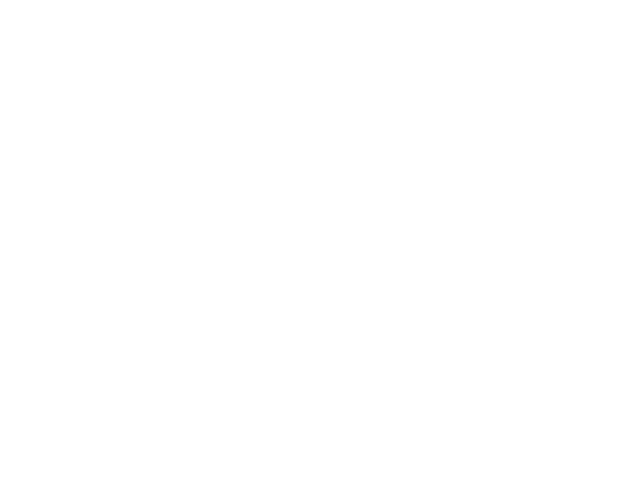

<IPython.core.display.Javascript object>


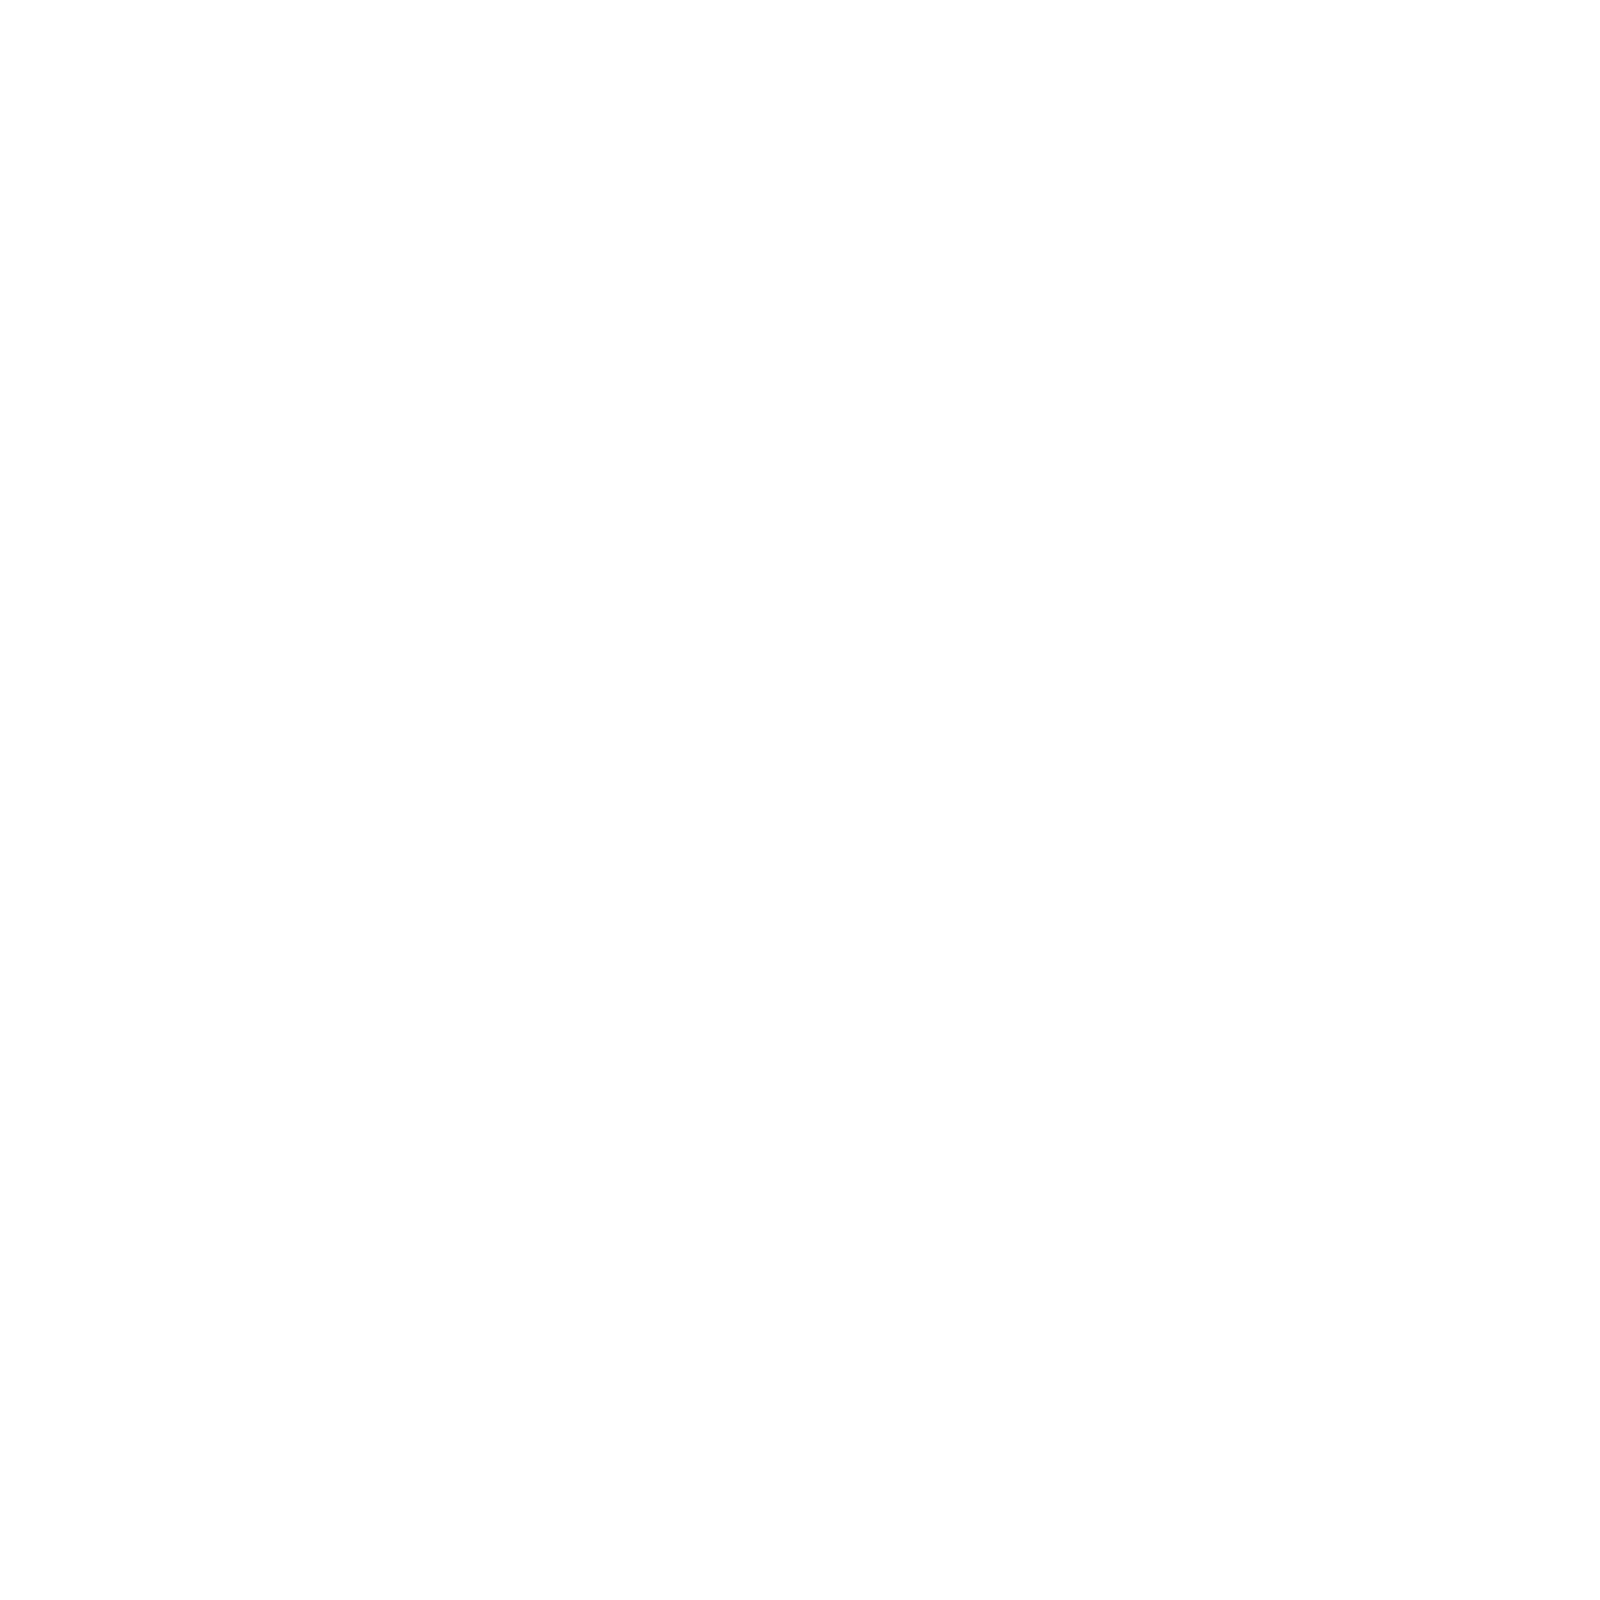

<IPython.core.display.Javascript object>


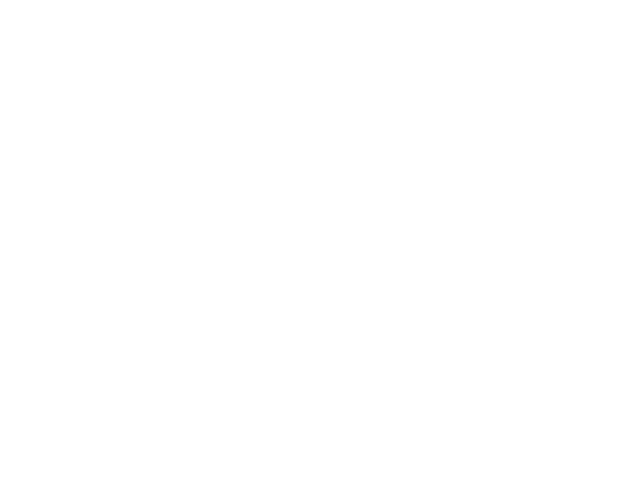

<IPython.core.display.Javascript object>


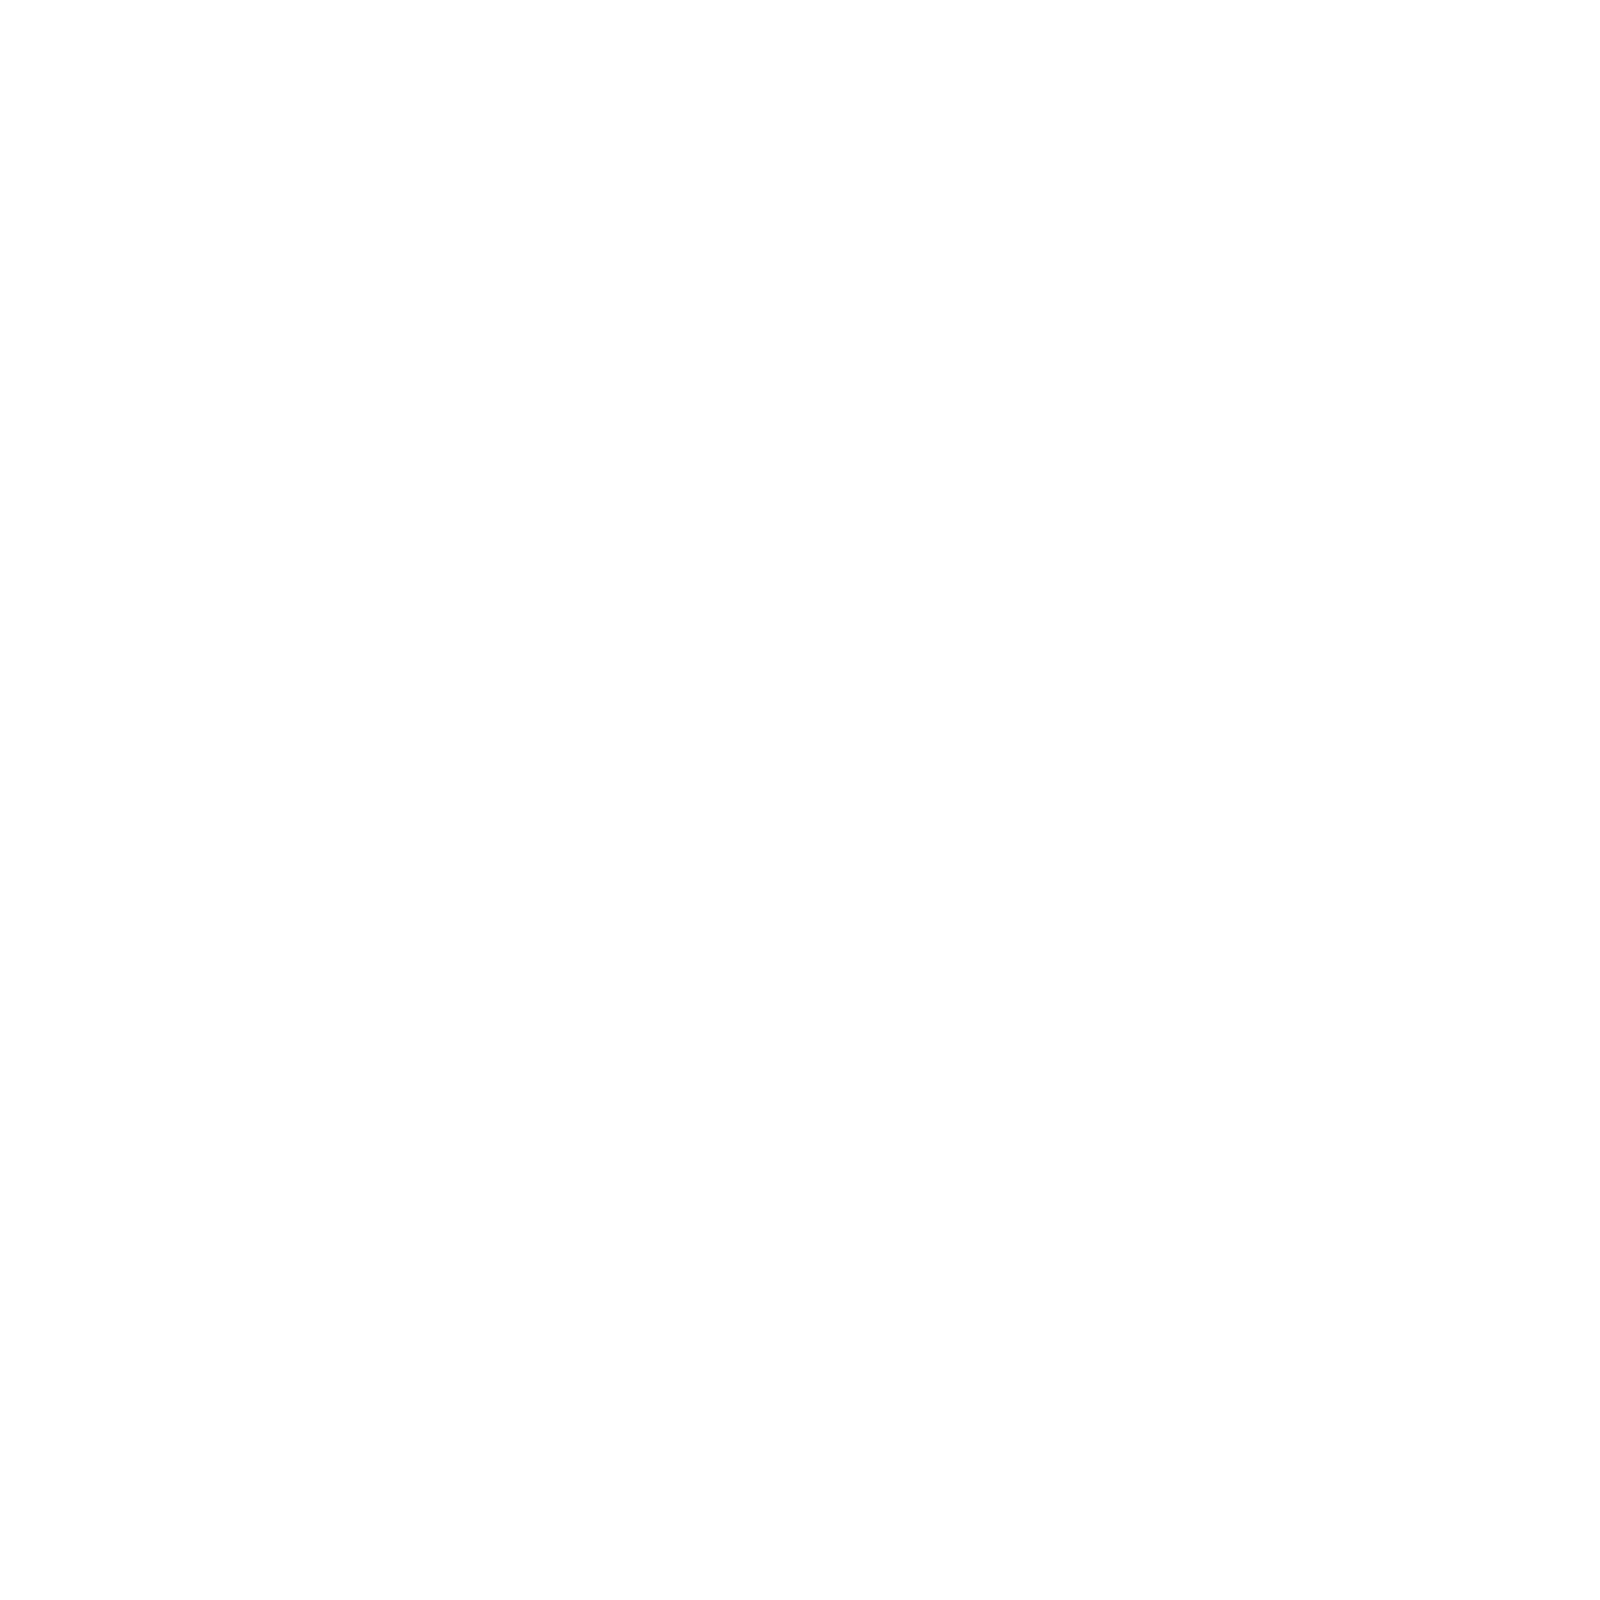

<IPython.core.display.Javascript object>


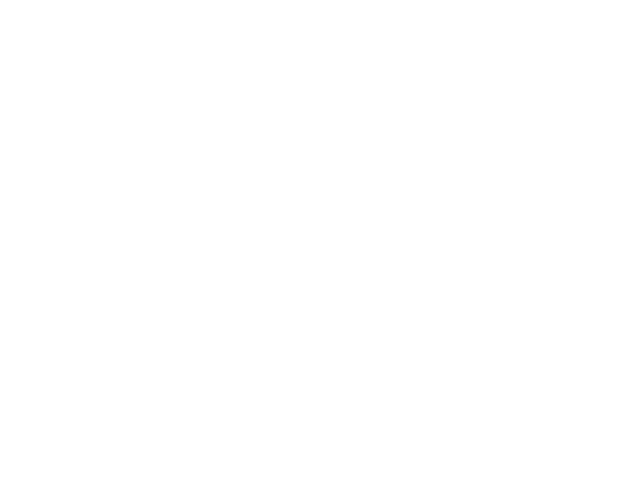

<IPython.core.display.Javascript object>


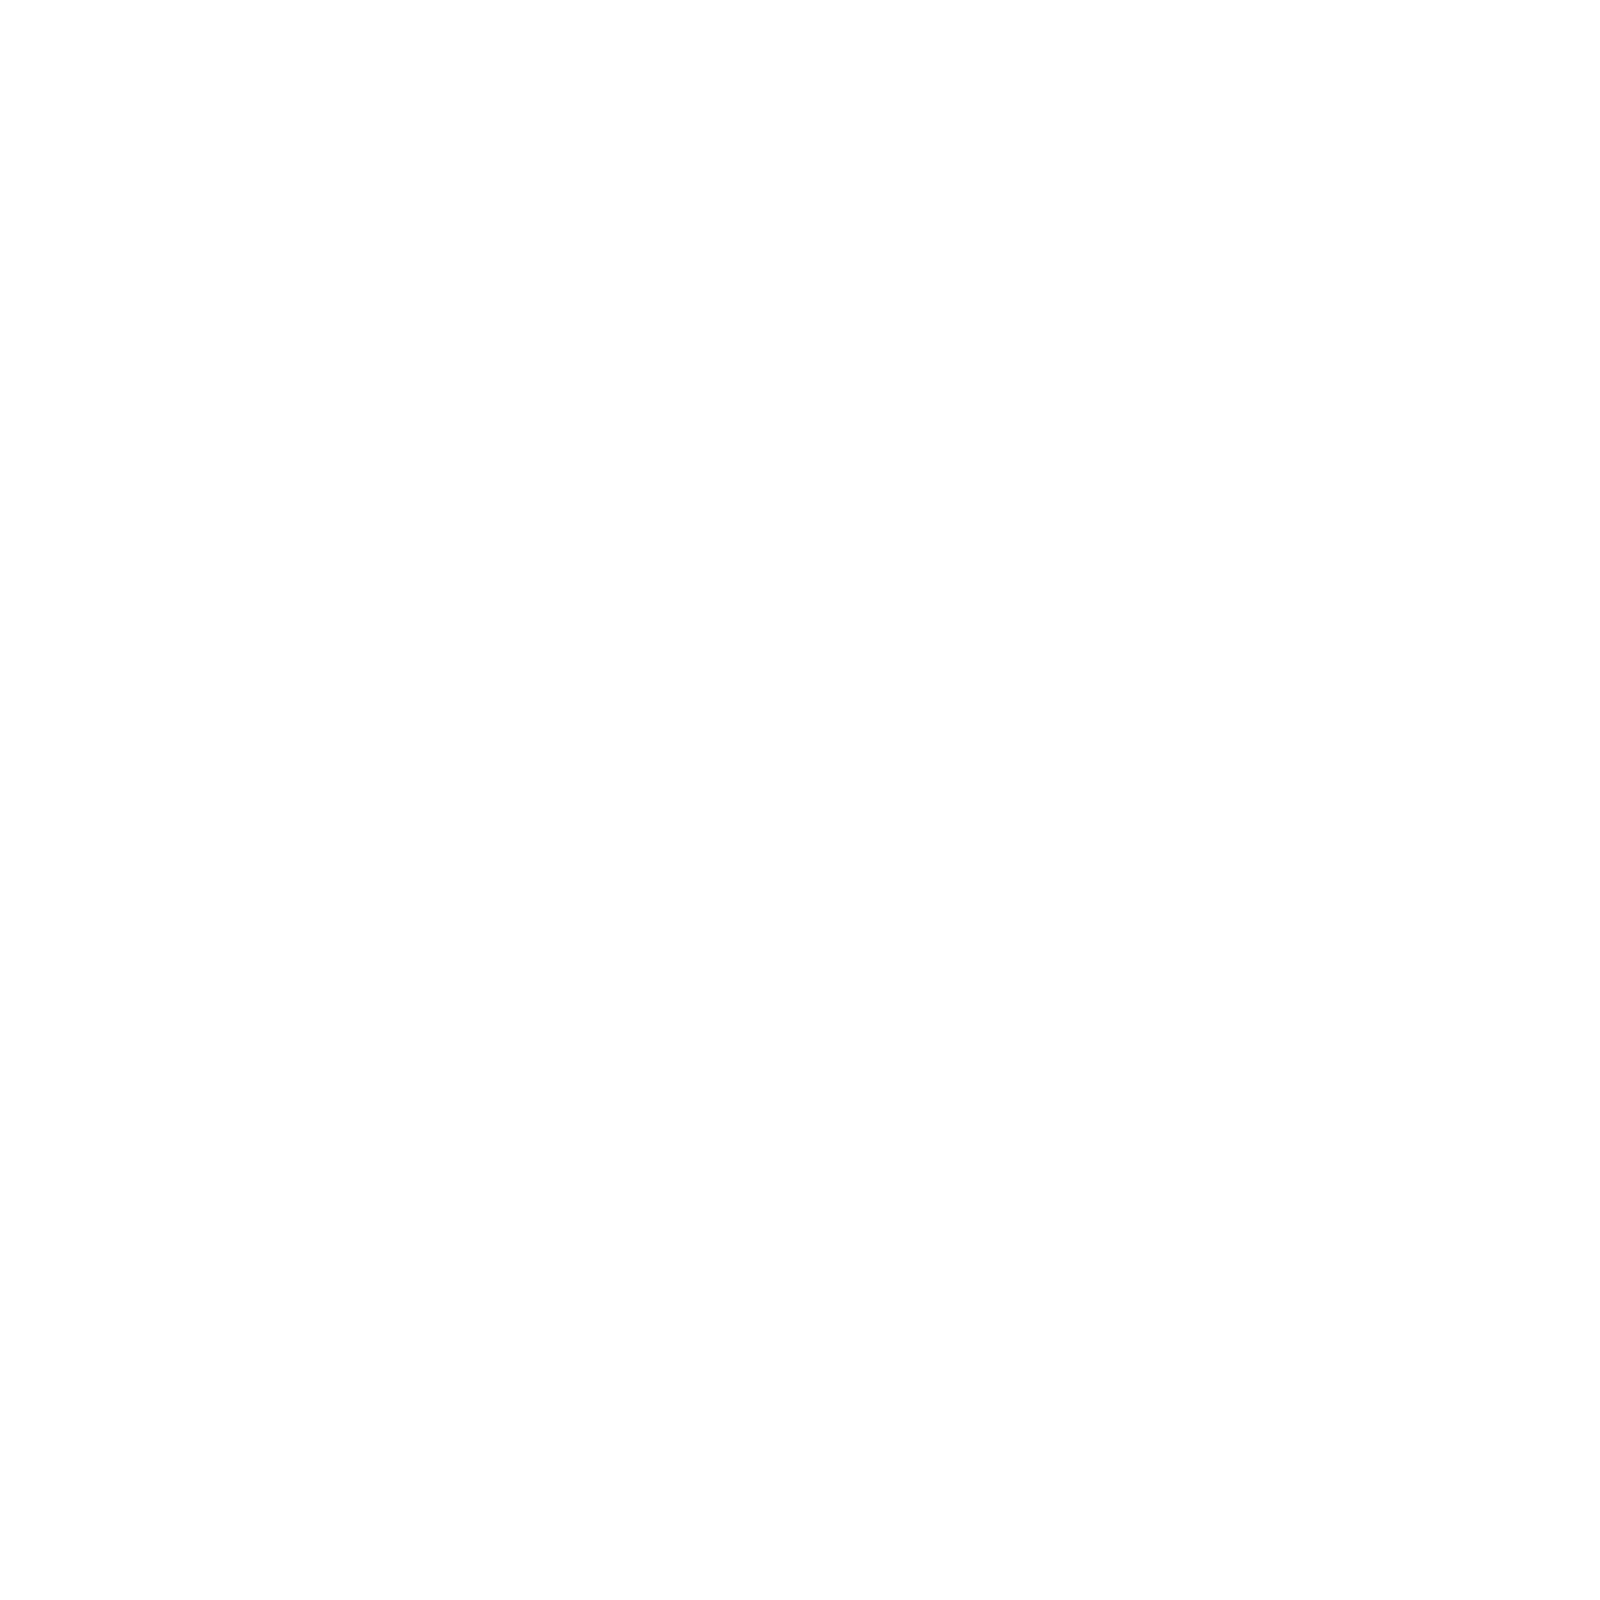

<IPython.core.display.Javascript object>


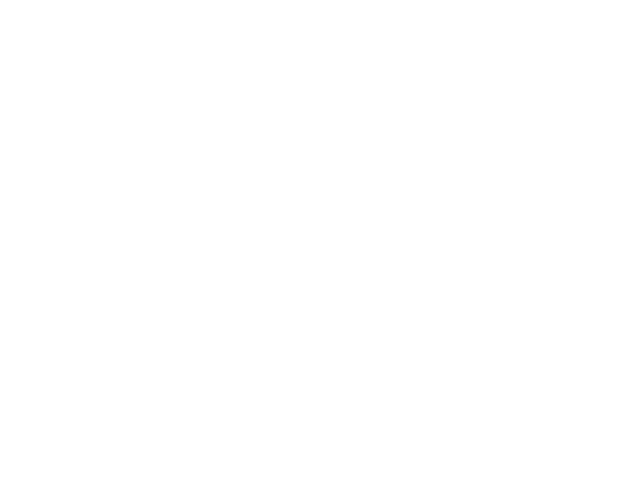

<IPython.core.display.Javascript object>


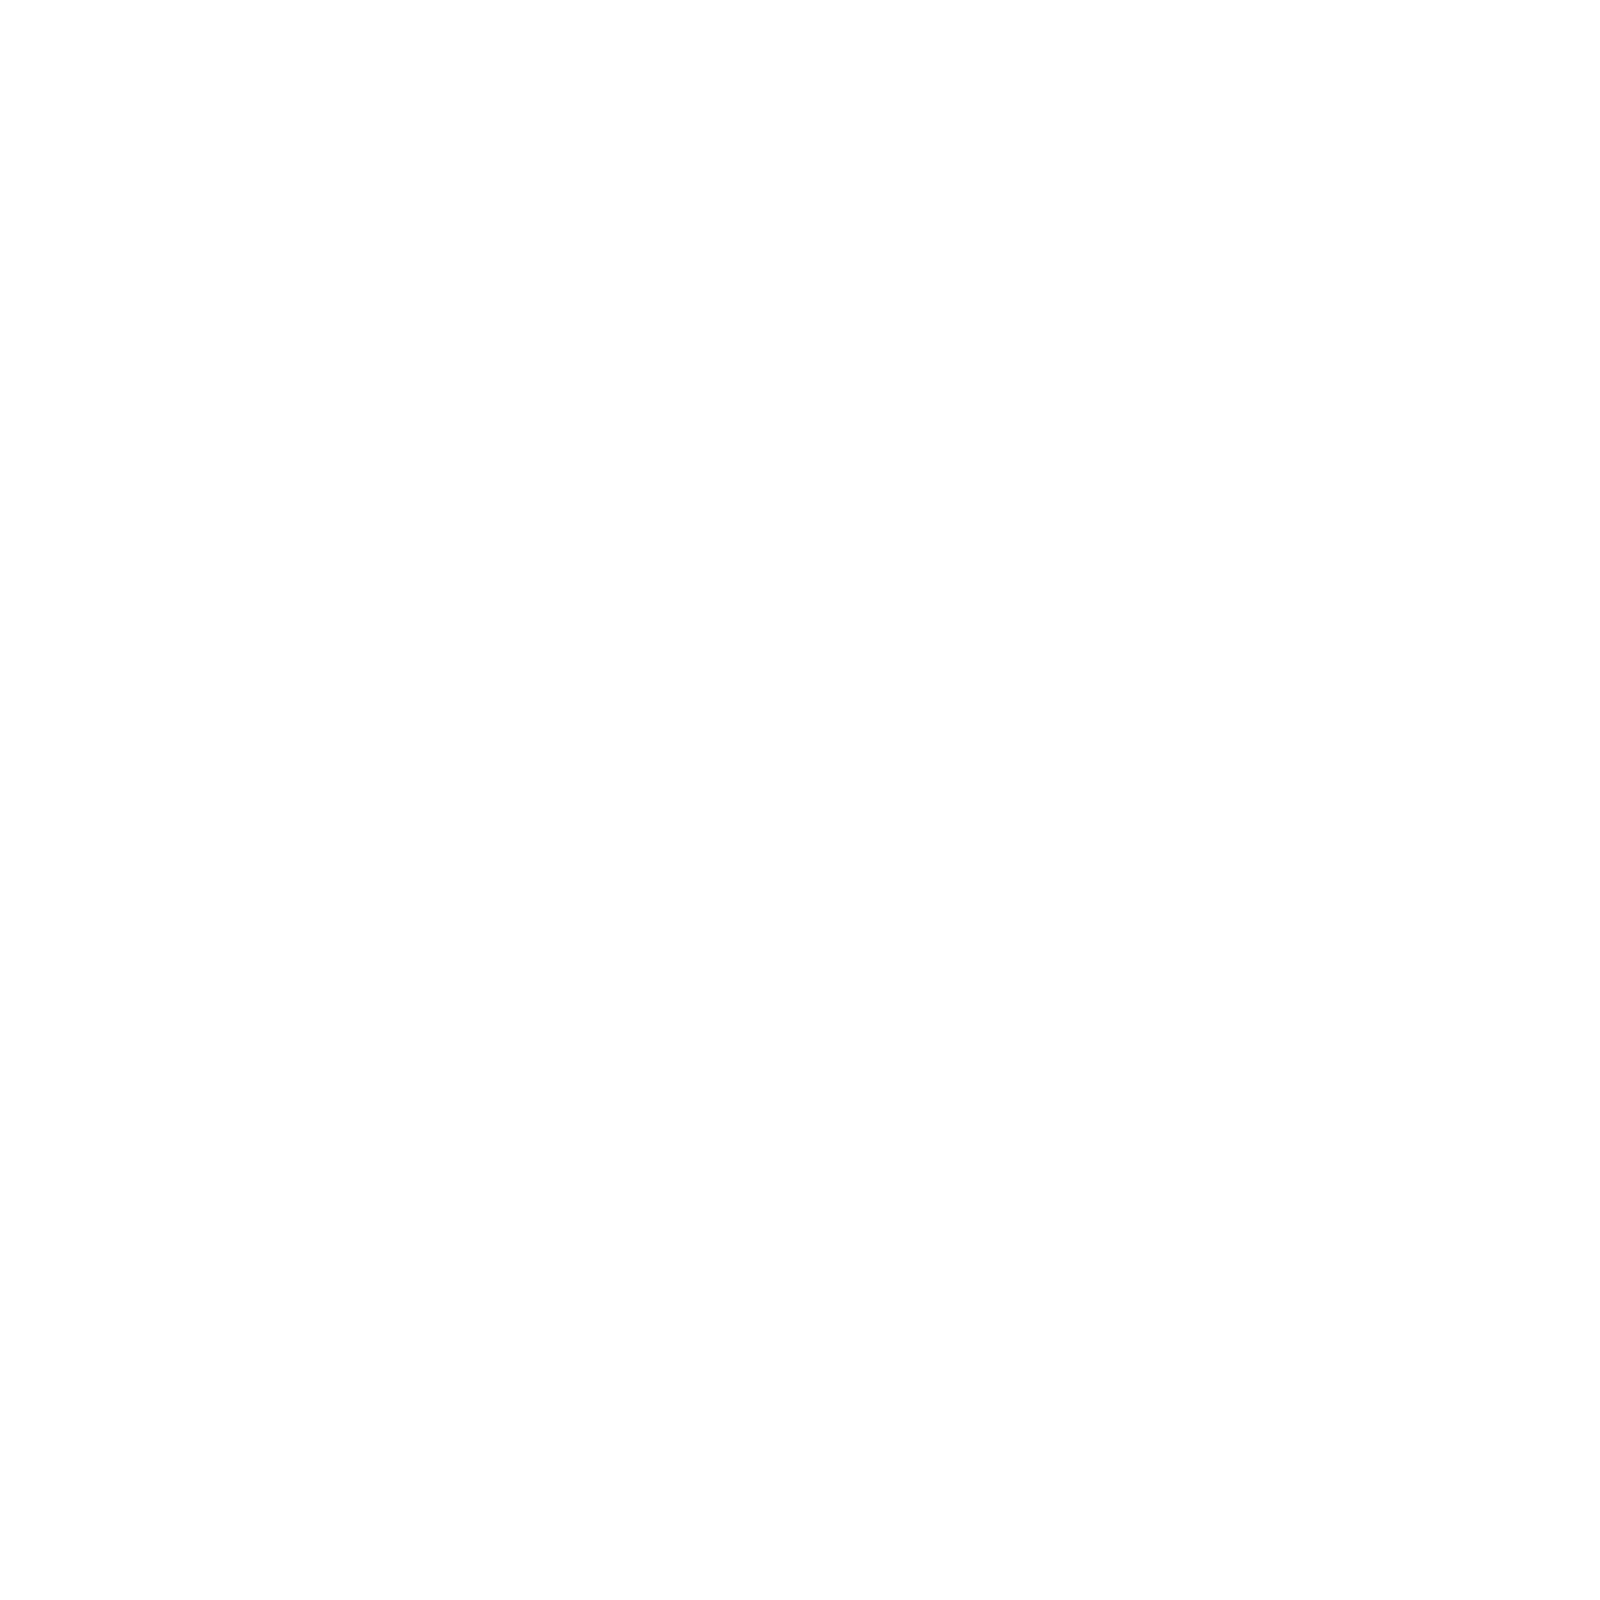

<IPython.core.display.Javascript object>


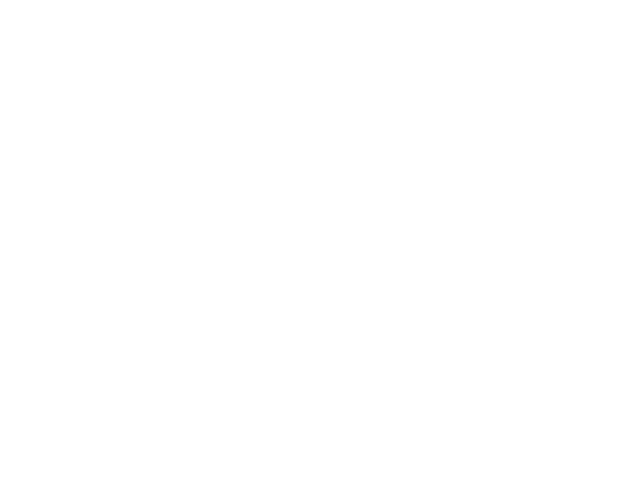

<IPython.core.display.Javascript object>


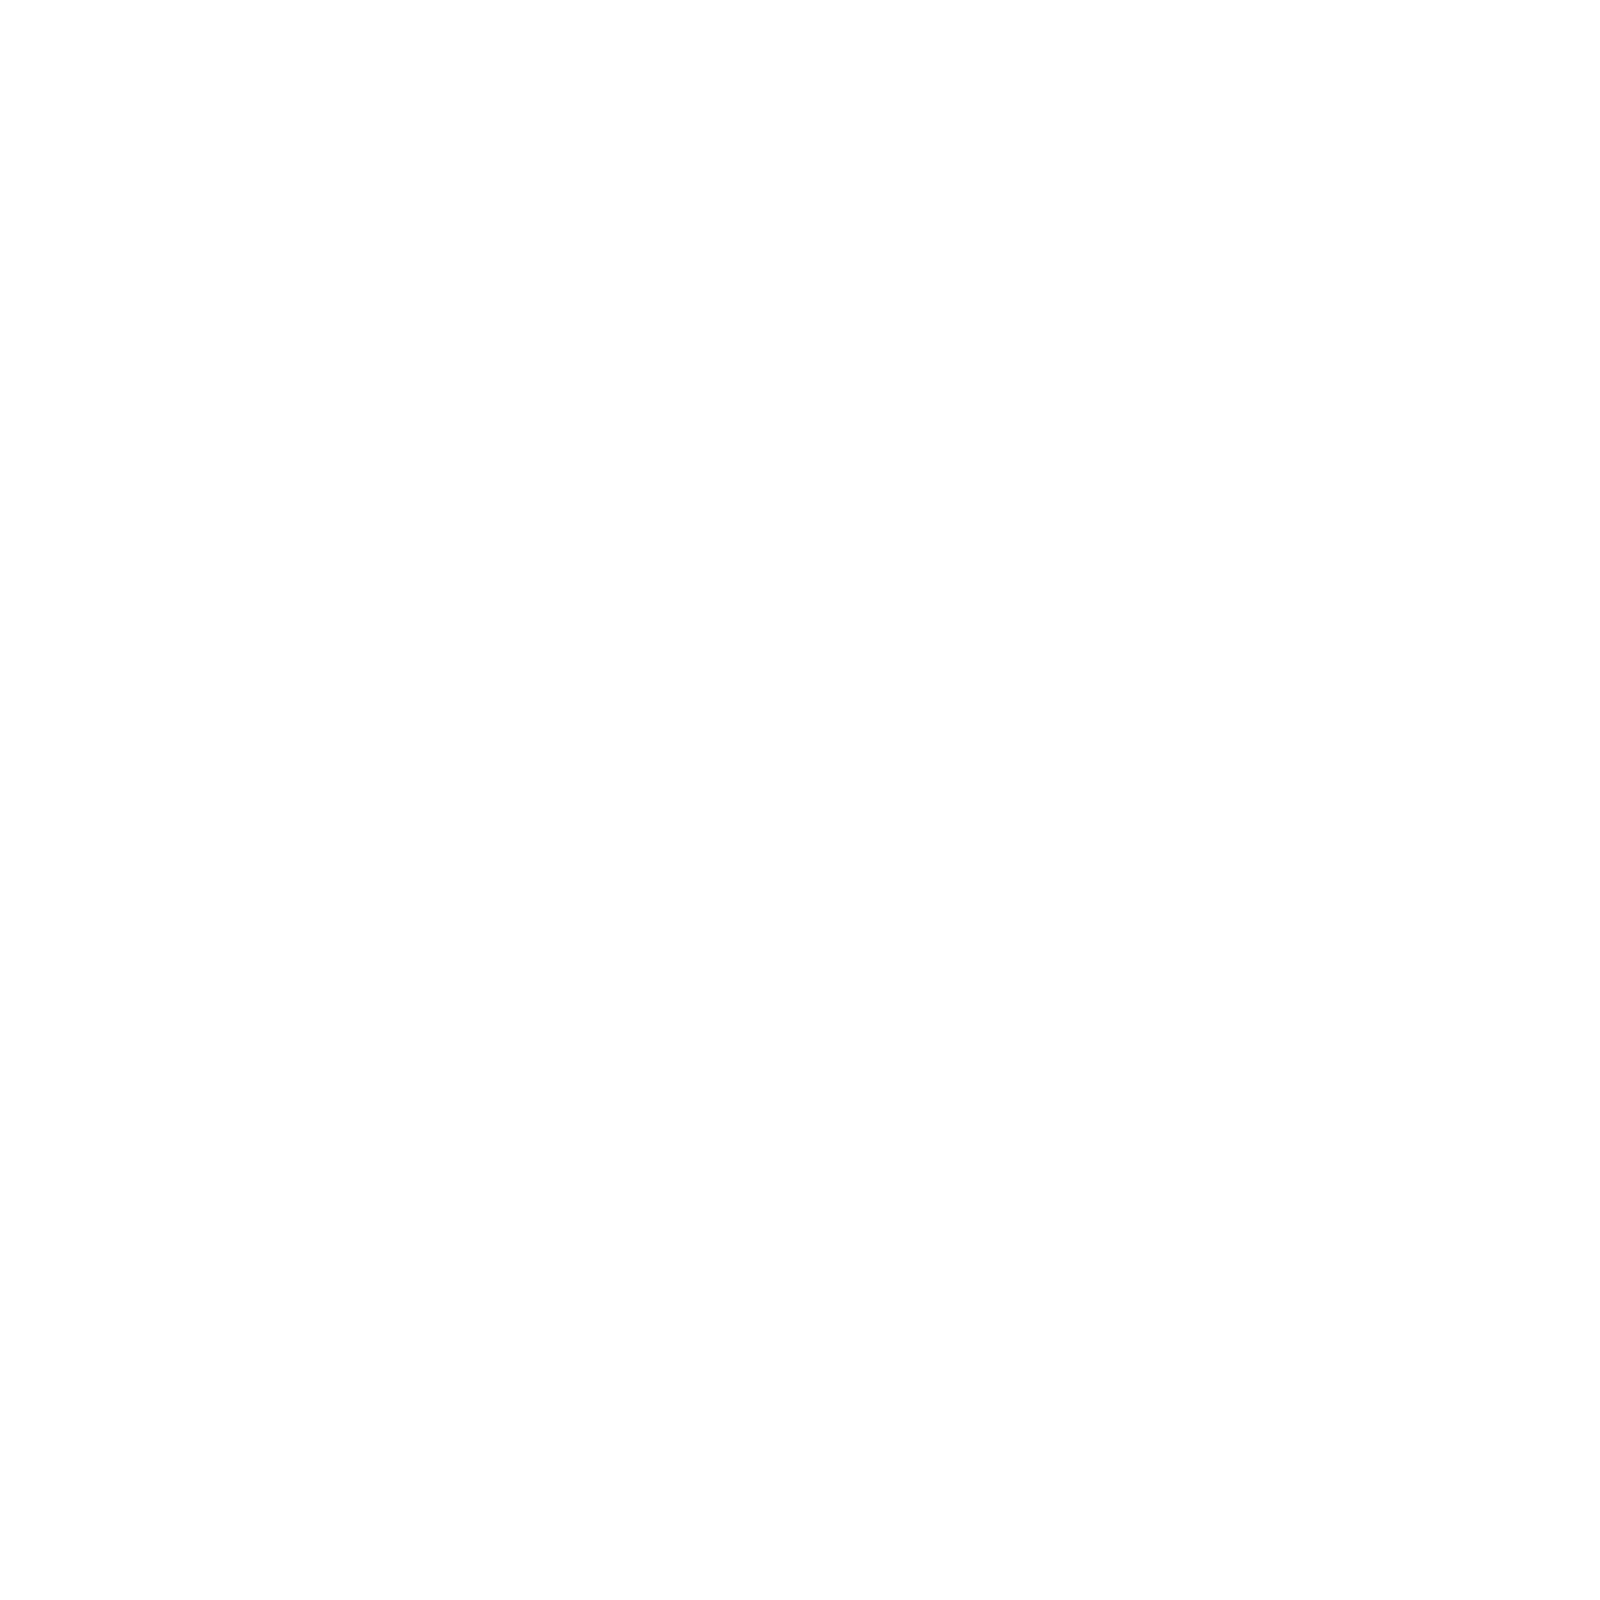

<IPython.core.display.Javascript object>


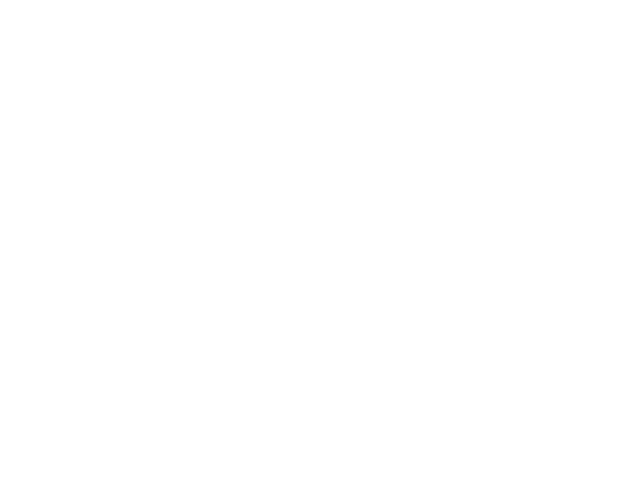

<IPython.core.display.Javascript object>


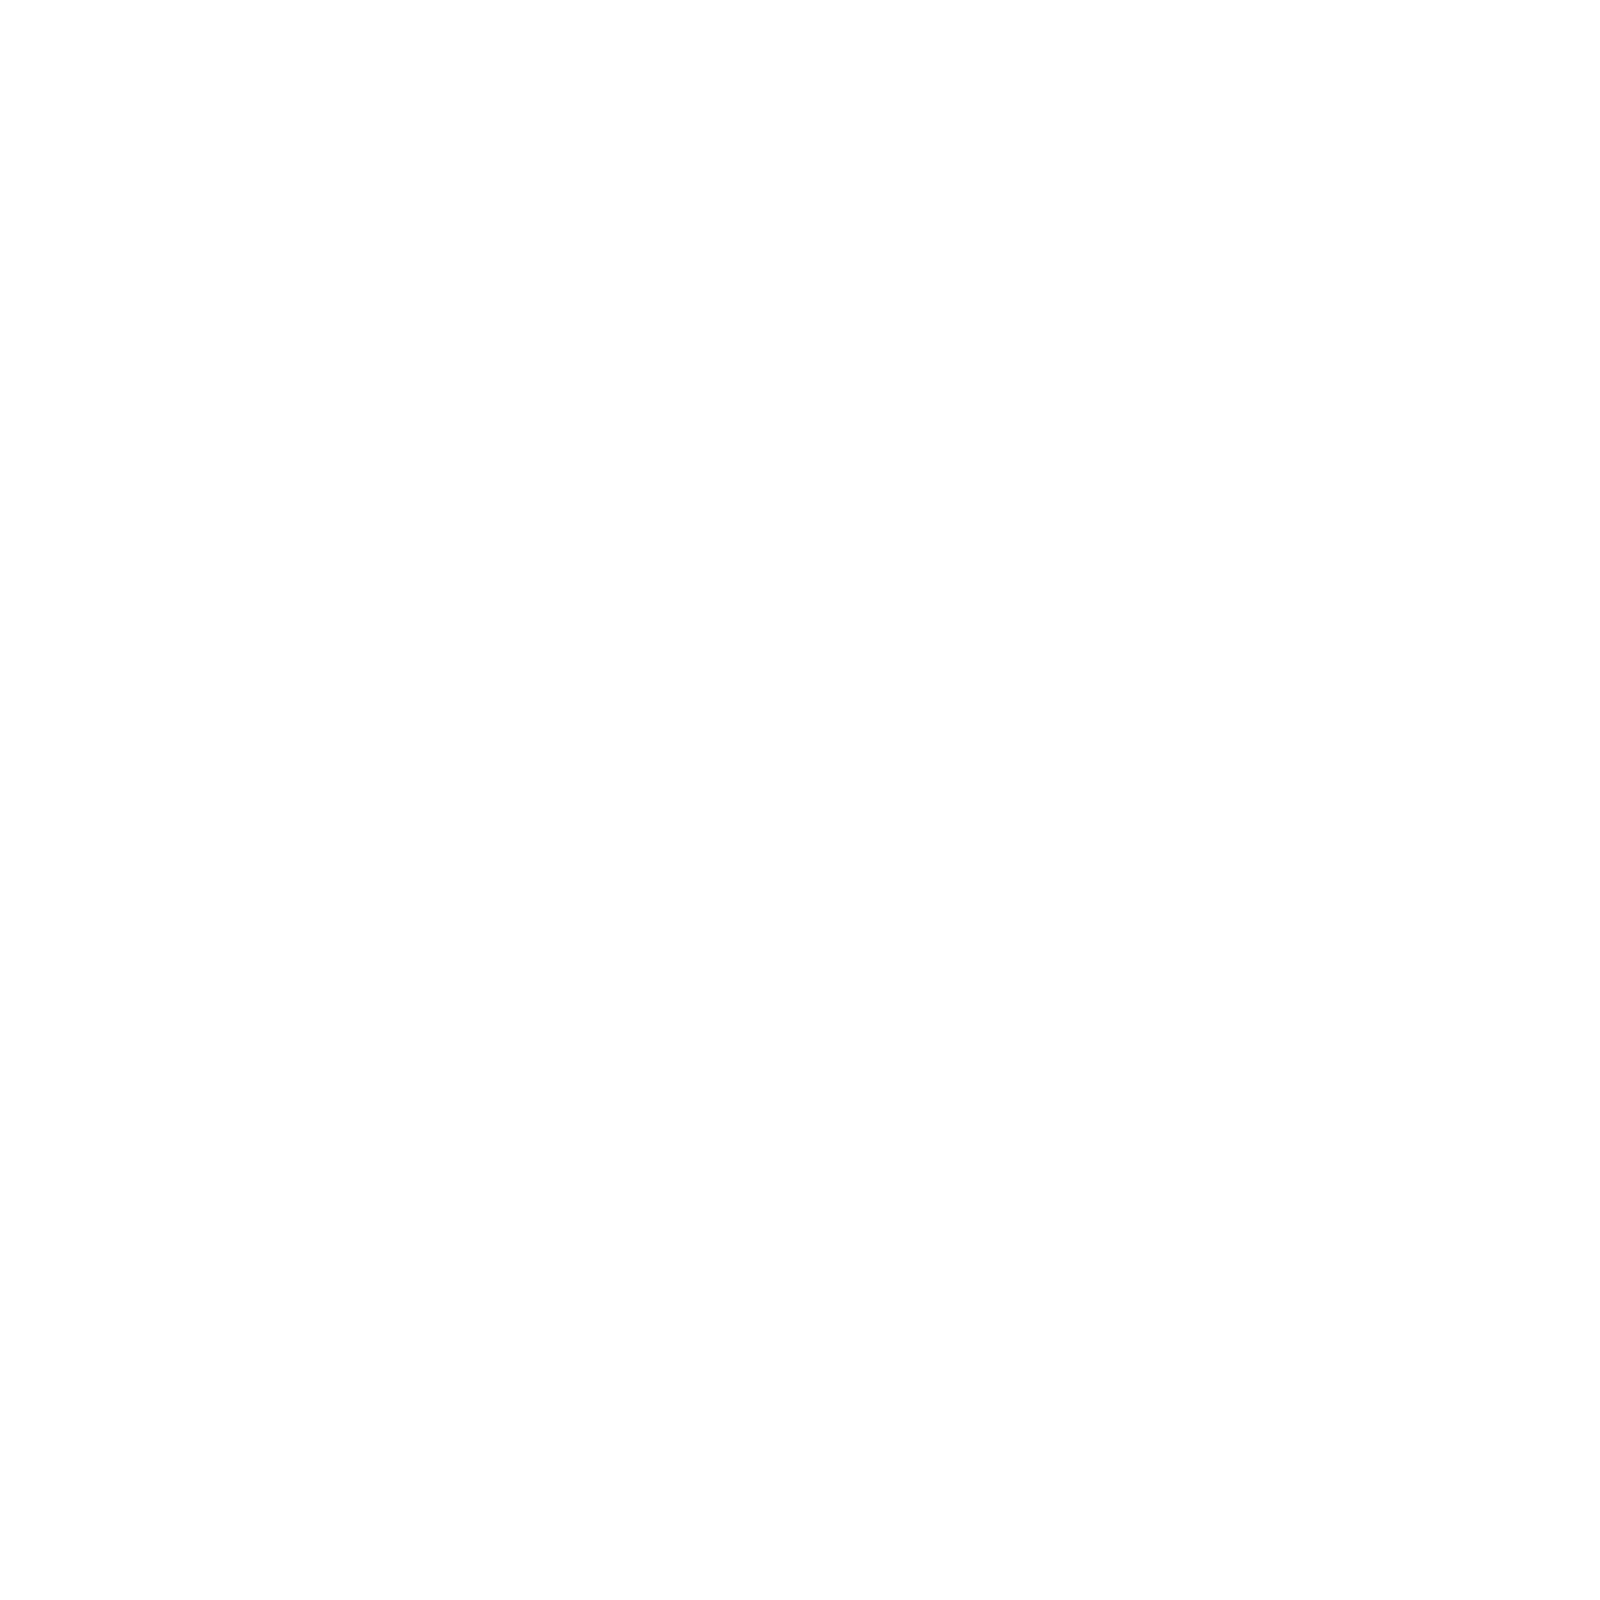

<IPython.core.display.Javascript object>


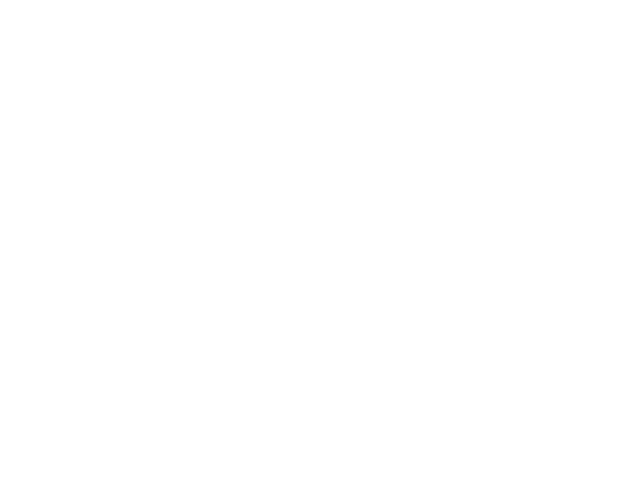

<IPython.core.display.Javascript object>


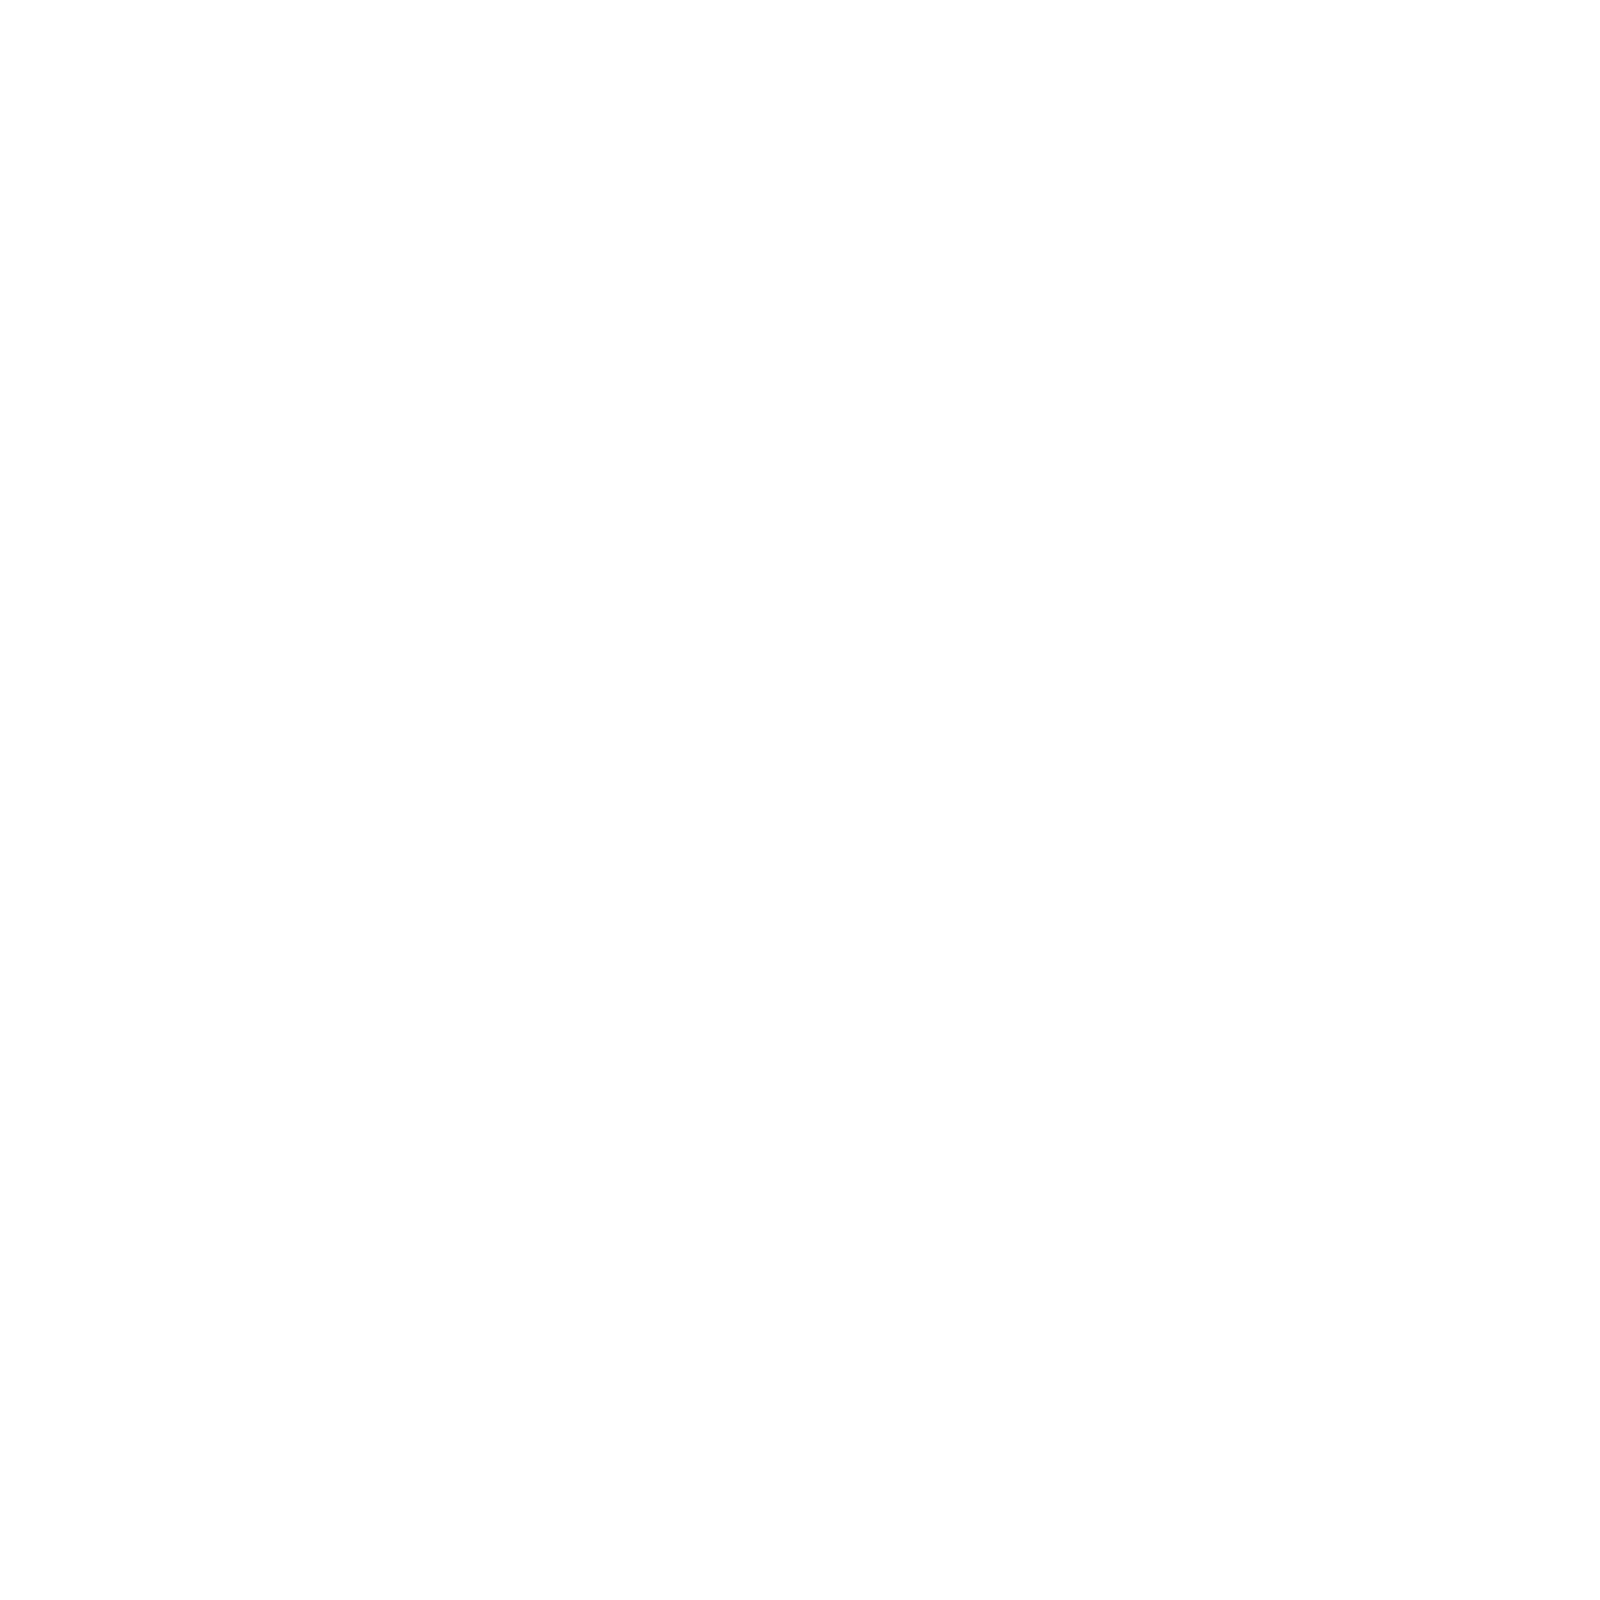

<IPython.core.display.Javascript object>


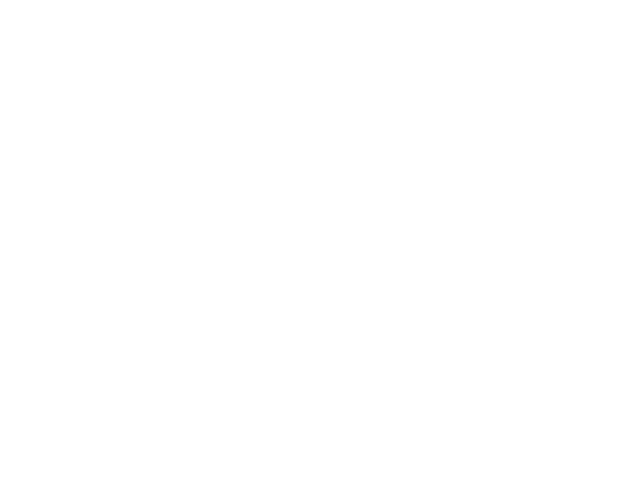

<IPython.core.display.Javascript object>


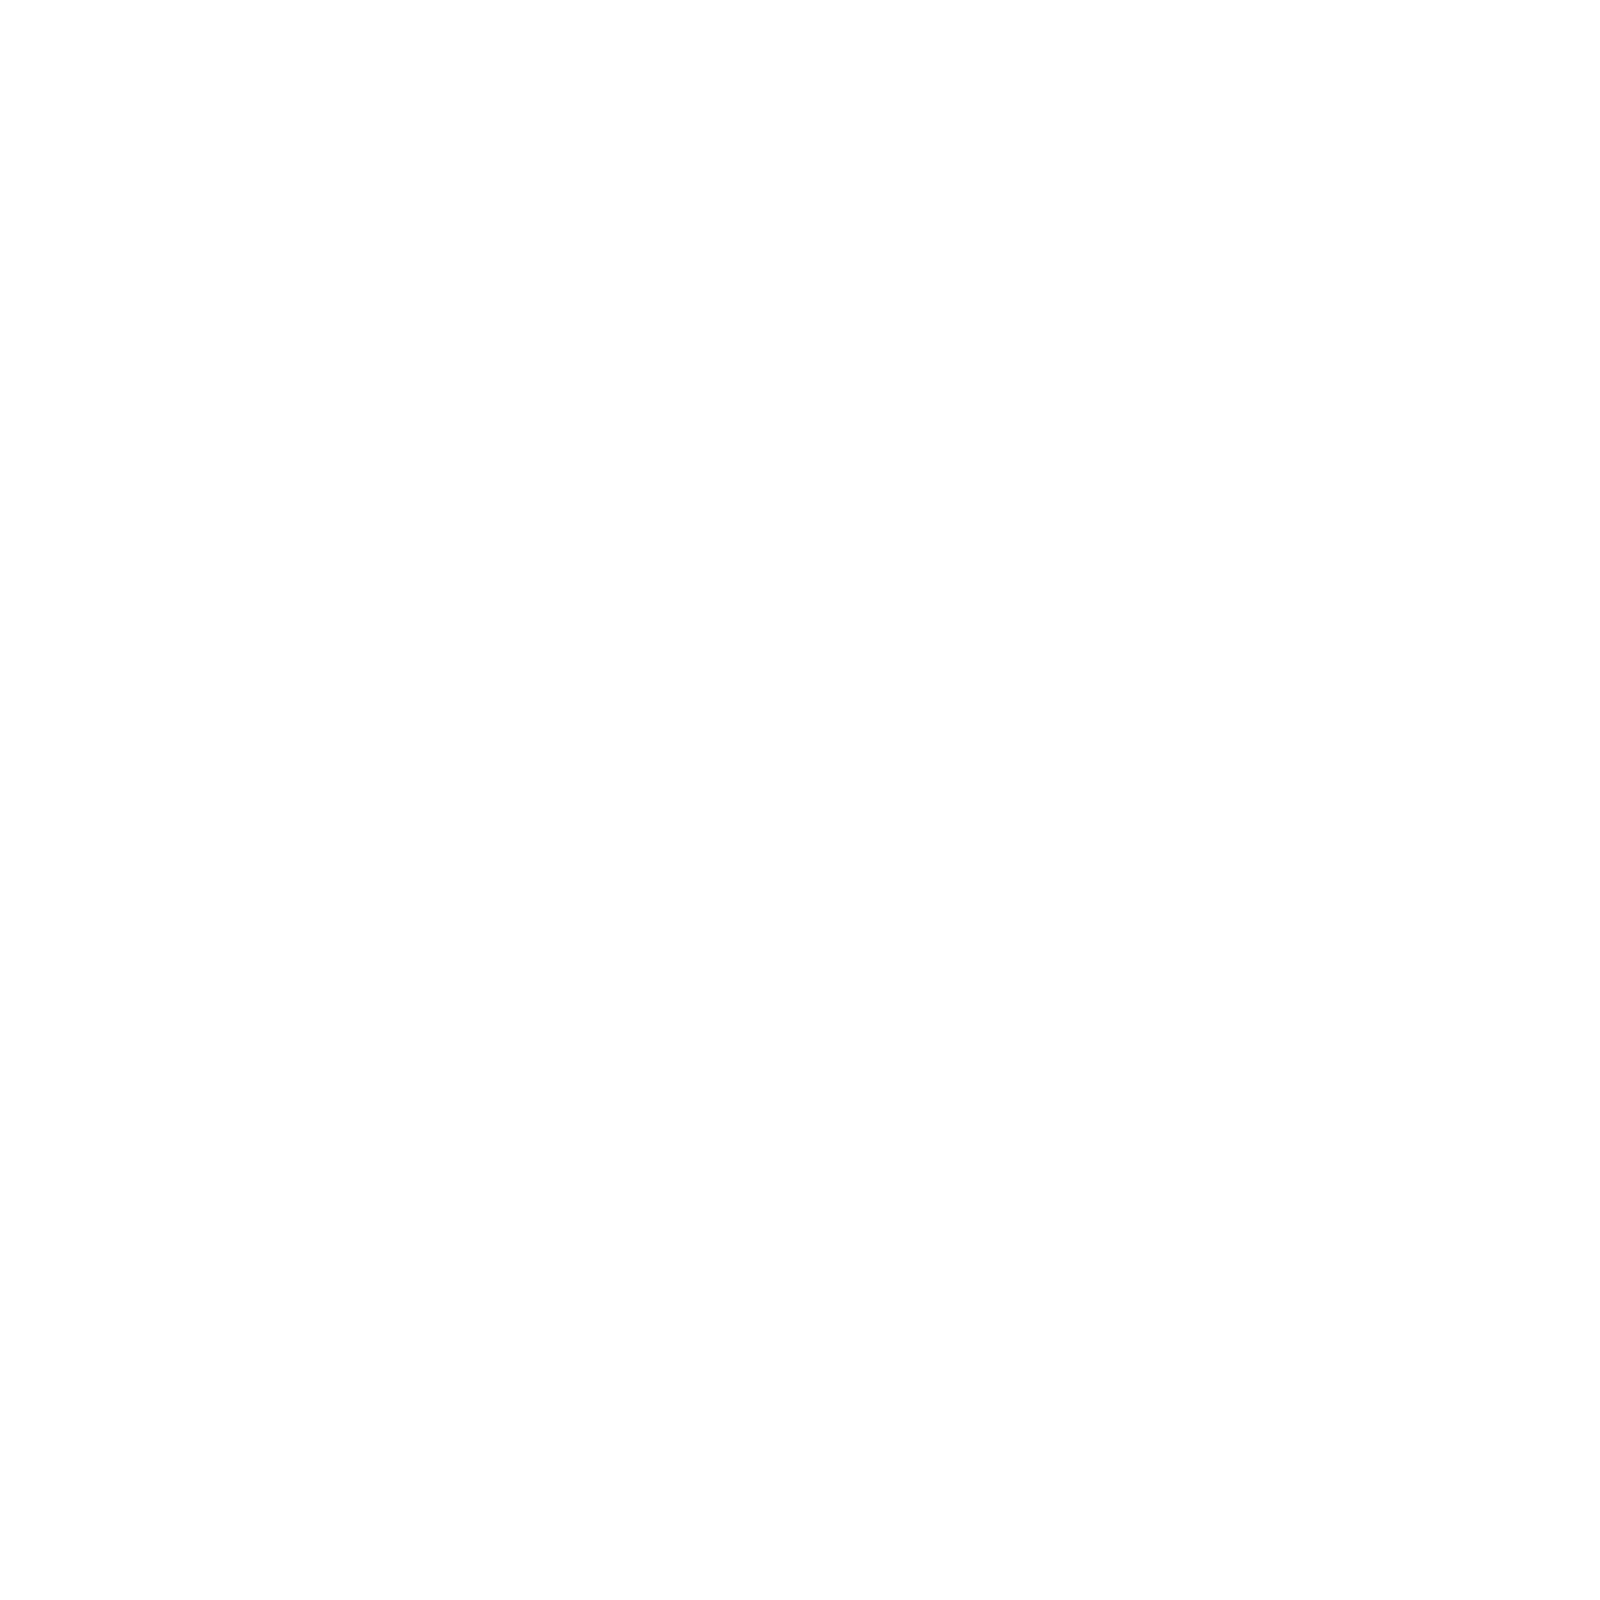

<IPython.core.display.Javascript object>


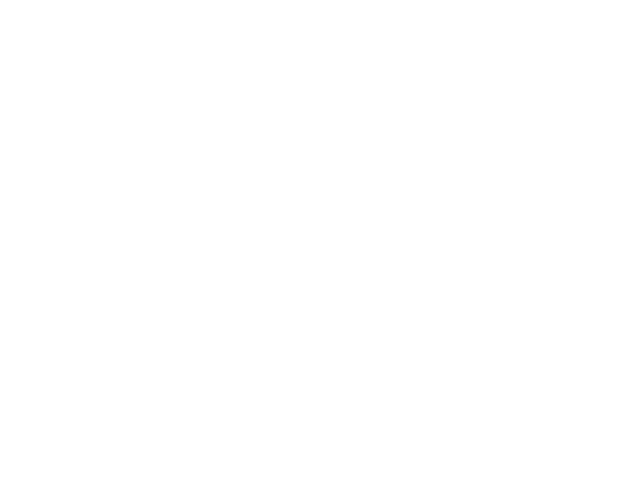

<IPython.core.display.Javascript object>


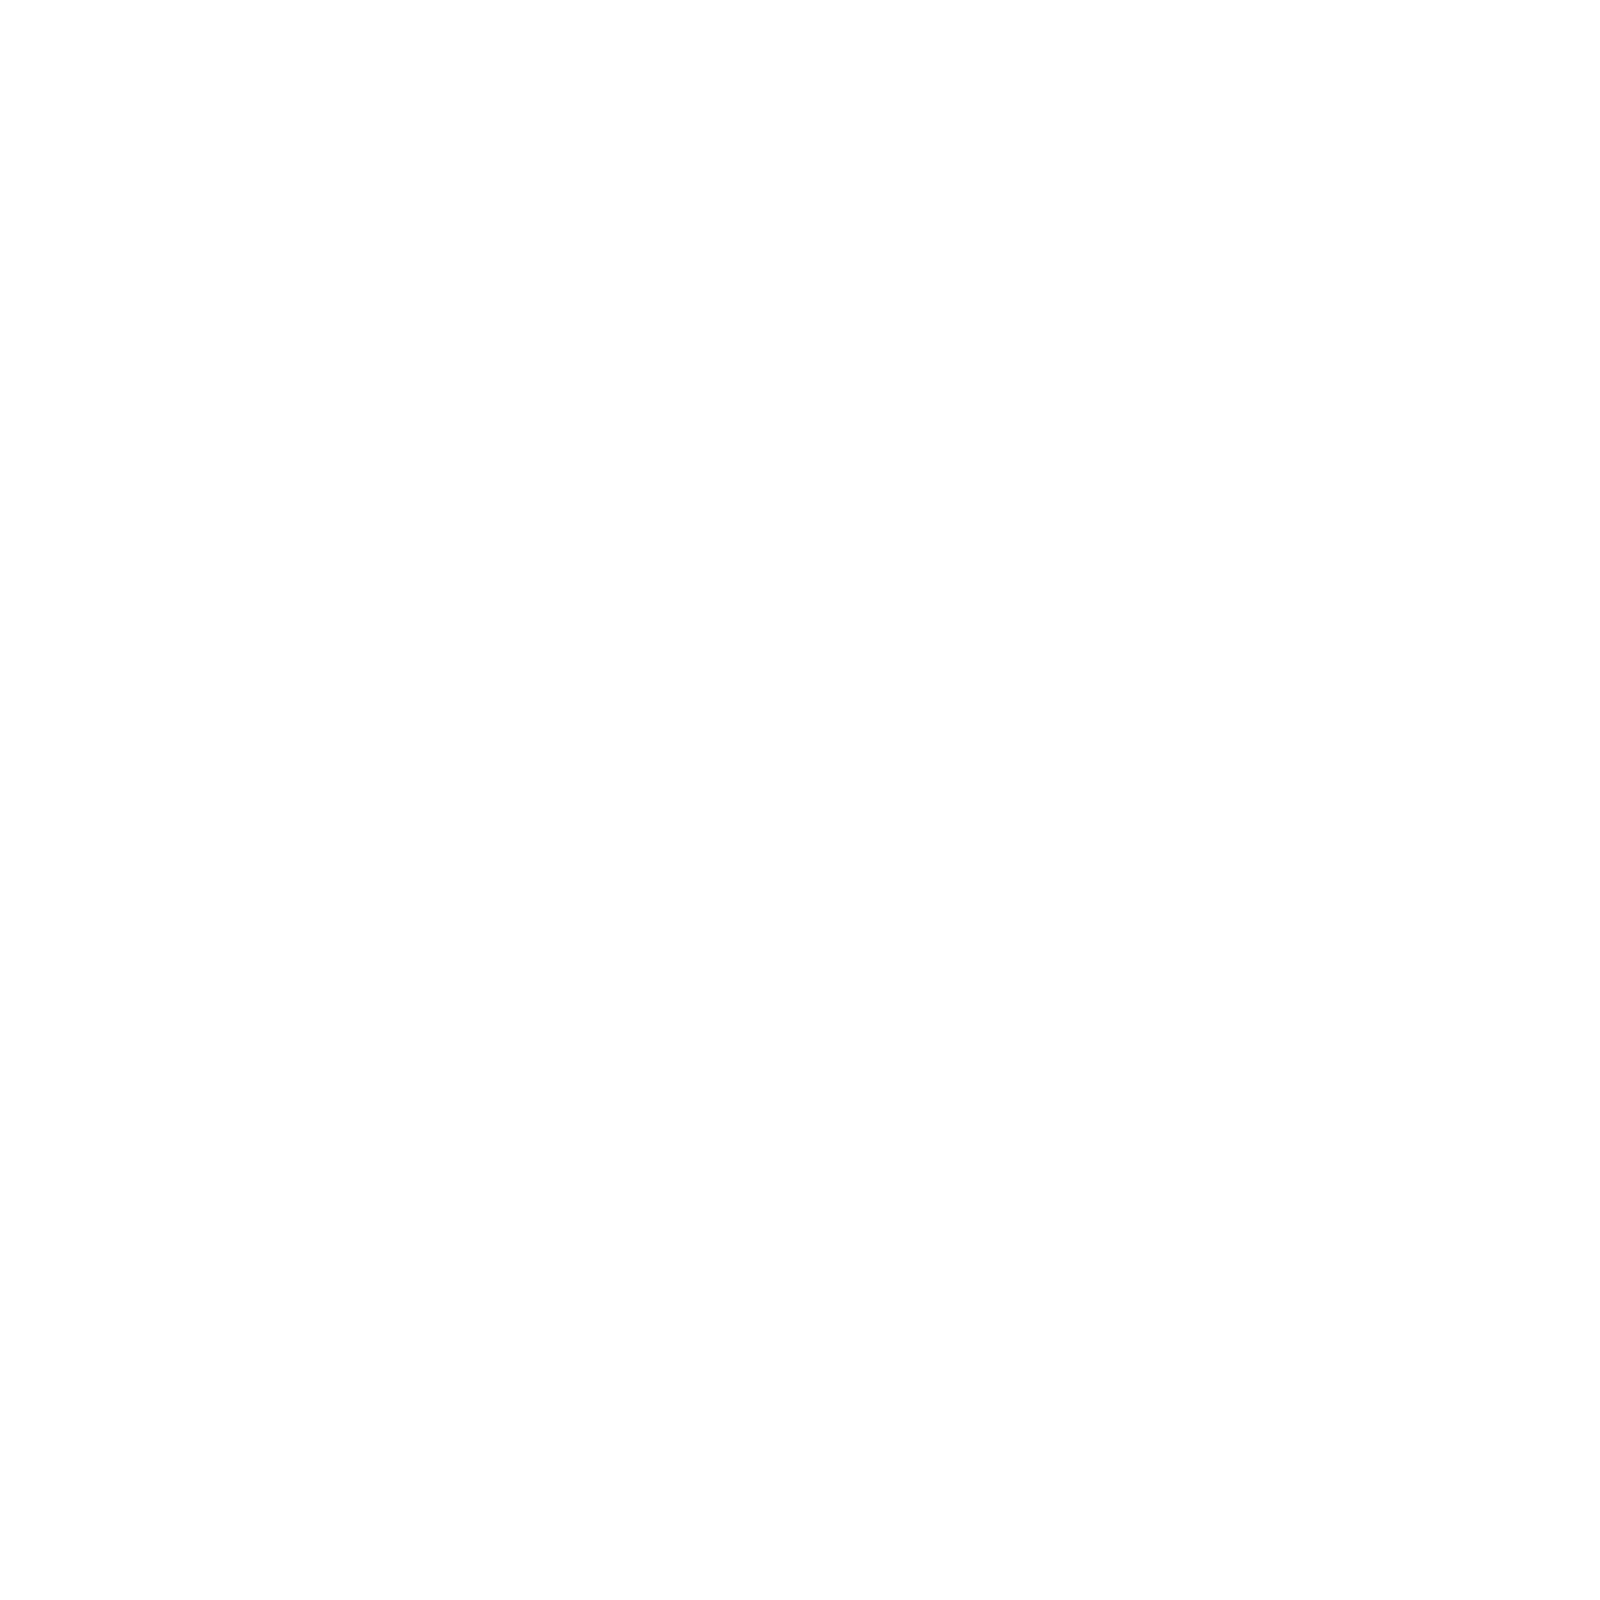

<IPython.core.display.Javascript object>


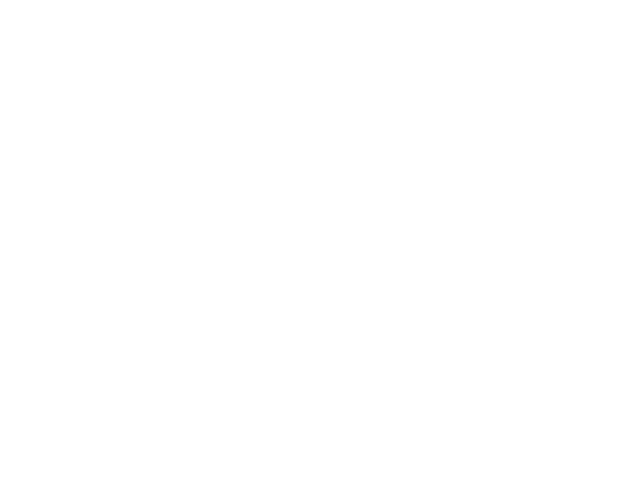

<IPython.core.display.Javascript object>


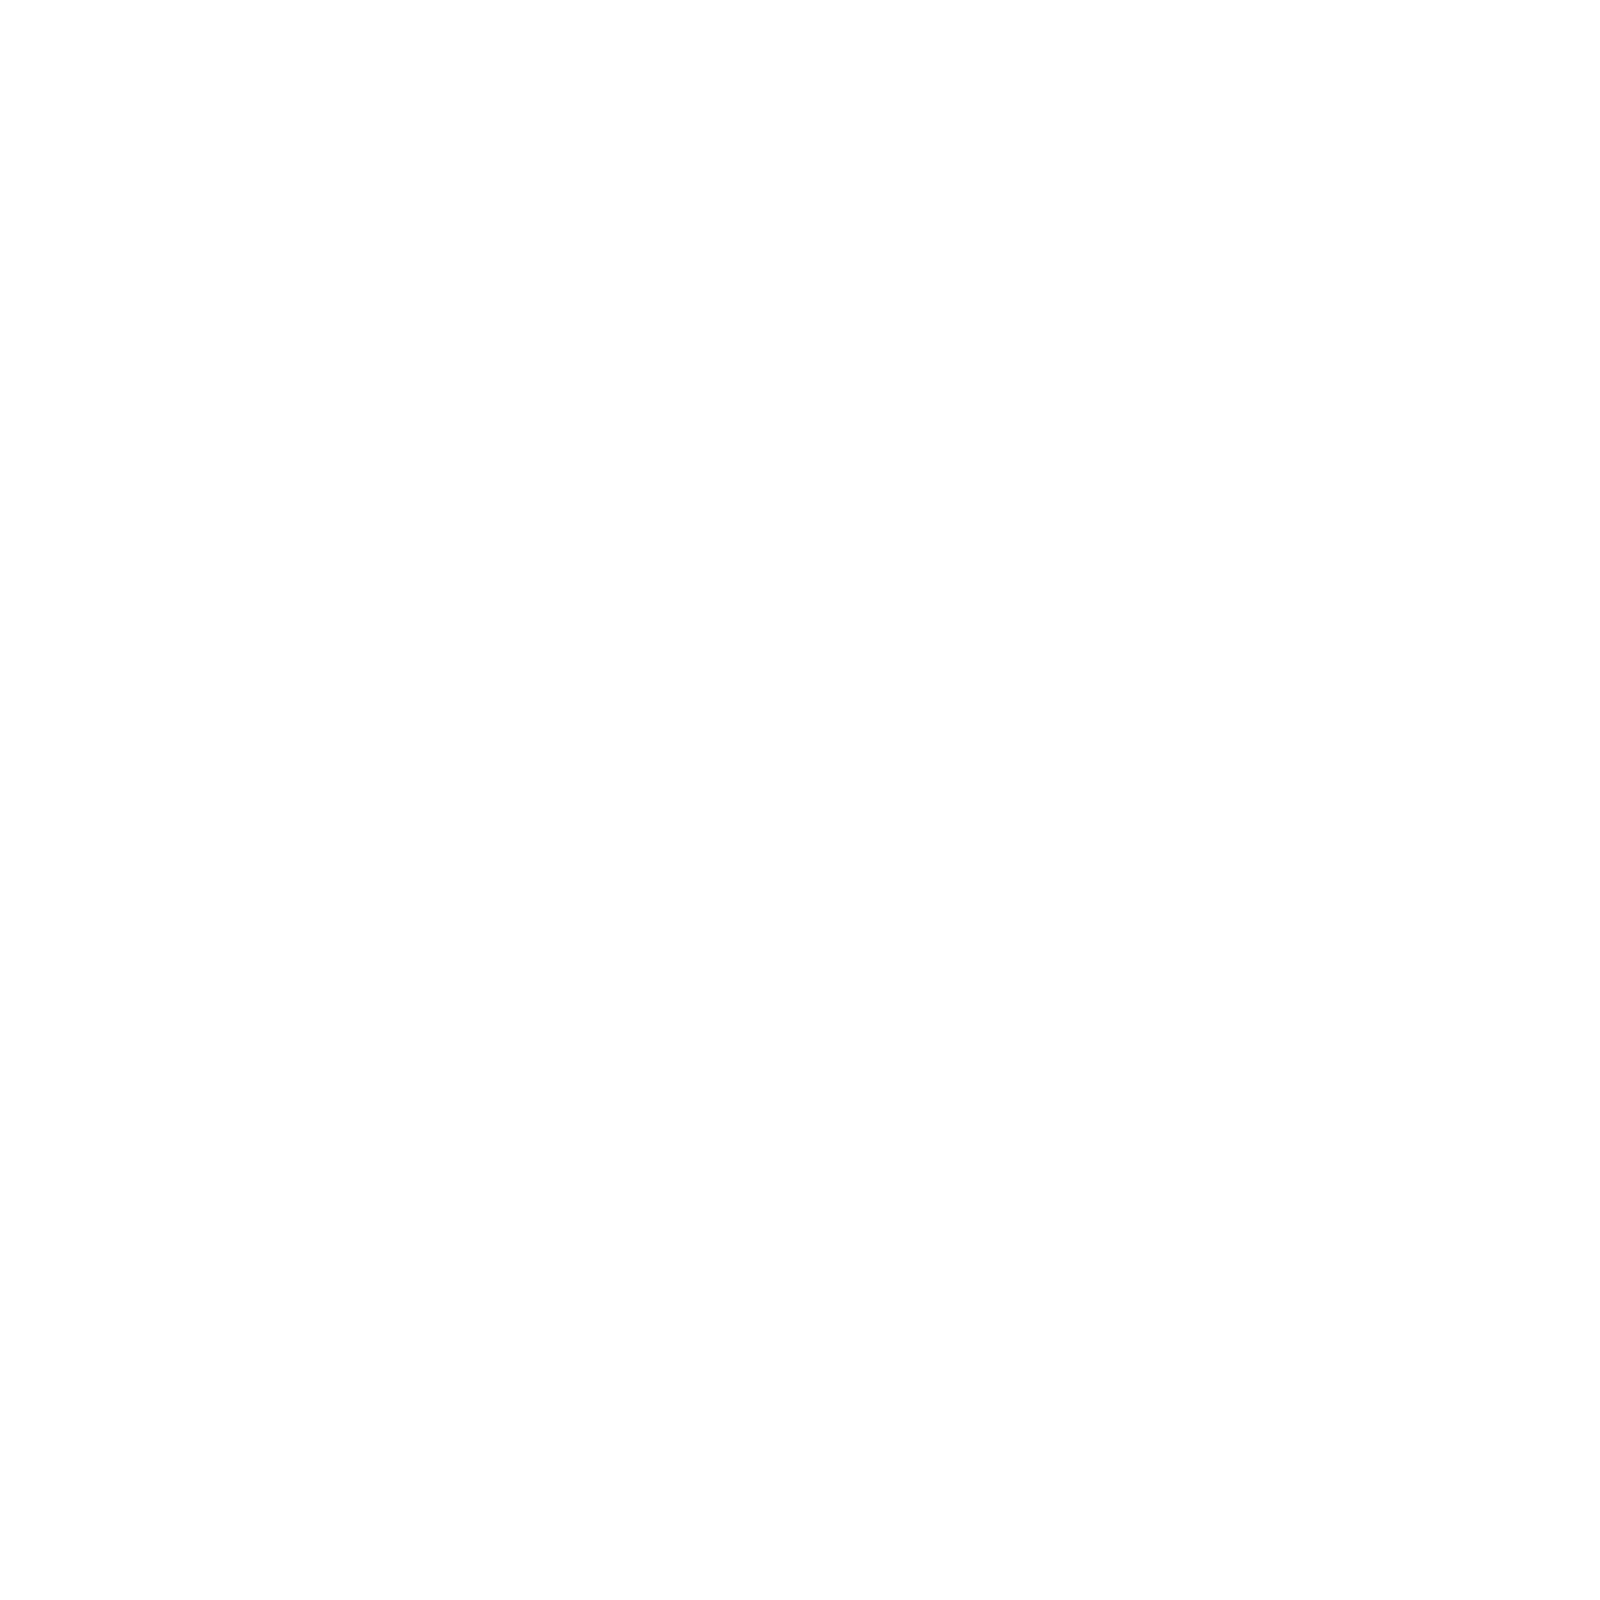

<IPython.core.display.Javascript object>


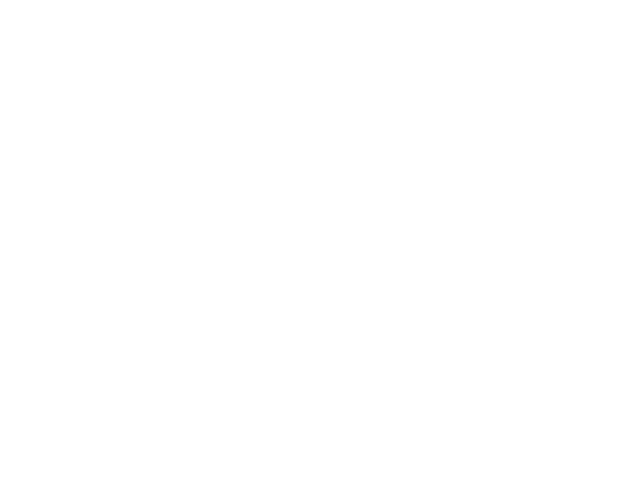

<IPython.core.display.Javascript object>


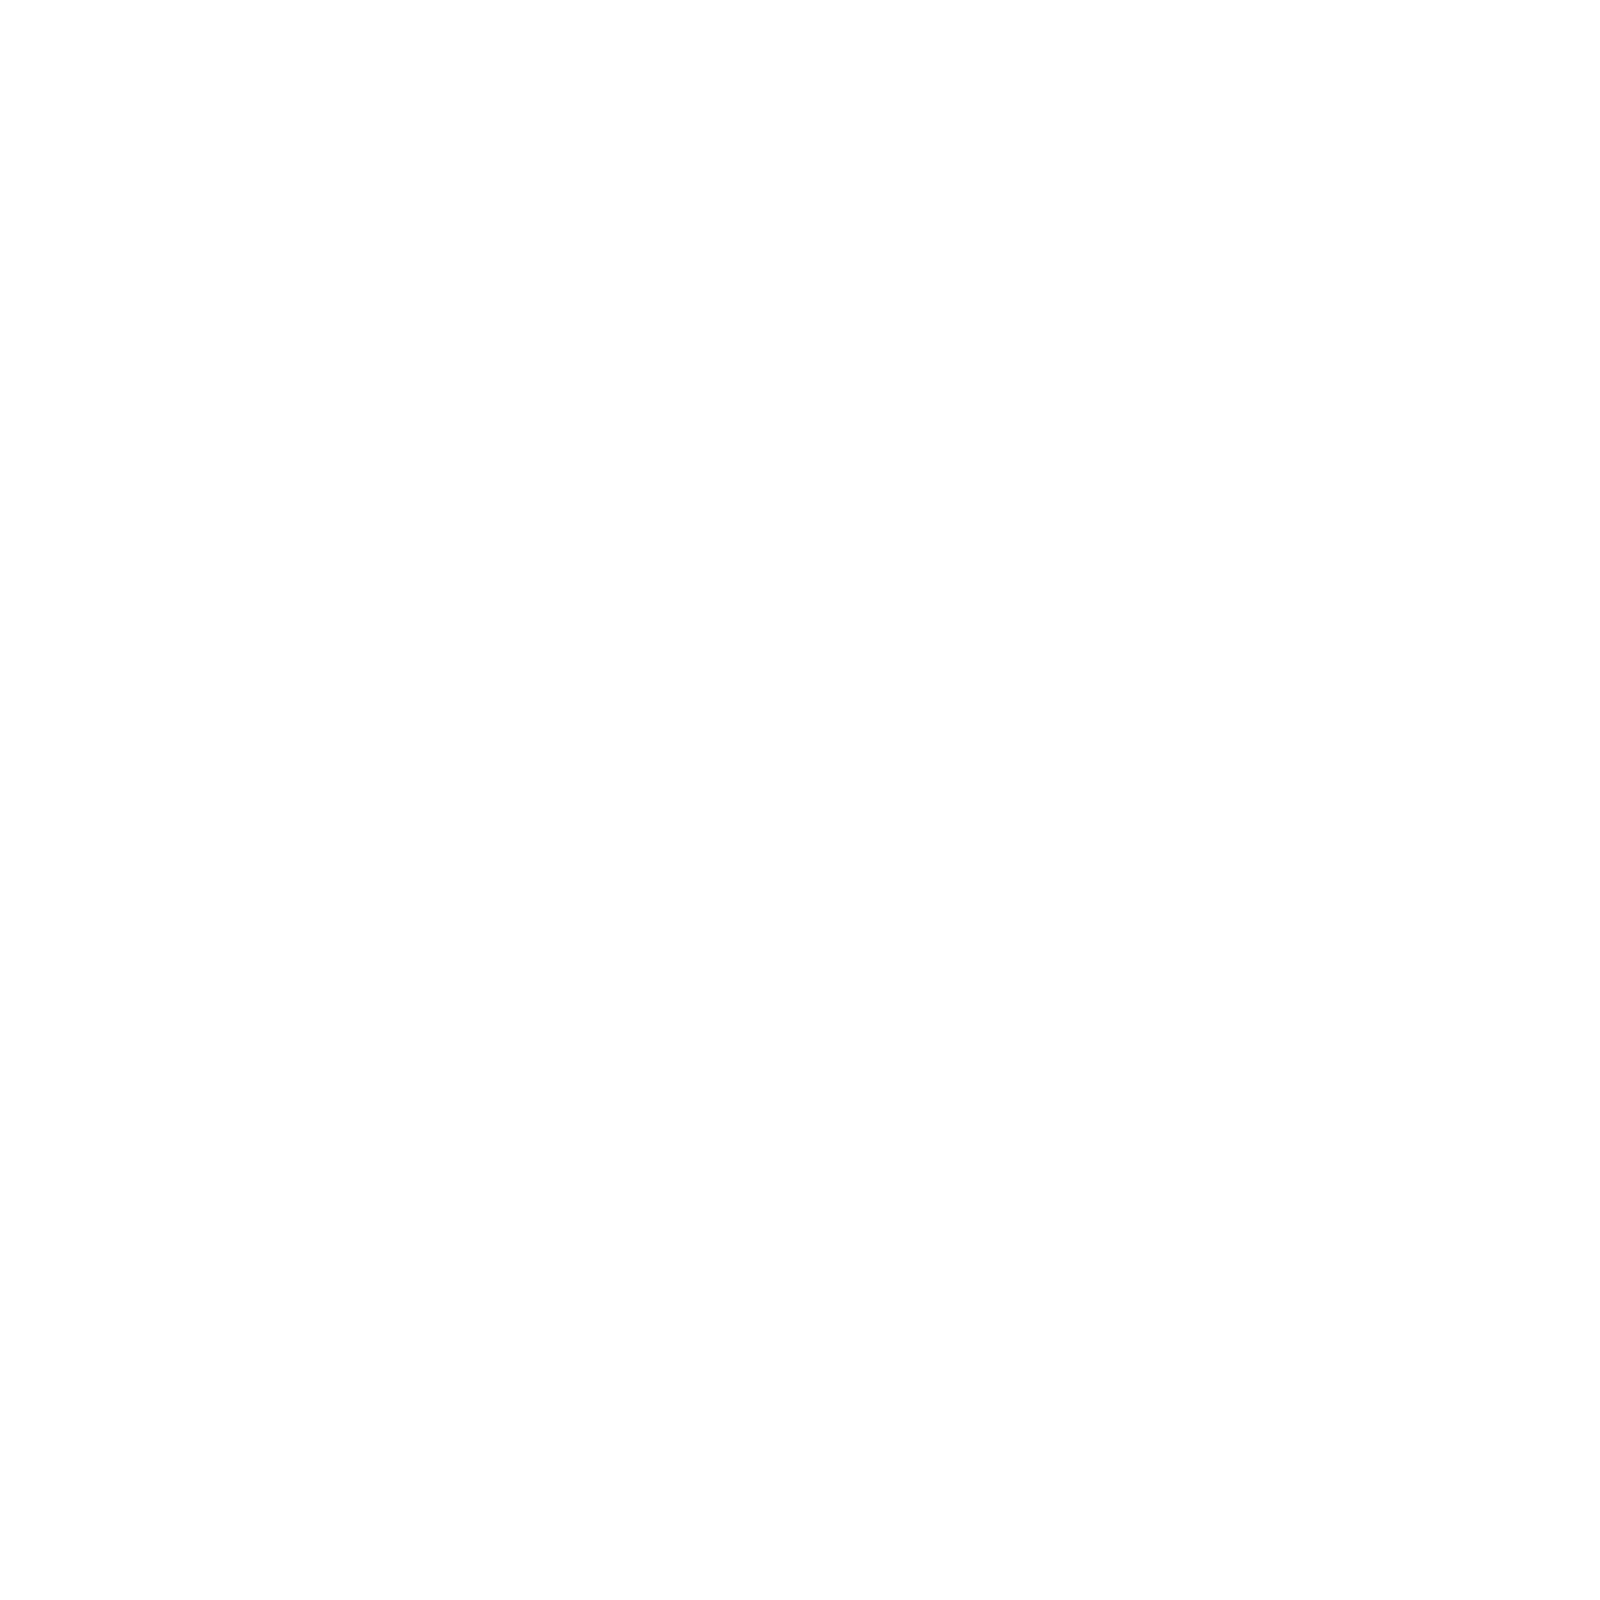

<IPython.core.display.Javascript object>


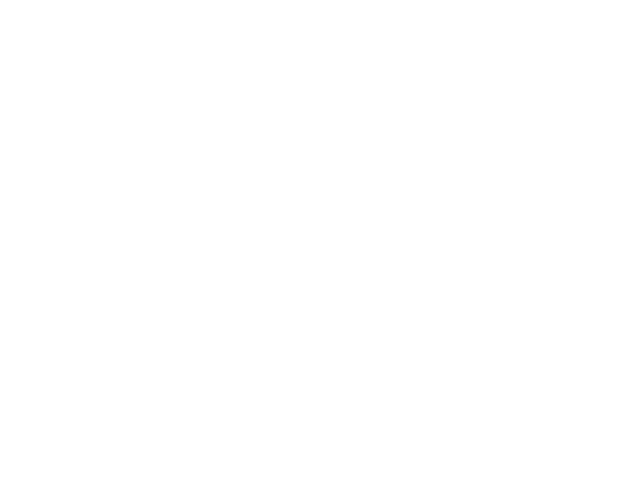

<IPython.core.display.Javascript object>


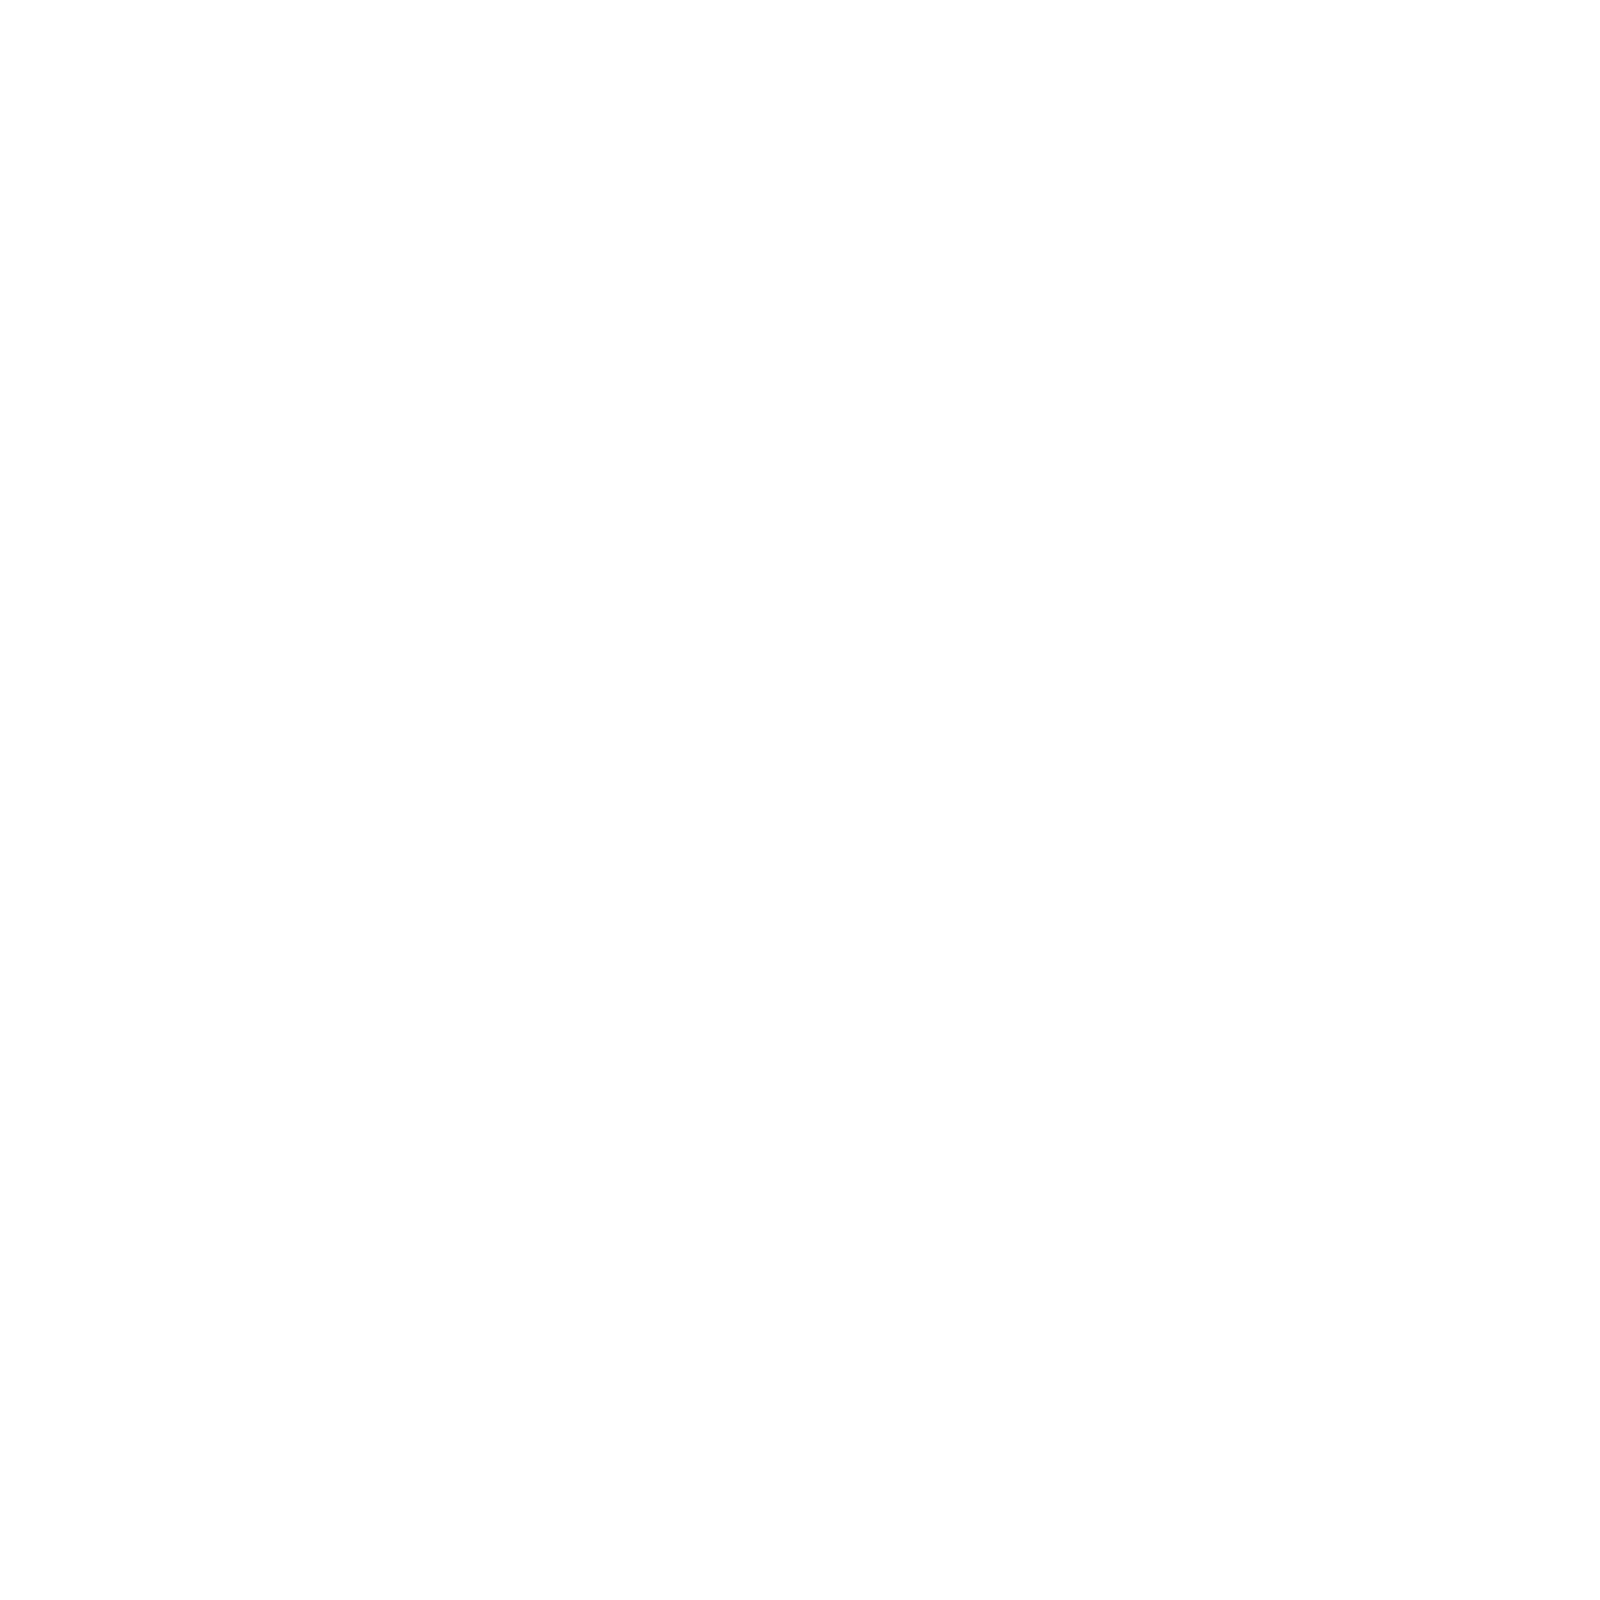

<IPython.core.display.Javascript object>


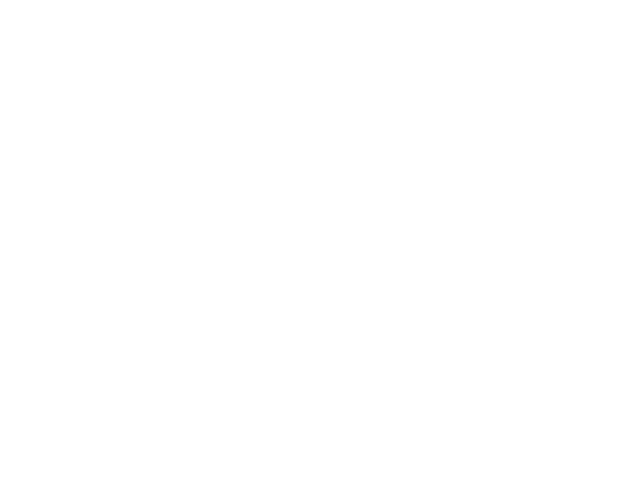

<IPython.core.display.Javascript object>


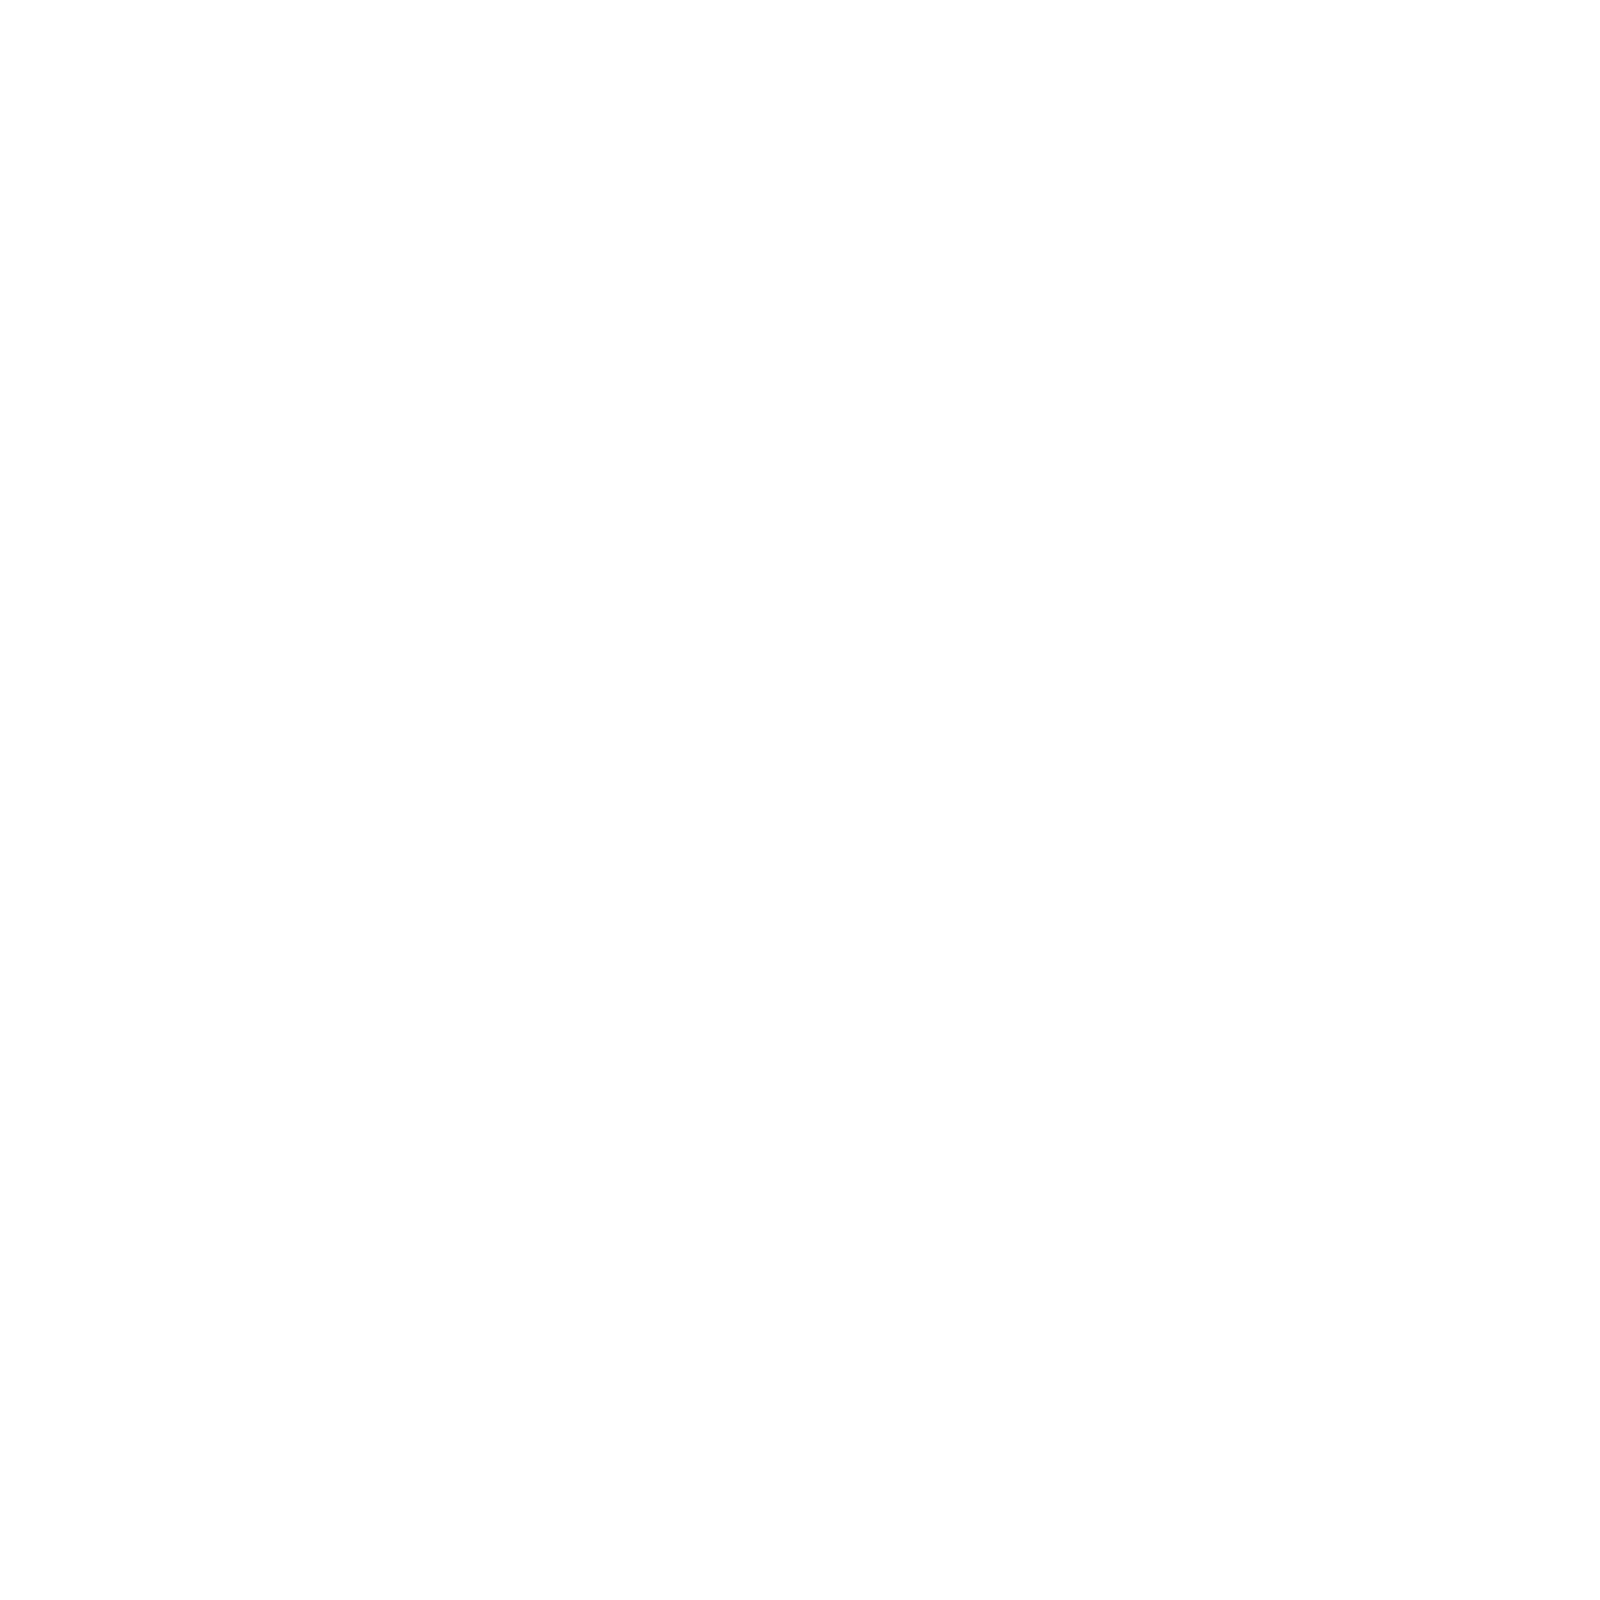

<IPython.core.display.Javascript object>


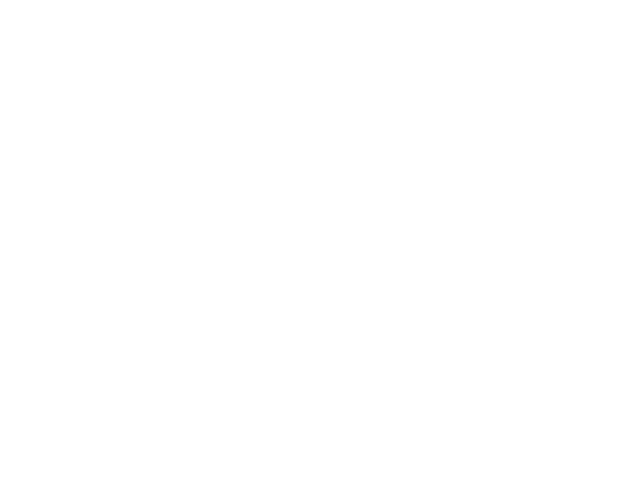

<IPython.core.display.Javascript object>


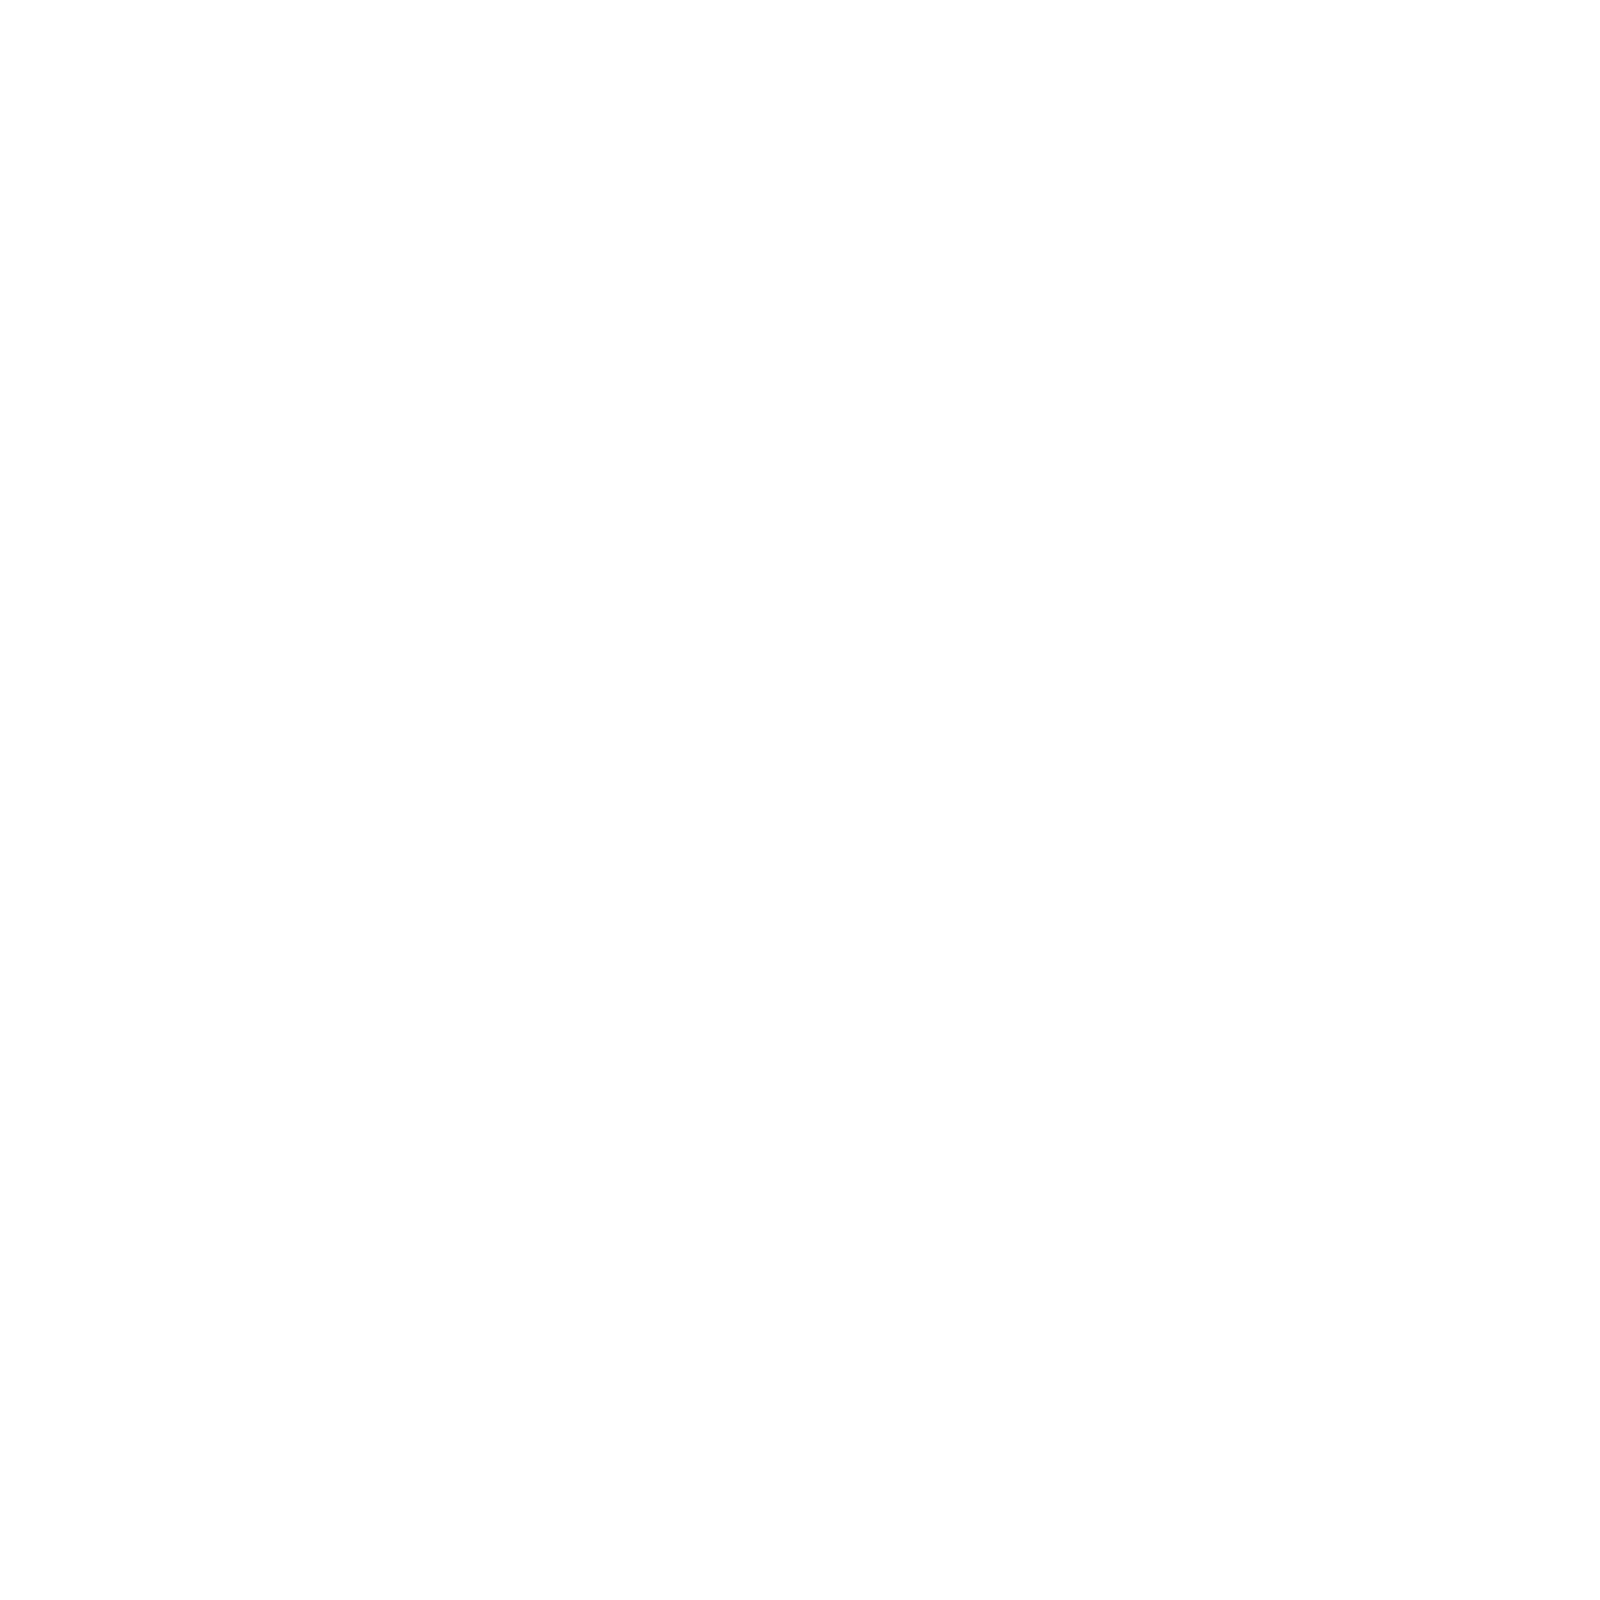

<IPython.core.display.Javascript object>


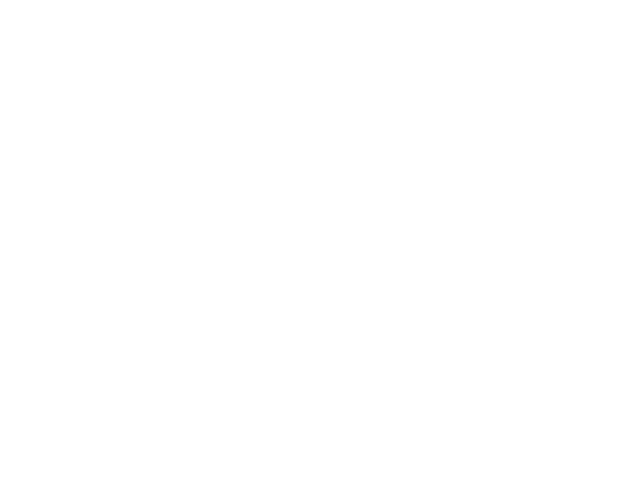

<IPython.core.display.Javascript object>

IndexError: index 197547 is out of bounds for axis 0 with size 190400

In [239]:
for filenum, h5_file in enumerate(chain_files):
    reader = emcee.backends.HDFBackend(h5_file)
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    sn = h5_file.split('/')[-1].split('_')[0]
    name_arr[filenum] = sn
    tau = reader.get_autocorr_time(tol=0)
    if conv_arr[filenum] > 0:
        paramsNames=[r'$t_\mathrm{fl}$', 
         '$a_g$', r"$A'_g$", r'$\alpha_{r, g}$',
         '$a_r$', r"$A'_r$", r'$\alpha_{r, r}$']
        cfig = corner_hack(samples, labels=paramsNames,
                           show_titles=True, quantiles=[.16,.84], title_fmt=".4f",
                           plot_datapoints=True, plot_contours=True)
        cfig.savefig(info_path + '{}_corner.png'.format(h5_file.split('/')[-1].split('_')[0]))

        lc_df = pd.read_hdf(info_path + "{}_force_phot.h5".format(sn))

        g_obs = np.where((lc_df['filter'] == b'g'))
        r_obs = np.where((lc_df['filter'] == b'r'))

        t0 = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
        z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
        g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
        r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

        time_rf = (lc_df['jdobs'].values - t0)/(1+z)
        flux = lc_df['Fratio'].values
        flux[g_obs] = flux[g_obs]/g_max
        flux[r_obs] = flux[r_obs]/r_max
        flux_unc = lc_df['Fratio_unc'].values
        flux_unc[g_obs] = flux_unc[g_obs]/g_max
        flux_unc[r_obs] = flux_unc[r_obs]/r_max
        filt_arr = lc_df['filter'].values

        max_posterior = samples[np.argmax(reader.get_log_prob(discard=burnin, flat=True))]
        haha = plot_both_filt(max_posterior, time_rf, flux, flux_unc, filt_arr, t0=max_posterior[0])
        haha.savefig(info_path + '{}_model_lc.png'.format(sn))
        plt.close('all')

<IPython.core.display.Javascript object>


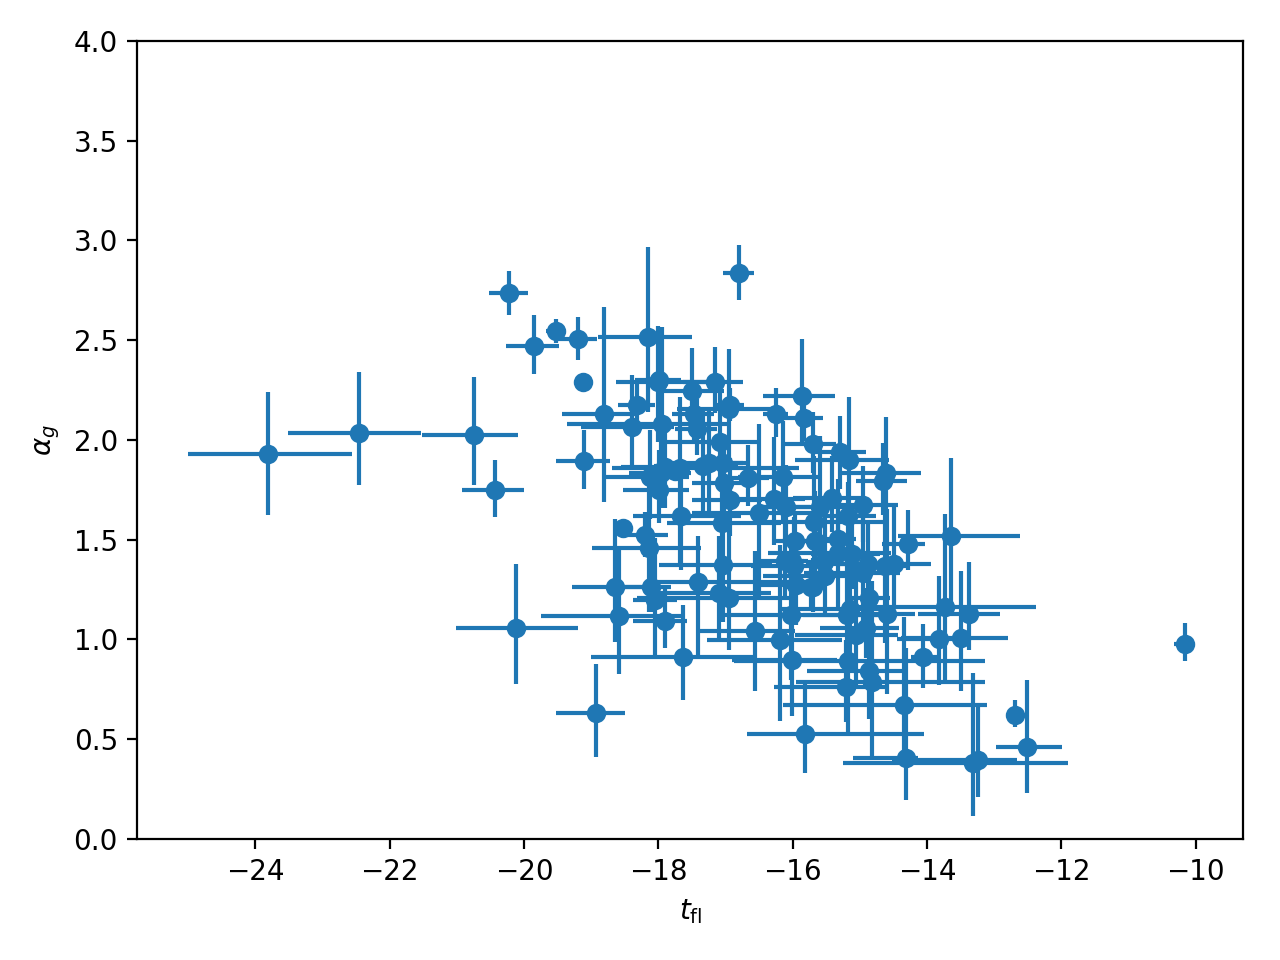

In [219]:
t0 = t0_arr[conv]
t0_unc = np.vstack((t0_arr[conv] - t0_16[conv],t0_84[conv] - t0_arr[conv]))
alpha_g = alpha_g_arr[conv]
alpha_g_unc = np.vstack((alpha_g_arr[conv] - alpha_g_16[conv],alpha_g_84[conv] - alpha_g_arr[conv]))
alpha_r = alpha_r_arr[conv]
alpha_r_unc = np.vstack((alpha_r_arr[conv] - alpha_r_16[conv],alpha_r_84[conv] - alpha_r_arr[conv]))

fig, ax = plt.subplots()

ax.errorbar(t0, alpha_g, yerr=alpha_g_unc, xerr=t0_unc, 
            fmt='o')
ax.set_xlabel(r'$t_\mathrm{fl}$')
ax.set_ylabel(r'$\alpha_g$')
ax.set_ylim(0,4)
fig.tight_layout()

<IPython.core.display.Javascript object>


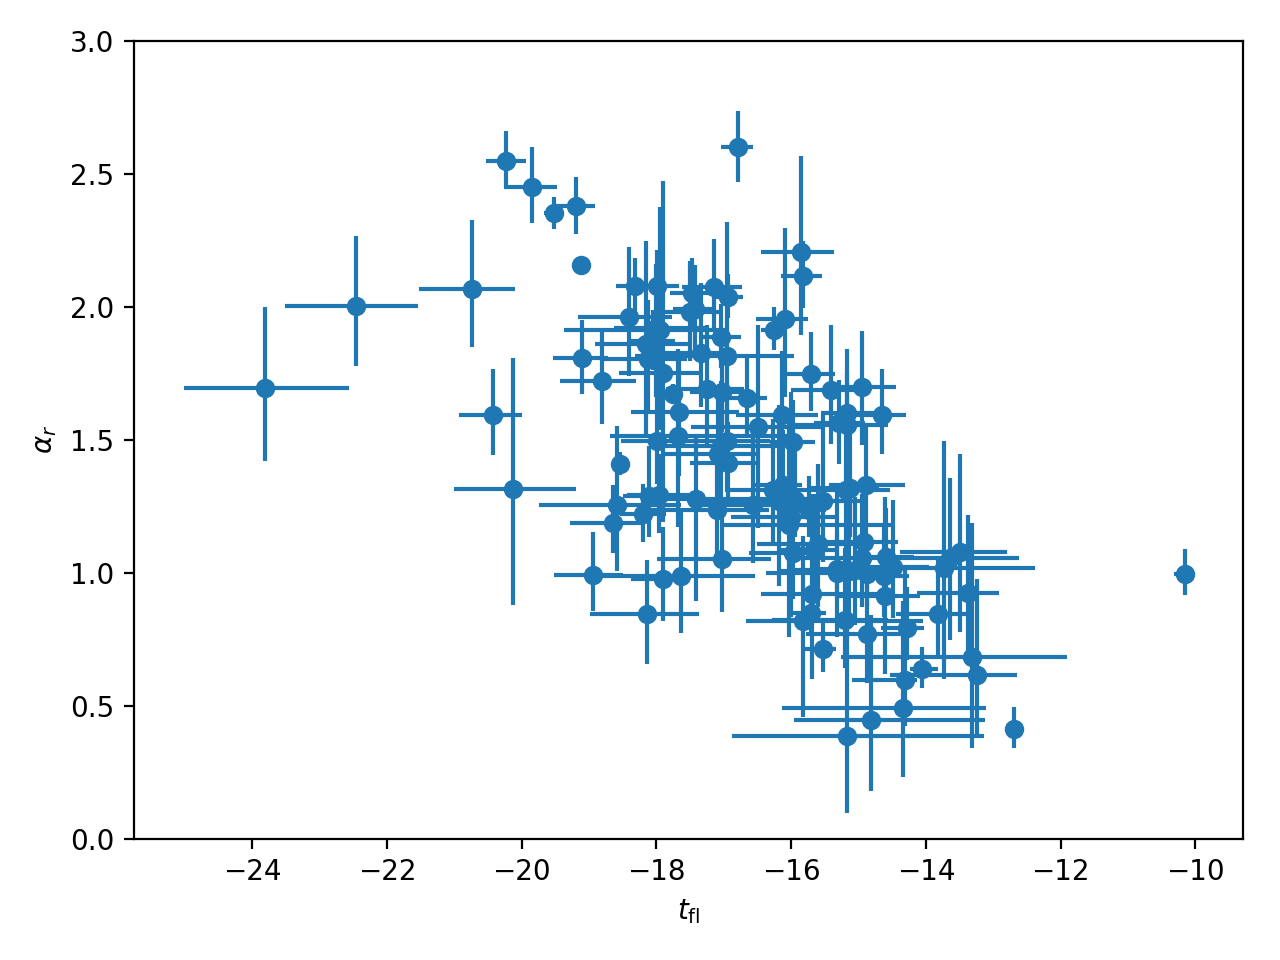

In [222]:
fig, ax = plt.subplots()

ax.errorbar(t0, alpha_r, xerr=t0_unc, yerr=alpha_r_unc,
            fmt='o')
ax.set_xlabel(r'$t_\mathrm{fl}$')
ax.set_ylabel(r'$\alpha_r$')
ax.set_ylim(0,3)
fig.tight_layout()

<IPython.core.display.Javascript object>


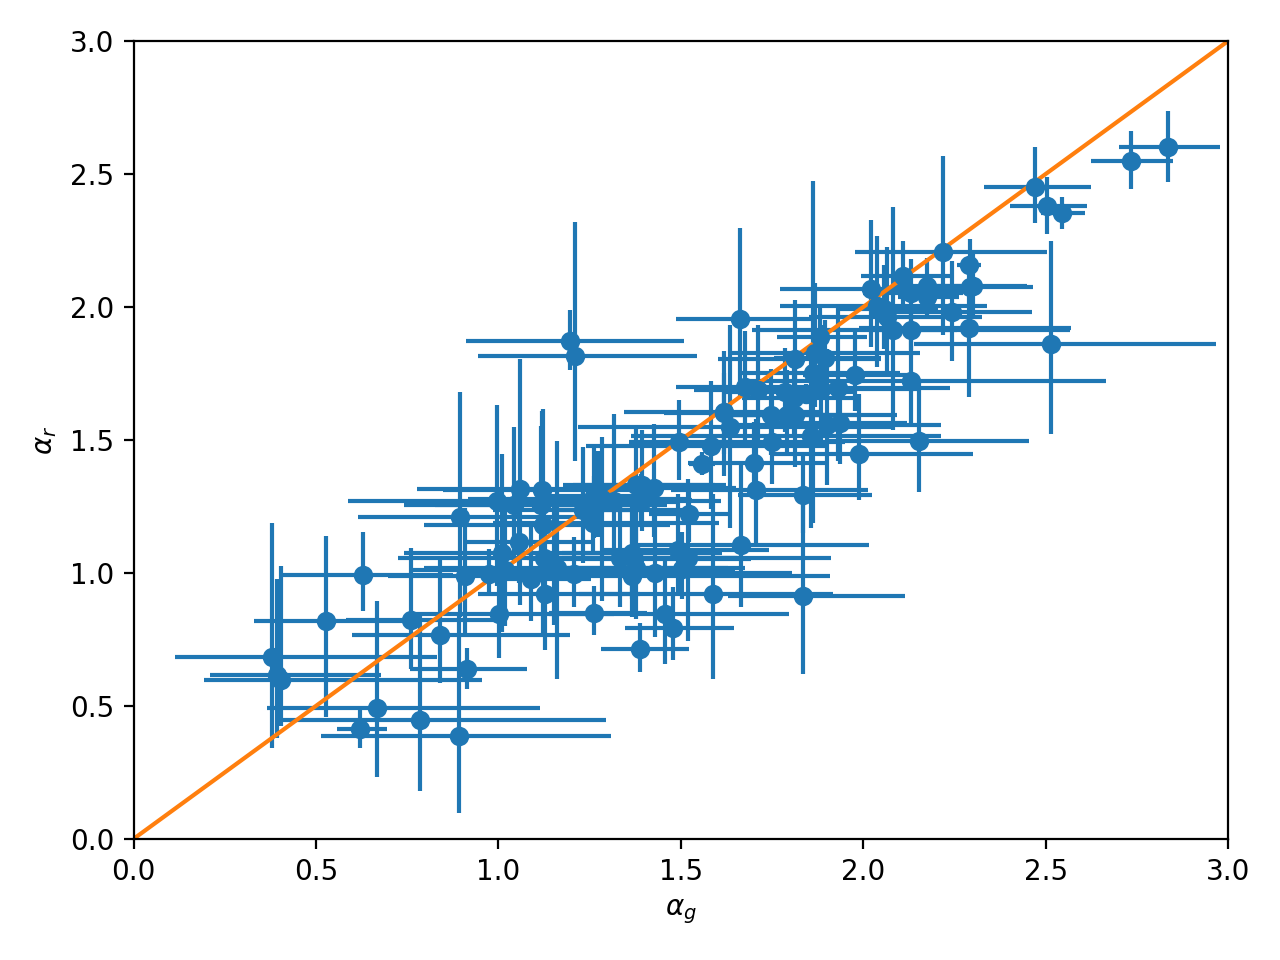

In [225]:
fig, ax = plt.subplots()

ax.errorbar(alpha_g, alpha_r, xerr=alpha_g_unc, yerr=alpha_r_unc,
            fmt='o')
ax.plot([0,3],[0,3])
ax.set_xlabel(r'$\alpha_g$')
ax.set_ylabel(r'$\alpha_r$')
ax.set_ylim(0,3)
ax.set_xlim(0,3)
fig.tight_layout()

<IPython.core.display.Javascript object>


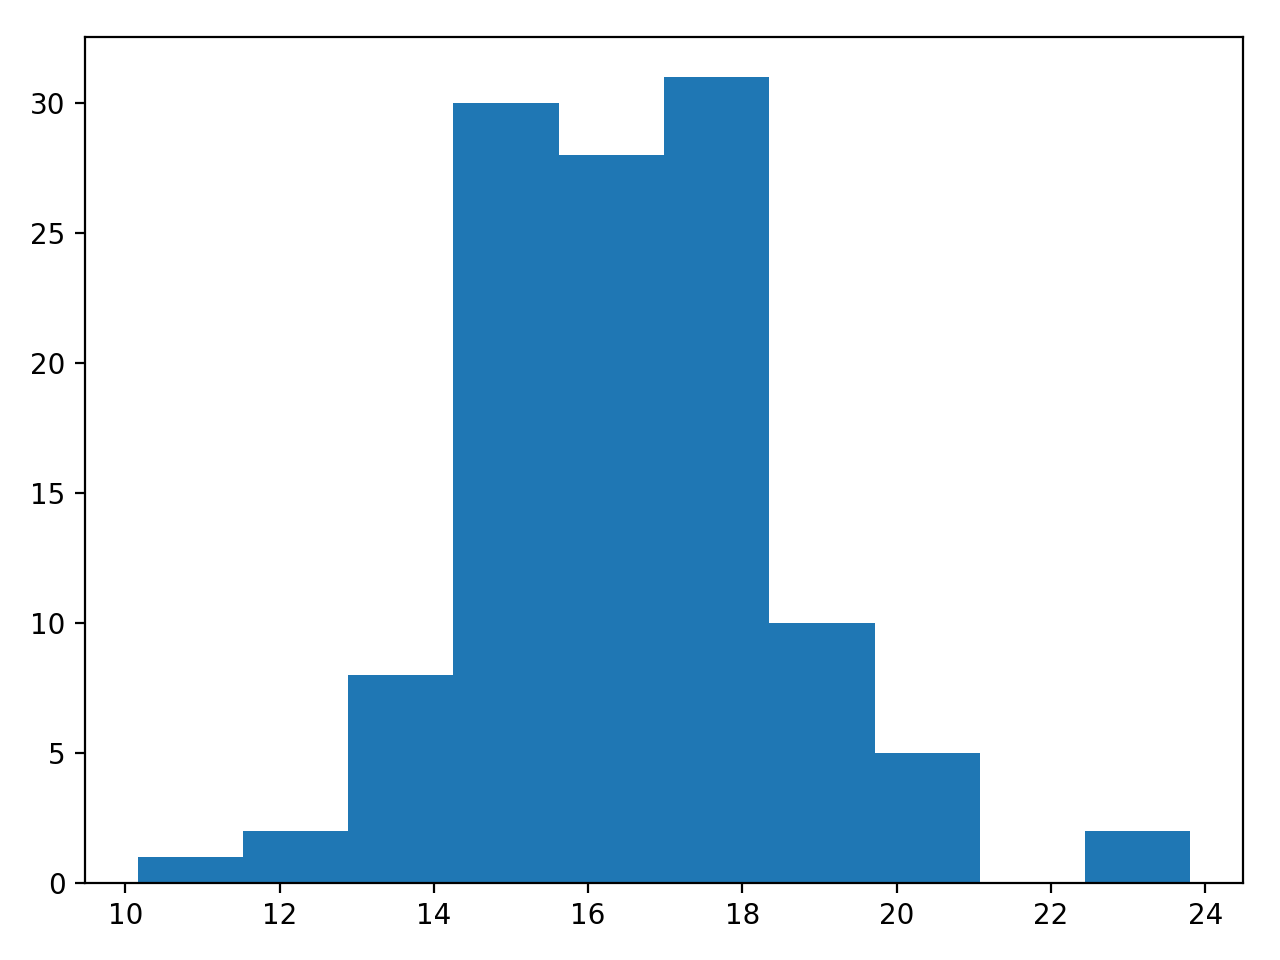

In [227]:
fig, ax = plt.subplots()

ax.hist(-1*t0)
# ax.plot([0,3],[0,3])
# ax.set_xlabel(r'$\alpha_g$')
# ax.set_ylabel(r'$\alpha_r$')
# ax.set_ylim(0,3)
# ax.set_xlim(0,3)
fig.tight_layout()

array([-1.36071771e+01, -1.25903394e-03,  3.58389136e-02,  1.48645706e+00,
        2.66018590e-03,  7.79542409e-02,  9.63364391e-01])

In [120]:
sn = h5_file.split('/')[-1].split('_')[0]
lc_df = pd.read_hdf(info_path + "{}_force_phot.h5".format(sn))

g_obs = np.where((lc_df['filter'] == b'g'))
r_obs = np.where((lc_df['filter'] == b'r'))

t0 = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)



time_rf = (lc_df['jdobs'].values - t0)/(1+z)
flux = lc_df['Fratio'].values
flux[g_obs] = flux[g_obs]/g_max
flux[r_obs] = flux[r_obs]/r_max
flux_unc = lc_df['Fratio_unc'].values
flux_unc[g_obs] = flux_unc[g_obs]/g_max
flux_unc[r_obs] = flux_unc[r_obs]/r_max
filt_arr = lc_df['filter'].values


max_posterior = samples[np.argmax(reader.get_log_prob(flat=True))]

In [158]:
early_g = np.where((time_rf[g_obs] < 0) & (flux[g_obs] < 0.5))
early_r = np.where((time_rf[r_obs] < 0) & (flux[r_obs] < 0.5))
print(g_obs[0][early_g])
print(r_obs[0][early_r])
early_obs = np.append(g_obs[0][early_g], r_obs[0][early_r])
early_obs

[ 22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  55  56  57  58  61  62  63
  68  69  72  73  74  78  80  81  82  87  88  89  90 100 101 102 105 109
 110 113 114 115 116 122 123 124 125 126 128 131 132 133 134 139 140 145
 146 147 152 153 154 155 159 160 164 172 173 174 176 177 178 185 186 187
 188 191 192 193 196 197 198 202 206 207 208 219 220 221 222 223 224 225]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  51  52  53  54  59  60  64  65  66  67  70  71  75  76
  77  79  83  84  85  86  91  92  93  94  95  96  97  98  99 103 104 106
 107 108 111 112 117 118 119 120 121 127 129 130 135 136 137 138 141 142
 143 144 148 149 150 151 156 157 158 161 162 163 165 166 167 168 169 170
 171 175 179 180 181 182 183 184 189 190 194 195 199 200 201 203 204 205
 209 210 211 212 213 214 215 216 217 218 226 227 228 230]


array([ 22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  55,  56,  57,  58,  61,  62,  63,  68,  69,  72,
        73,  74,  78,  80,  81,  82,  87,  88,  89,  90, 100, 101, 102,
       105, 109, 110, 113, 114, 115, 116, 122, 123, 124, 125, 126, 128,
       131, 132, 133, 134, 139, 140, 145, 146, 147, 152, 153, 154, 155,
       159, 160, 164, 172, 173, 174, 176, 177, 178, 185, 186, 187, 188,
       191, 192, 193, 196, 197, 198, 202, 206, 207, 208, 219, 220, 221,
       222, 223, 224, 225,   0,   1,   2,   3,   4,   5,   6,   7,   8,
         9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
        51,  52,  53,  54,  59,  60,  64,  65,  66,  67,  70,  71,  75,
        76,  77,  79,  83,  84,  85,  86,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 103, 104, 106, 107, 108, 111, 112, 117, 118, 119,
       120, 121, 127, 129, 130, 135, 136, 137, 138, 141, 142, 14

<IPython.core.display.Javascript object>


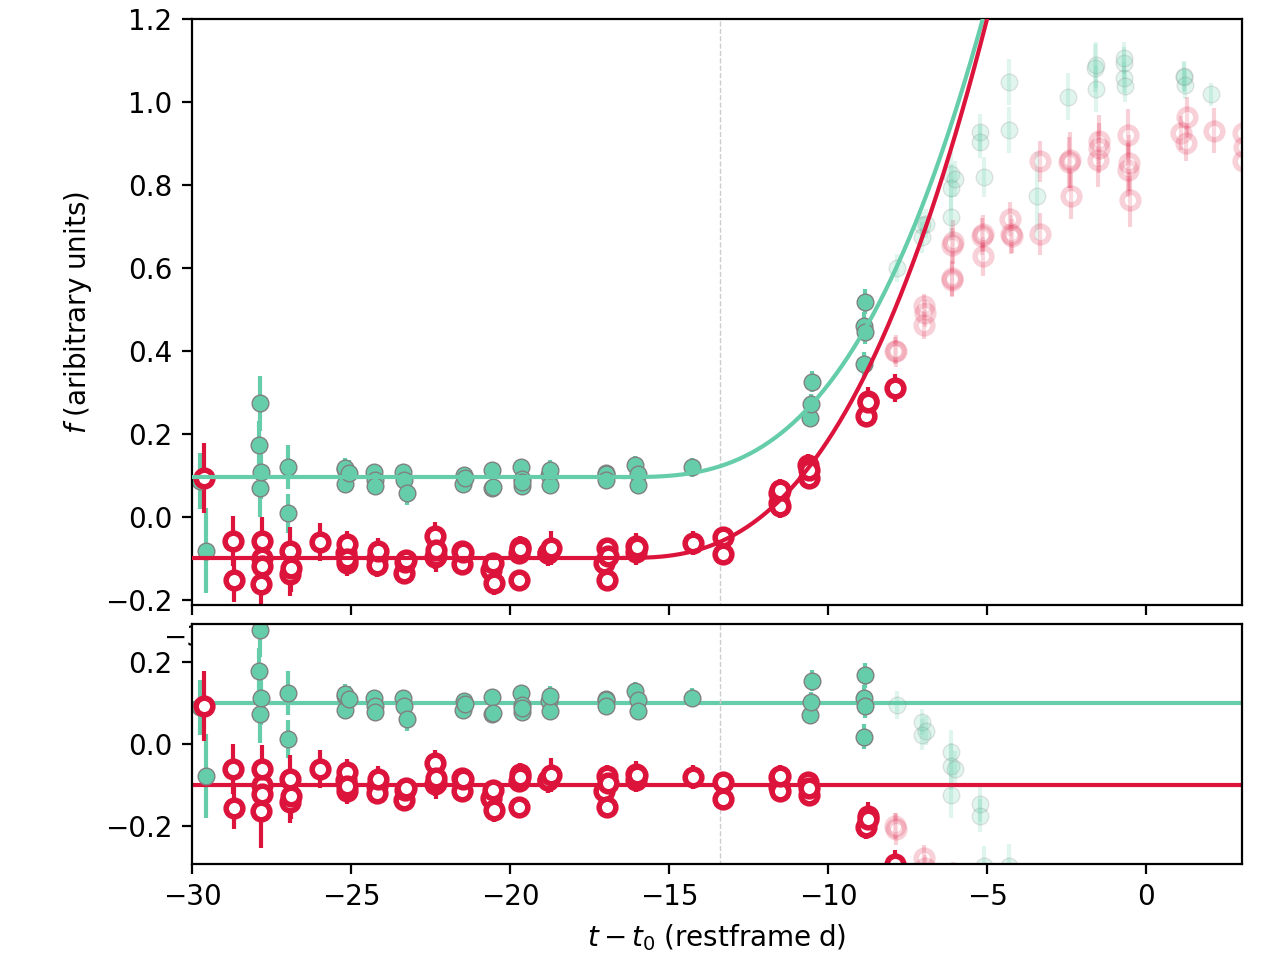

In [189]:
haha = plot_both_filt(max_posterior, time_rf, flux, flux_unc, filt_arr, t0=t0_arr[-1])
haha.savefig('{}_model_lc.png'.format(sn))

In [188]:
def f_t(times, amplitude=25, t_0=0, alpha_r=2):
    
    return amplitude * (times - t_0)**alpha_r

def plot_both_filt(theta, t, f, f_unc, filt_arr,
                   t0=-18):

    color_dict = {b'r': 'Crimson',
                  b'g': 'MediumAquaMarine'}
    offset_dict = {b'r': -0.1,
                  b'g': 0.1}
    mark_color_dict = {b'r': 'white',
                  b'g': 'MediumAquaMarine'}
    sym_dict = {b'r': 'o',
                b'g': 'o'}
    mec_dict = {b'r': 'Crimson',
                b'g': '0.5'}
    mew_dict = {b'r': 2,
                b'g': 0.5}
    
    if len(theta) % 3 != 1:
        raise RuntimeError('The correct number of parameters were not included')

    fig = plt.figure()
    axPlot = plt.axes([0.15, 0.37, 0.82, 0.61])
    axRes = plt.axes([0.15, 0.1, 0.82, 0.25], sharex=axPlot)

    for filt_num, filt in enumerate(np.unique(filt_arr)):
        theta_filt = np.append(theta[0], theta[1+3*filt_num:4+3*filt_num])
        filt_obs = np.where(filt_arr == filt)
        f_filt = f[filt_obs]
        t_filt = t[filt_obs]
        f_err_filt = f_unc[filt_obs]

        half_max = ((f_filt < 0.5) & (t_filt < 0))

    
        t_post = np.linspace(theta[0], 80, 1000)
        t_pre = np.linspace(min(t_filt), theta[0], 1000)
        model_flux = theta_filt[1] + f_t(t_post, theta_filt[2], theta_filt[0], theta_filt[3])

        axPlot.errorbar(t_filt[half_max], f_filt[half_max] + offset_dict[filt], f_err_filt[half_max],
                    fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                    mec=mec_dict[filt], mew=mew_dict[filt])
        axPlot.errorbar(t_filt[~half_max], f_filt[~half_max] + offset_dict[filt], f_err_filt[~half_max],
                    fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                    mec=mec_dict[filt], mew=mew_dict[filt], alpha=0.2)
        axPlot.plot(t_post, model_flux + offset_dict[filt], color=color_dict[filt], zorder=10)
        axPlot.plot(t_pre, np.ones_like(t_pre)*theta_filt[1] + offset_dict[filt], color=color_dict[filt], zorder=10)
#         axPlot.plot([max(t_filt[half_max]),max(t_filt[half_max])], [-50,50], 
#                    '--', color=color_dict[filt])
        axPlot.set_xlim(-30, 3)
        axPlot.set_ylim(min(f_filt[half_max])-0.15, 1.2)
#         axPlot.set_xticklabels([])

        after_exp = t_filt >= theta_filt[0]

        residuals = np.append(f_filt[~after_exp] - theta_filt[1], 
                              f_filt[after_exp] - (theta_filt[1] + f_t(t_filt[after_exp], theta_filt[2], theta_filt[0], theta_filt[3]))  
                             )

        axRes.errorbar(t_filt[half_max], residuals[half_max] + offset_dict[filt], f_err_filt[half_max],
                       fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                       mec=mec_dict[filt], mew=mew_dict[filt])
        axRes.errorbar(t_filt[~half_max], residuals[~half_max] + offset_dict[filt], f_err_filt[~half_max],
                       fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                       mec=mec_dict[filt], mew=mew_dict[filt], alpha=0.2)
        axRes.plot([-5000,10000], [offset_dict[filt], offset_dict[filt]], '-', color=color_dict[filt])
#         axRes.plot([max(t_filt[half_max]),max(t_filt[half_max])], [-50,50], 
#                    '--', color=color_dict[filt])
        axRes.set_xlim(-30, 3)
        axRes.set_ylim(min(residuals[half_max]) - 0.1, max(residuals[half_max]) + 0.1)
        axRes.set_xlabel('$t - t_0 \; (\mathrm{restframe \; d})$')
        axPlot.set_ylabel('$f \; (\mathrm{aribitrary \; units})$')

    if t0 != -18:
        axPlot.plot([t0,t0], [-50,50], 
               '--', color='0.8', lw=0.5)
        axRes.plot([t0,t0], [-50,50], 
               '--', color='0.8', lw=0.5)

    return fig

In [212]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84], truths=[]):
    samples = sampler.get_chain(discard=nburn, flat=True)
    if len(truths) > 0:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          truths=truths, plot_datapoints=False)
    else:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          show_titles=True, plot_datapoints=False)
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames, nplot=nwalkers):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams+1,1, figsize = (8,2*(Nparams+1)), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = np.arange(sampler.get_chain().shape[0])

    selected_walkers = np.random.choice(range(sampler.get_chain().shape[1]), nplot, replace=False)
    for i,p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn], sampler.get_chain()[:nburn,w,i], 
                              alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.get_chain(discard=nburn)[:,w,i], 
                       color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            if i==Nparams-1:
                ax[i+1].plot(xplot[:nburn], sampler.get_log_prob()[:nburn,w], 
                             color=burn[0].get_color(), alpha = 0.4, lw = 0.7, zorder = 1)
                ax[i+1].plot(xplot[nburn:], sampler.get_log_prob(discard=nburn)[:,w], 
                             color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
                ax[i+1].set_ylabel('ln P')
            
    return ax

paramsNames=[r'$t_\mathrm{fl}$', 
             '$a_g$', r"$A'_g$", r'$\alpha_{r, g}$']
gr_paramsNames=[r'$t_\mathrm{fl}$', 
             '$a_g$', r"$A'_g$", r'$\alpha_{r, g}$', 
             '$a_r$', r"$A'_r$", r'$\alpha_{r, r}$']
